In [1]:
#import user modules
#--- MATPLOTLIB
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as grid
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

import importlib as imp
import sys
my_path = "../../Python/"
if my_path not in sys.path:
    sys.path.append(my_path)
 
for place in sys.path: 
    print(place)

from fit_funcs import *
import costfun.costfun as cost
import utils.figures as fig_help

imp.reload(fig_help)

import latex
import itertools
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['text.usetex'] = True
latex_engine = 'pdflatex'
latex_elements = {
    'extrapackages': r'\usepackage{physics}',
    'extrapackages': r'\usepackage{amsmath}'
}
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)


%matplotlib inline
colors_ls = (list(mcolors.TABLEAU_COLORS)[:120])
colors_ls_cyc = itertools.cycle(colors_ls)
markers_ls = ['o','s','v', 'D', '<', 'X', '^', '*', '+']
markers = itertools.cycle(markers_ls)

#--- NUMERICAL LIBS
import numpy as np
import itertools
import math
import random
from cmath import nan
import h5py   


# SCIPY LIBS
import scipy.stats as statistics
from scipy.special import binom
from scipy.special import erfinv
from scipy.special import digamma
from scipy.special import polygamma
from scipy.special import lambertw
from scipy.optimize import curve_fit as fit
from scipy.signal import savgol_filter
from scipy import integrate
from scipy import fft
 
# OTHER
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
import copy
import os
from os import sep as kPSep
from os.path import exists


USE_SYMMETRIES = True
BOUNDARY_COND = 'PBC'

base_dir = "../results/" + ("symmetries/" if USE_SYMMETRIES else "disorder/") + BOUNDARY_COND + '/'
maks_data = '/Users/rafal.swietek/Library/CloudStorage/CloudMounter-RafałŚwiętek/Shared with me/Python/Colab/ProjectsData/2023_Integrable_XYZ_XXZ/DATA/RAW/SUSY/XYZ_M/'

print(base_dir)
print(log_fit2(20, 0.9))

/Users/rafal.swietek/Projects/QHamSolver/XYZ/Jupyter_Python
/Users/rafal.swietek/opt/anaconda3/lib/python39.zip
/Users/rafal.swietek/opt/anaconda3/lib/python3.9
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/lib-dynload

/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/aeosa
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/locket-0.2.1-py3.9.egg
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions
/Users/rafal.swietek/.ipython
../../Python/
../results/symmetries/PBC/
2.696159046198592


In [2]:
import decimal

def format_number(num):
    try:
        dec = decimal.Decimal(num)
    except:
        return 'bad'
    tup = dec.as_tuple()
    delta = len(tup.digits) + tup.exponent
    digits = ''.join(str(d) for d in tup.digits)
    if delta <= 0:
        zeros = abs(tup.exponent) - len(tup.digits)
        val = '0.' + ('0'*zeros) + digits
    else:
        val = digits[:delta] + ('0'*tup.exponent) + '.' + digits[delta:]
    val = val.rstrip('0')
    if val[-1] == '.':
        val = val[:-1]
    if tup.sign:
        return '-' + val
    return val

def order_of_magnitude(a_value):
    a_value = np.round(a_value, 6)
    if a_value - int(a_value) != 0:
        a_str = format_number(f'{a_value}')
        a_str = a_str.split(".")[1]
        return len(a_str)
    else:
        return 0

In [3]:
def info_base(L, J1=0, J2=0, delta1=0, delta2=0, eta1=0, eta2=0, hx=0, hz=0):
    arr = [J1, J2, delta1, delta2, eta1, eta2, hx, hz]
    names = ['J1', 'J2','d1', 'd2', 'e1', 'e2', 'hx', 'hz']
    info = "_L=%d"%L
    for i, var in enumerate(arr):
        n = order_of_magnitude(var)
        info += str(",%s={:.%df}"%(names[i], n)).format(round(var, n))
    return info

def info_sym(L, J1=0, J2=0, delta1=0, delta2=0, eta1=0, eta2=0, hx=0, hz=0, k=0, p=1, zx=1, zz=1, edge = False):
    info = info_base(L, J1, J2, delta1, delta2, eta1, eta2, hx, hz)
    if BOUNDARY_COND == 'PBC':                          info += ",k=%d"%k
    if BOUNDARY_COND == 'OBC' or (k==0 or k==L/2):     info += ",p=%d"%p
    if hz == 0 and not edge and (L % 2 == 0 or hx != 0):info += ",zx=%d"%zx
    if hx == 0:                                         info += ",zz=%d"%zz
    info += ",edge=%d"%edge
    return info

def info_dis(L, J1=0, J2=0, delta1=0, delta2=0, eta1=0, eta2=0, hx=0, hz=0, w=0, pb=0, edge = False):
    info = info_base(L, J1, J2, delta1, delta2, eta1, eta2, hx, hz)
    n = order_of_magnitude(w)
    info +=  str(",w={:.%df}"%n).format(round(w, n))
    info += ",edge=%d"%edge
    info += ",pb=%d"%pb
    return info


def info_maks(L, J1=0, J2=0, delta1=0, delta2=0, eta1=0, eta2=0, hx=0, hz=0, k=0, p=1, zx=1, zz=1, U1=1):
    arr = [J1, J2, hx, hz, delta1, delta2, eta1, eta2]
    names = ['Ja', 'Jb','hx', 'hz', 'dA', 'dB', 'eA', 'eB']
    
    info = ",xyz,Ns=%d"%L
    for i, var in enumerate(arr):
        info += str(",%s={:.%df}"%(names[i], 3)).format(round(var, 3))
    
    info += ',pb=0'
    
    zz = -1 if U1%2 else 1
    if k == 0 or (k == L/2):
        arr = [k, zx, zz, p] if U1 == L / 2 else [k, zz, p]
        names = ['T', 'PX', 'PZ', 'R'] if U1 == L / 2 else ['T', 'PZ', 'R']
    else:
        arr = [k, zx, zz] if U1 == L / 2 else [k, zz]
        names = ['T', 'PX', 'PZ'] if U1 == L / 2 else ['T', 'PZ']
    for i, var in enumerate(arr):
        info += ",%s=%d"%(names[i], var)
    return info + ",U1=%.2f,BC=0"%U1

In [4]:
parity_sectors = [-1, 1]
def get_sectors(L, hx=0, hz=0):
    translation_real_sectors = [0, L // 2] if BOUNDARY_COND == 'PBC' and L % 2 == 0 else [0]
    translation_imag_sectors = range(1, L // 2 + L % 2)
    
    spin_flip_Z_sectors = [-1, 1] if hx == 0 else [1]
    spin_flip_X_sectors = [-1, 1] if hz == 0 and (L % 2 == 0 or hx != 0) else [1]

    real_sectors = [[ks, ps, zx, zz] for ks in translation_real_sectors for ps in parity_sectors for zx in spin_flip_X_sectors for zz in spin_flip_Z_sectors]
    imag_sectors = [[kx, 1, zx, zz] for kx in translation_imag_sectors for zx in spin_flip_X_sectors for zz in spin_flip_Z_sectors]

    return real_sectors, imag_sectors

In [5]:

def page(LA, LB):
    dA = 2**LA
    dB = 2**LB
    return digamma(dA * dB + 1) - digamma(dB + 1) - (dA - 1) / (2*dB)

def page_var(LA, LB):
    dA = 2**LA
    dB = 2**LB
    return (dA + dB) / (dA * dB + 1) * polygamma(n=1, x=dB + 1) - polygamma(n=1, x=dA * dB + 1) - (dA - 1) * (dA + 2 * dB - 1) / (4*dB**2 * (dA * dB + 1) )

In [75]:
L = 21

def momentum(n, Lmax = L+1):
    K = 0
    for ii, x in enumerate(n):
        if x != 0 and ii < Lmax:
            K += ii
    return K
def num_of_particles(n):
    N = 0
    for ii, x in enumerate(n):
        if x != 0:
            N += 1
    return N

    
permut = [L//2 - x for x in range(0,L//2+1)] + [L//2 - x + L for x in range(L//2 + 2, L)]
#permut = [(x + L//2)%(L) for x in range(0,L)]

print(permut)
for real in range(50):
    state = np.array([random.randint(0, 1) for _ in range(L)])

    new_state = state[permut]
    K1 =  momentum(state)
    K2 =  momentum(new_state)
    #if K1 == K2:
    print(real, state, "\t -> \t", new_state, "\t", num_of_particles(state) ,"\t dK=", (K2-K1)/(L//2), "pi")

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 19, 18, 17, 16, 15, 14, 13, 12, 11]
0 [0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 1 0 0 0 1] 	 -> 	 [1 1 0 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1] 	 10 	 dK= -1.2 pi
1 [0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0] 	 -> 	 [0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 0 0 1 0] 	 8 	 dK= 0.6 pi
2 [1 1 1 0 1 1 0 1 1 0 1 1 0 0 1 1 0 1 0 0 1] 	 -> 	 [1 0 1 1 0 1 1 0 1 1 1 0 0 1 0 1 1 0 0 1] 	 13 	 dK= -0.8 pi
3 [1 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1] 	 -> 	 [1 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0 1 0] 	 10 	 dK= -0.8 pi
4 [0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1] 	 -> 	 [0 0 1 0 1 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1] 	 9 	 dK= -0.4 pi
5 [0 1 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1 0 1 0 0] 	 -> 	 [1 1 1 0 0 0 1 0 1 1 0 0 1 0 1 1 1 0 1 1] 	 12 	 dK= 0.0 pi
6 [1 1 1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 1 0 1] 	 -> 	 [1 0 0 1 1 0 1 0 1 1 1 0 1 0 1 1 0 1 1 0] 	 13 	 dK= -0.8 pi
7 [1 0 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1] 	 -> 	 [0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 1 1] 	 9 	 dK= -0.6 pi
8 [0 1 0 1 1 1 0 1 0 0

# $$H=J\sum_\ell(1-\eta)S^x_\ell S^x_{\ell+1} + (1+\eta)S^y_\ell S^y_{\ell+1} + \Delta S^z_\ell S^z_{\ell+1}+E_0$$
# $$J^xJ^y\pm J^xJ^z\pm J^yJ^z=0\qquad\rightarrow\qquad 1-\eta^2\pm\Delta(1-\eta)\pm\Delta(1+\eta)=0$$
# $$\Delta=\pm\frac{1}{2}(1-\eta^2)\qquad \vee \qquad \Delta=\pm\frac{1}{2\eta}(1-\eta^2)$$
# $$E_0=L\cdot\frac{3+\eta^2}{8}$$

# PARAMETER SWEEP

## MATRIX ELEMENTS -- RIGOL ET.AL.

In [46]:
eta=0.2
print((1-eta**2)/2, (1-eta**2)/(2*eta))

0.48 2.4


../results/symmetries/OBC/DiagMatElem/_L=10,J1=1,J2=0,d1=0.48,d2=0,e1=-0.3,e2=0,hx=0,hz=0,w=0,edge=0,pb=0_jobid=0.hdf5
../results/symmetries/OBC/DiagMatElem/_L=10,J1=1,J2=0,d1=0.48,d2=0,e1=-0.28,e2=0,hx=0,hz=0,w=0,edge=0,pb=0_jobid=0.hdf5
../results/symmetries/OBC/DiagMatElem/_L=10,J1=1,J2=0,d1=0.48,d2=0,e1=-0.26,e2=0,hx=0,hz=0,w=0,edge=0,pb=0_jobid=0.hdf5
../results/symmetries/OBC/DiagMatElem/_L=10,J1=1,J2=0,d1=0.48,d2=0,e1=-0.24,e2=0,hx=0,hz=0,w=0,edge=0,pb=0_jobid=0.hdf5
../results/symmetries/OBC/DiagMatElem/_L=10,J1=1,J2=0,d1=0.48,d2=0,e1=-0.22,e2=0,hx=0,hz=0,w=0,edge=0,pb=0_jobid=0.hdf5
../results/symmetries/OBC/DiagMatElem/_L=10,J1=1,J2=0,d1=0.48,d2=0,e1=-0.2,e2=0,hx=0,hz=0,w=0,edge=0,pb=0_jobid=0.hdf5
../results/symmetries/OBC/DiagMatElem/_L=10,J1=1,J2=0,d1=0.48,d2=0,e1=-0.18,e2=0,hx=0,hz=0,w=0,edge=0,pb=0_jobid=0.hdf5
../results/symmetries/OBC/DiagMatElem/_L=10,J1=1,J2=0,d1=0.48,d2=0,e1=-0.16,e2=0,hx=0,hz=0,w=0,edge=0,pb=0_jobid=0.hdf5
../results/symmetries/OBC/DiagMatElem/_L=1

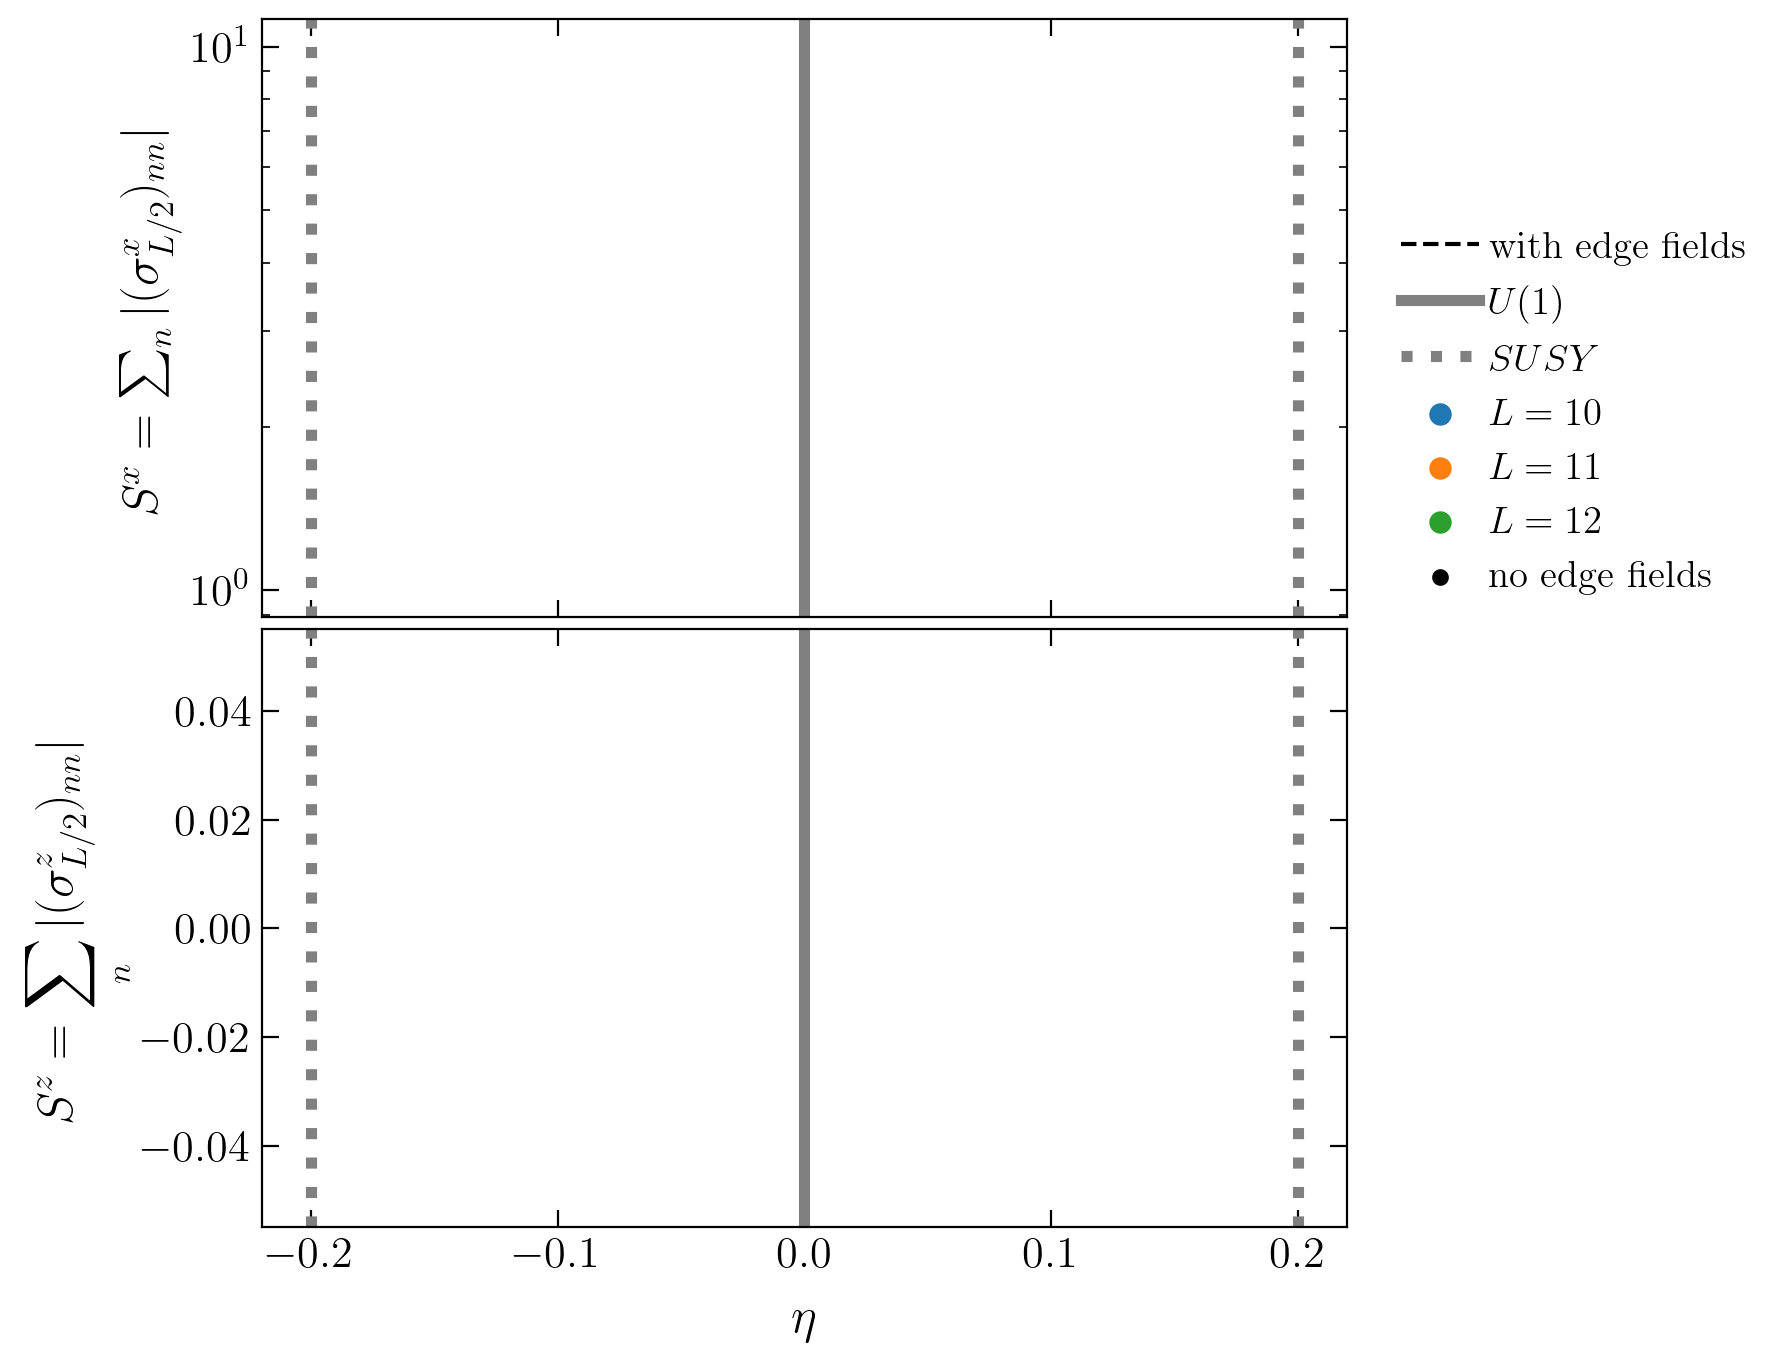

In [41]:
fig, axis = plt.subplots( nrows=2, ncols=1, figsize=(7,8), dpi = 200, sharex=True)

L=12
J1=1.0
d1=0.48
e1=0.4

J2=0.0
d2=0.0
e2=0.0

hx=0.0
hz=0.0
w=0
pb=0
edge=1

etas = np.arange(start=-0.3, step=0.02, stop=0.3)

colors_ls_cyc = itertools.cycle(colors_ls)
for ii, L in enumerate([10, 11, 12]):
    col = next(colors_ls_cyc)
    for edge in [0, 1]:
        sigX = []
        sigZ = []
        for e1 in etas:
            filename = base_dir + "DiagMatElem/" + info_dis(L, J1, J2, d1, d2, e1, e2, hx, hz, w, pb, edge) + "_jobid=0.hdf5"
            if exists(filename):
                with h5py.File(filename, "r") as file:
                        energies = np.array(file.get('energies')).flatten()
                        sigX.append(np.sum(np.abs(np.array(file.get('sigmaX_L_2')).view('complex').flatten())))
                        sigZ.append(np.sum(np.abs(np.array(file.get('sigmaZ_L_2')).view('complex').flatten())))
            else: 
                print(filename)
                sigX.append(np.nan)
                sigZ.append(np.nan)
        if edge == 0: 
             axis[0].scatter(etas, sigX, marker='o', color=col, s=50, label=r"$L=%d$"%L)
             axis[1].scatter(etas, sigZ, marker='o', color=col, s=50)
        else:
             axis[0].plot(etas, sigX, color=col, ls='--')
             axis[1].plot(etas, sigZ, color=col, ls='--')


axis[0].scatter(np.nan, np.nan, marker='o', color='black', s=25, label="no edge fields")
axis[0].plot(np.nan, np.nan, ls='--', color='black', label="with edge fields")

for ax in axis:
     ax.axvline(x=0, ls='-', lw=4, c='gray', label=r"$U(1)$")
     ax.axvline(x=0.2, ls=':', lw=4, c='gray', label=r"$SUSY$")
     ax.axvline(x=-0.2, ls=':', lw=4, c='gray')
fig_help.set_plot_elements(axis[0], ylabel=r"$S^x=\sum_n|(\sigma^x_{L/2})_{nn}|$", xlabel=r"$\eta$", font_size=16, set_legend=True, yscale='log')
axis[0].legend(loc = 'lower right', columnspacing=0.4, frameon=False, fontsize=14, handletextpad=0.25, handlelength = 2., bbox_to_anchor=(1.4,-0.02))

fig_help.set_plot_elements(axis[1], ylabel=r"$$S^z=\sum_n|(\sigma^z_{L/2})_{nn}|$$", xlabel=r"$\eta$", font_size=16, set_legend=False, yscale='log')

axis[1].set_yscale('linear')
fig.subplots_adjust(wspace = 0.02, hspace=0.02)

plt.savefig("diagonal_matrix_elements.pdf", bbox_inches = 'tight', pad_inches=0.02)

## DEGENERACY

9364 16384
14 -0.48 0.03680419921875
9364 16384
14 0.48 0.039306640625
9364 16384
14 0.0 0.7093505859375
17480 32768
15 -0.48 0.2984619140625
17480 32768
15 0.48 0.0
17480 32768
15 0.0 0.24627685546875
36883 65536
16 -0.48 0.078338623046875
36883 65536
16 0.48 0.0802764892578125
36883 65536
16 0.0 0.8471527099609375
69392 131072
17 -0.48 0.387725830078125
69392 131072
17 0.48 0.0
69392 131072
17 0.0 0.326080322265625
145644 262144
18 -0.48 0.1303558349609375
145644 262144
18 0.48 0.13188552856445312
145644 262144
18 0.0 0.8657264709472656
275942 524288
19 -0.48 0.456756591796875
275942 524288
19 0.48 0.0
275942 524288
19 0.0 0.40000152587890625
576772 1048576
20 -0.48 0.18388843536376953
576772 1048576
20 0.48 0.18532657623291016
576772 1048576
20 0.0 0.9170656204223633
1098516 2097152
21 -0.48 0.5072383880615234
1098516 2097152
21 0.48 0.0
1098516 2097152
21 0.0 0.4518318176269531
2287804 4194304
22 -0.48 0.2316739559173584
2287804 4194304
22 0.48 0.2329559326171875
2287804 4194304
22

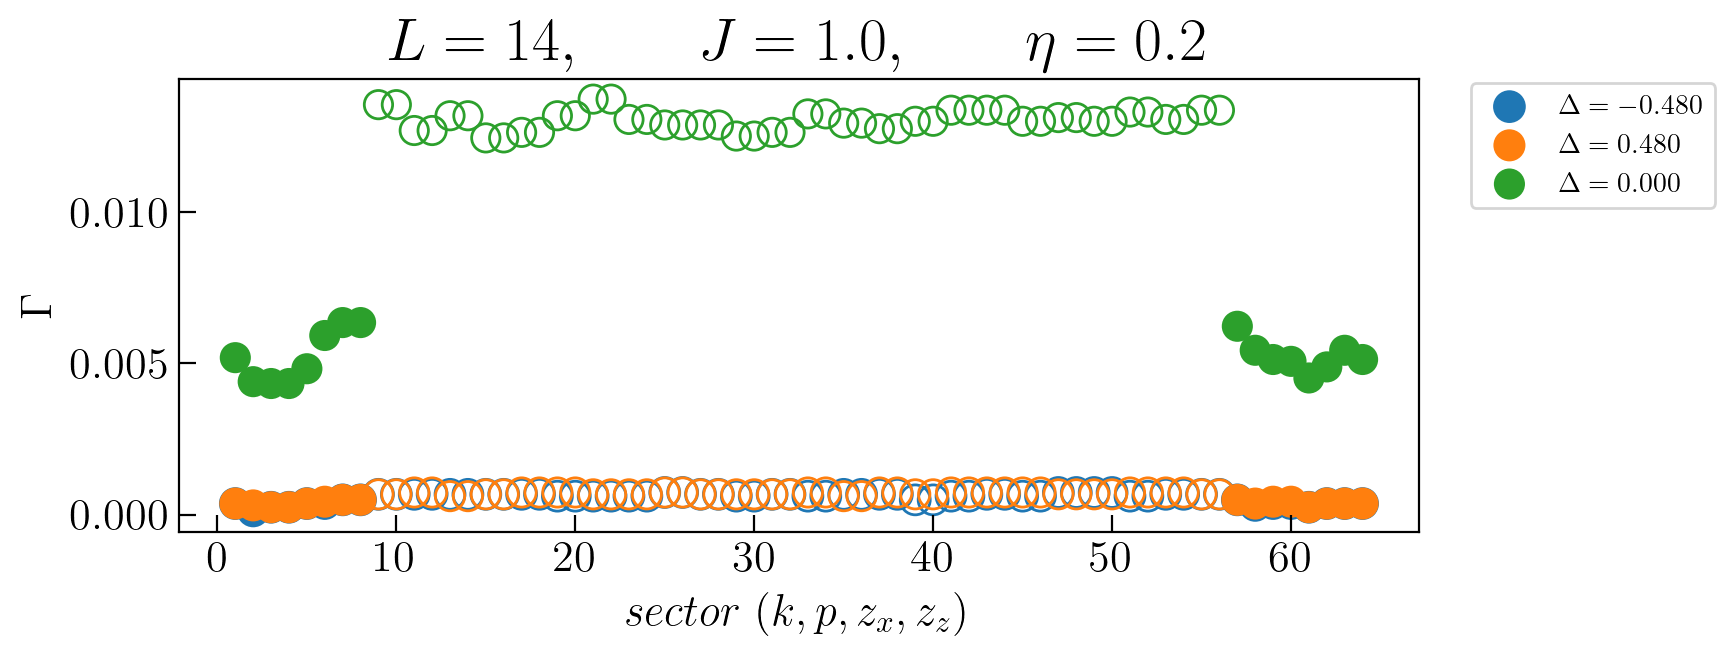

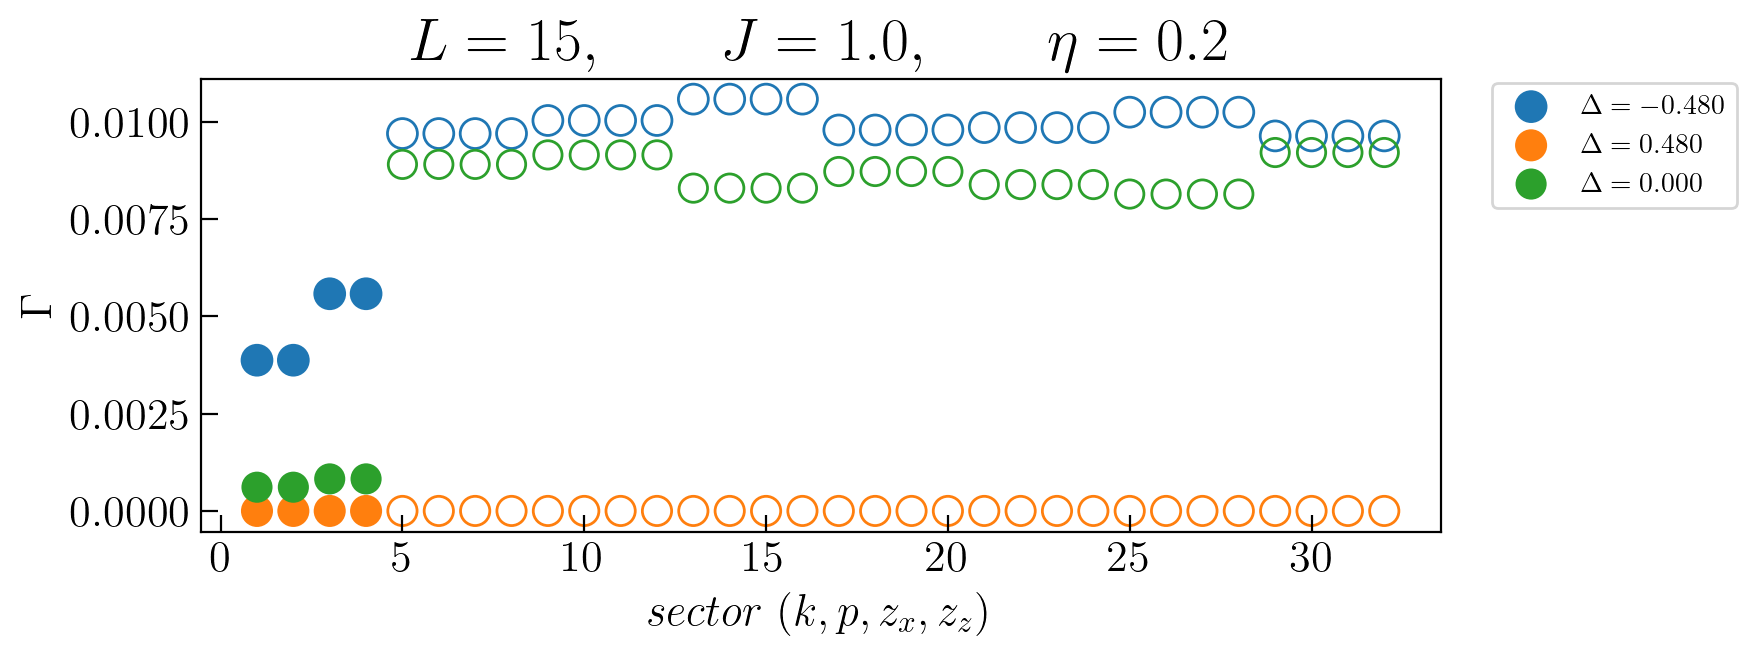

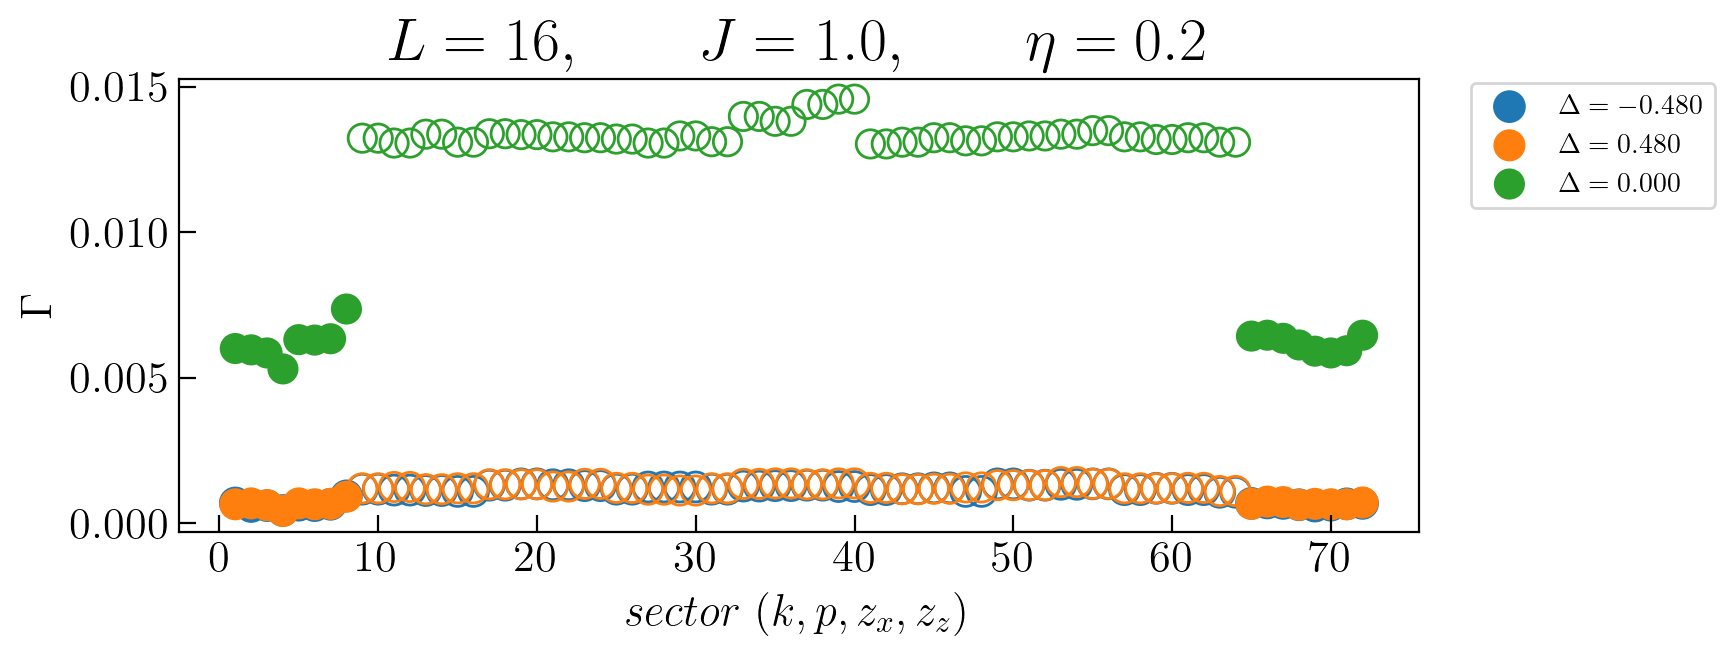

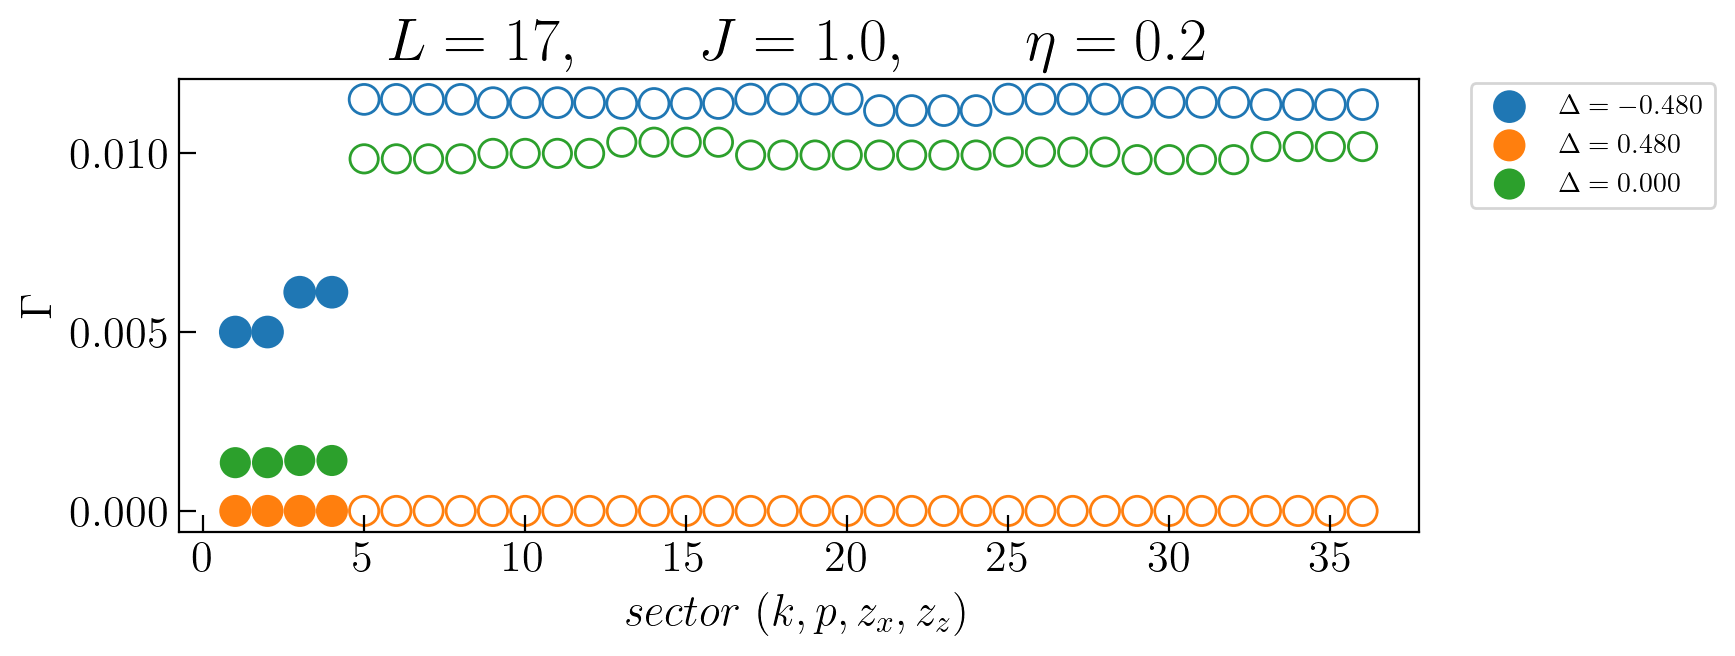

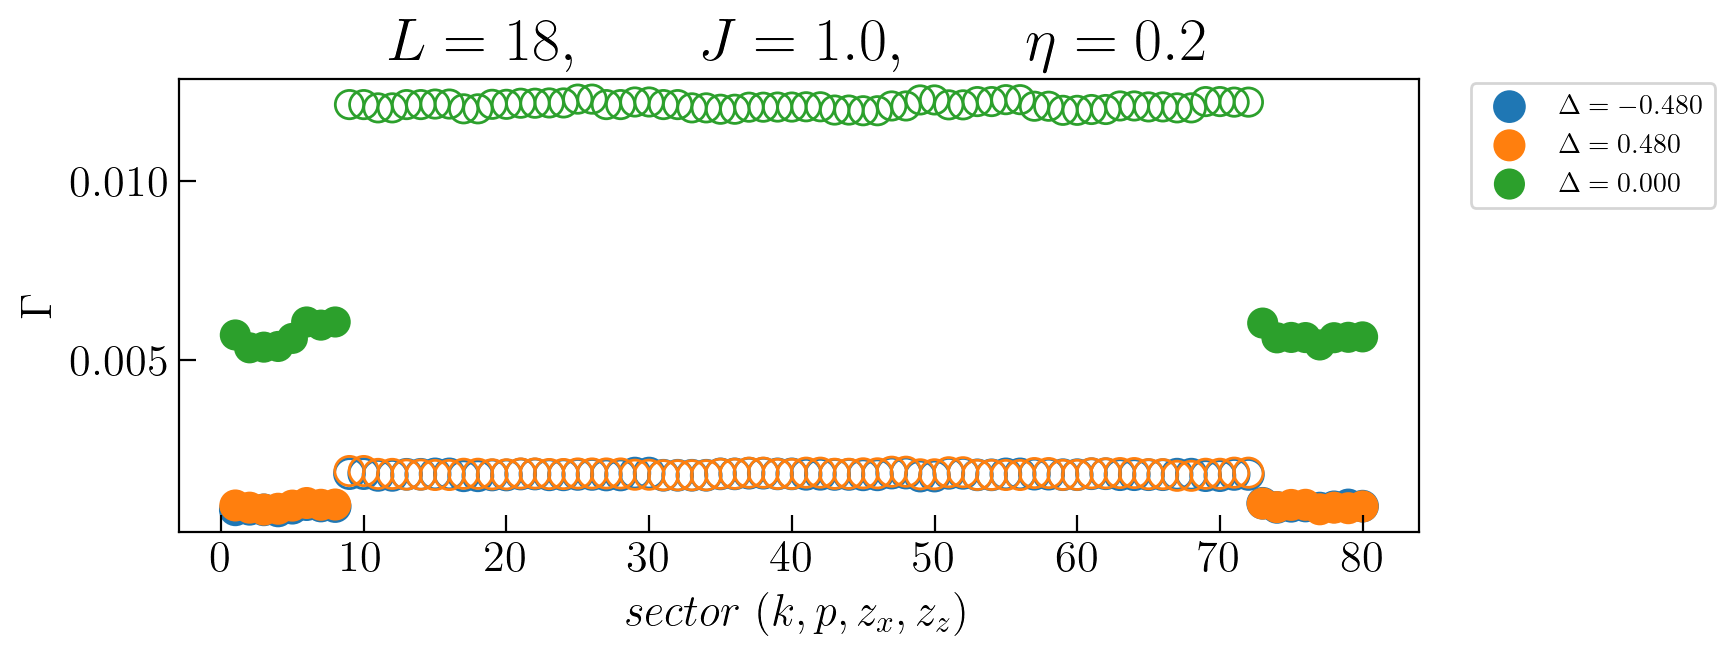

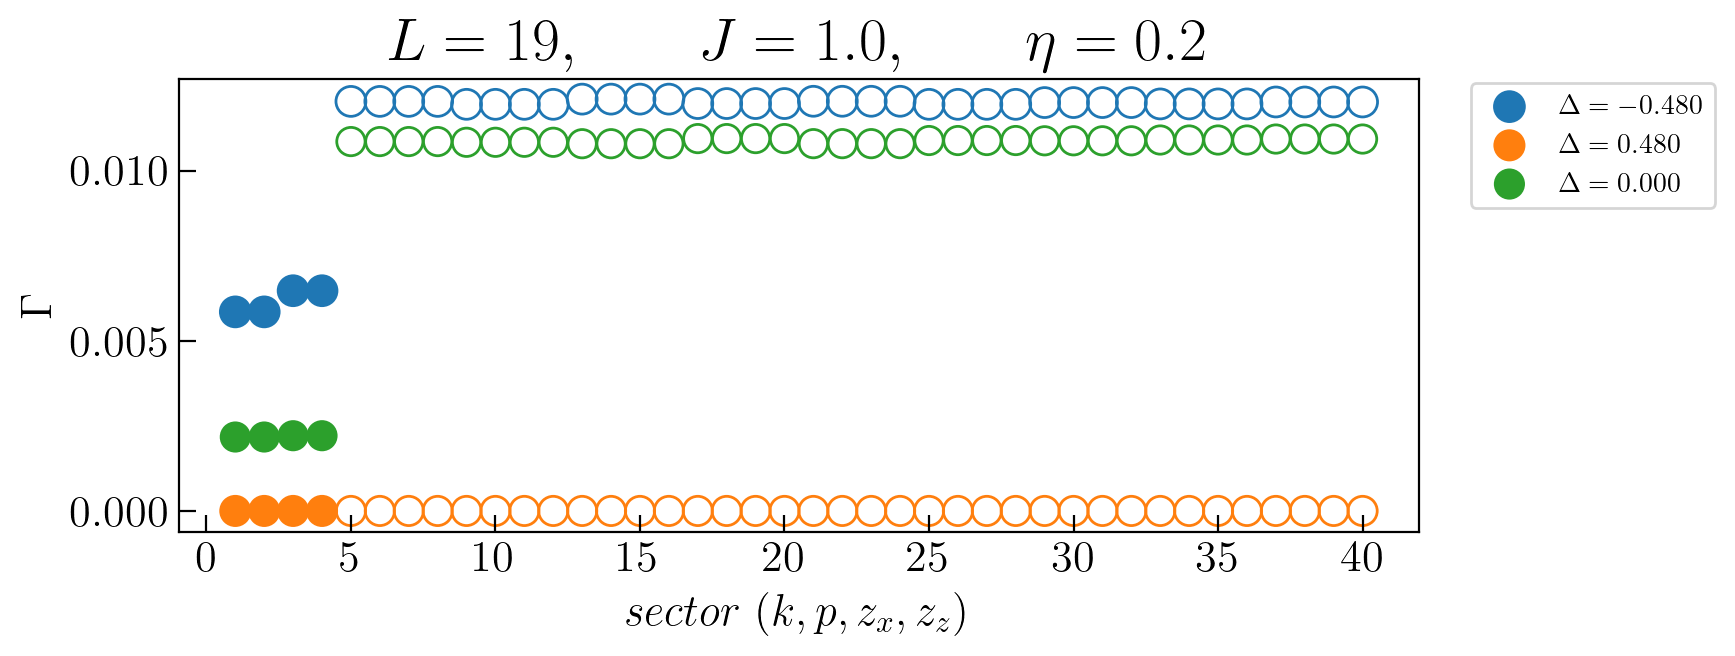

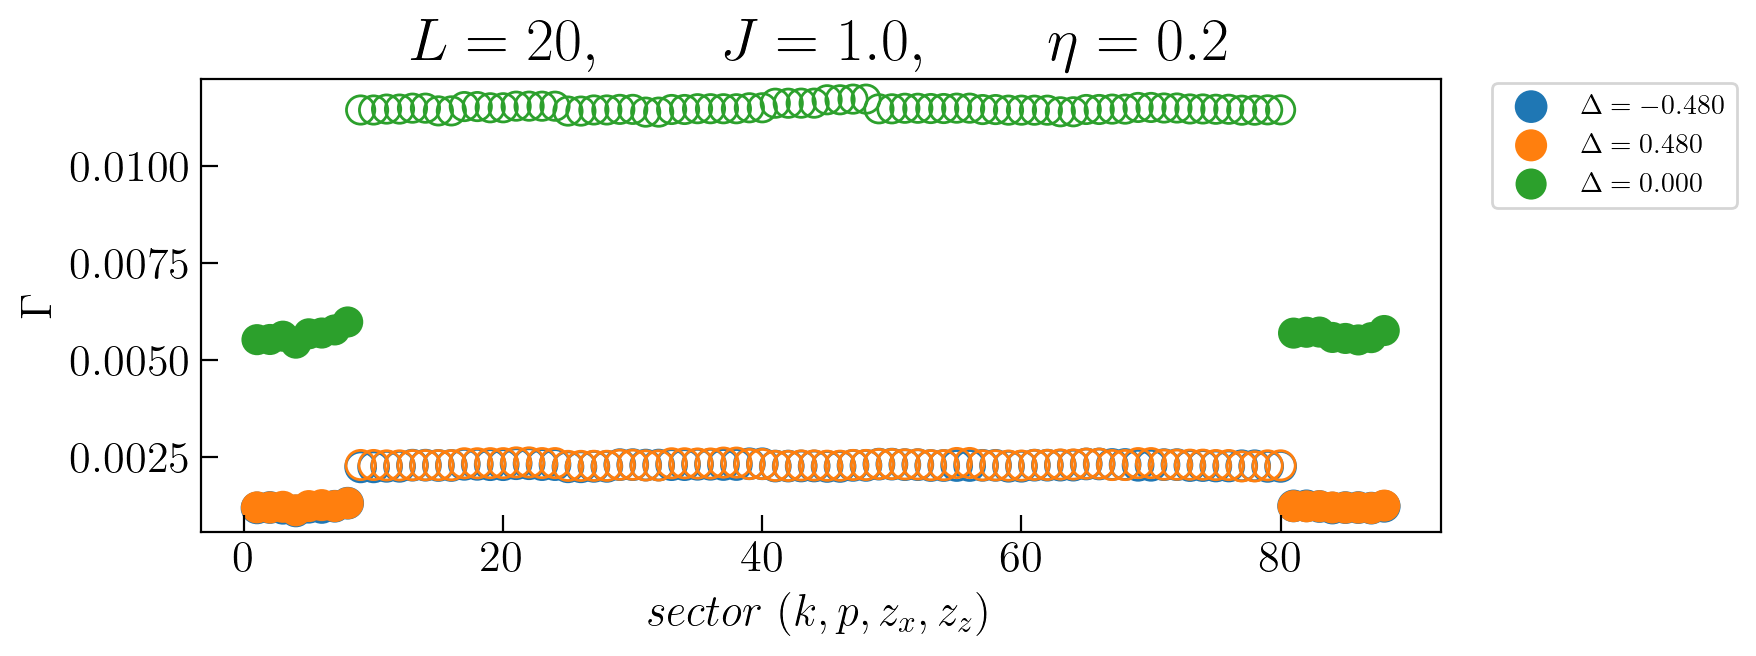

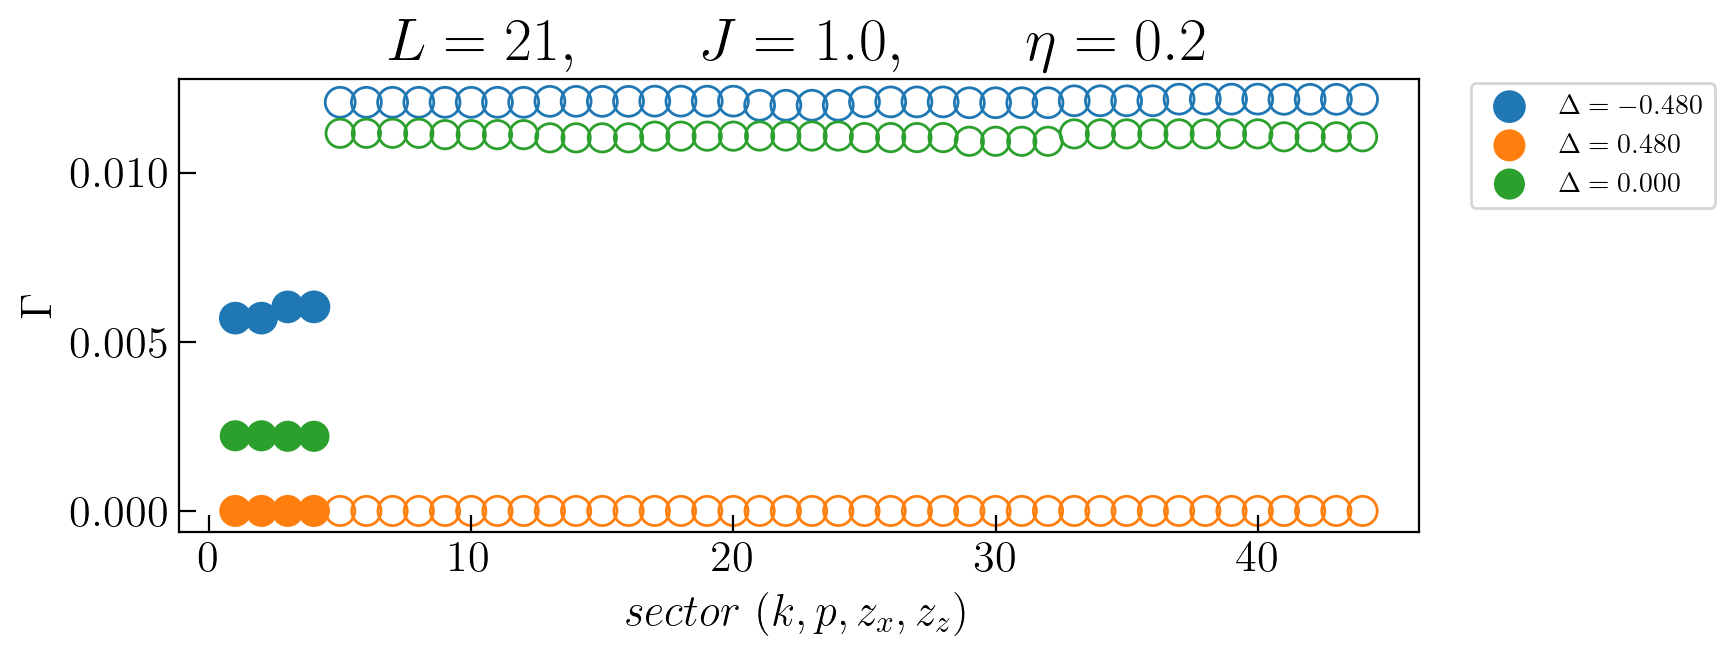

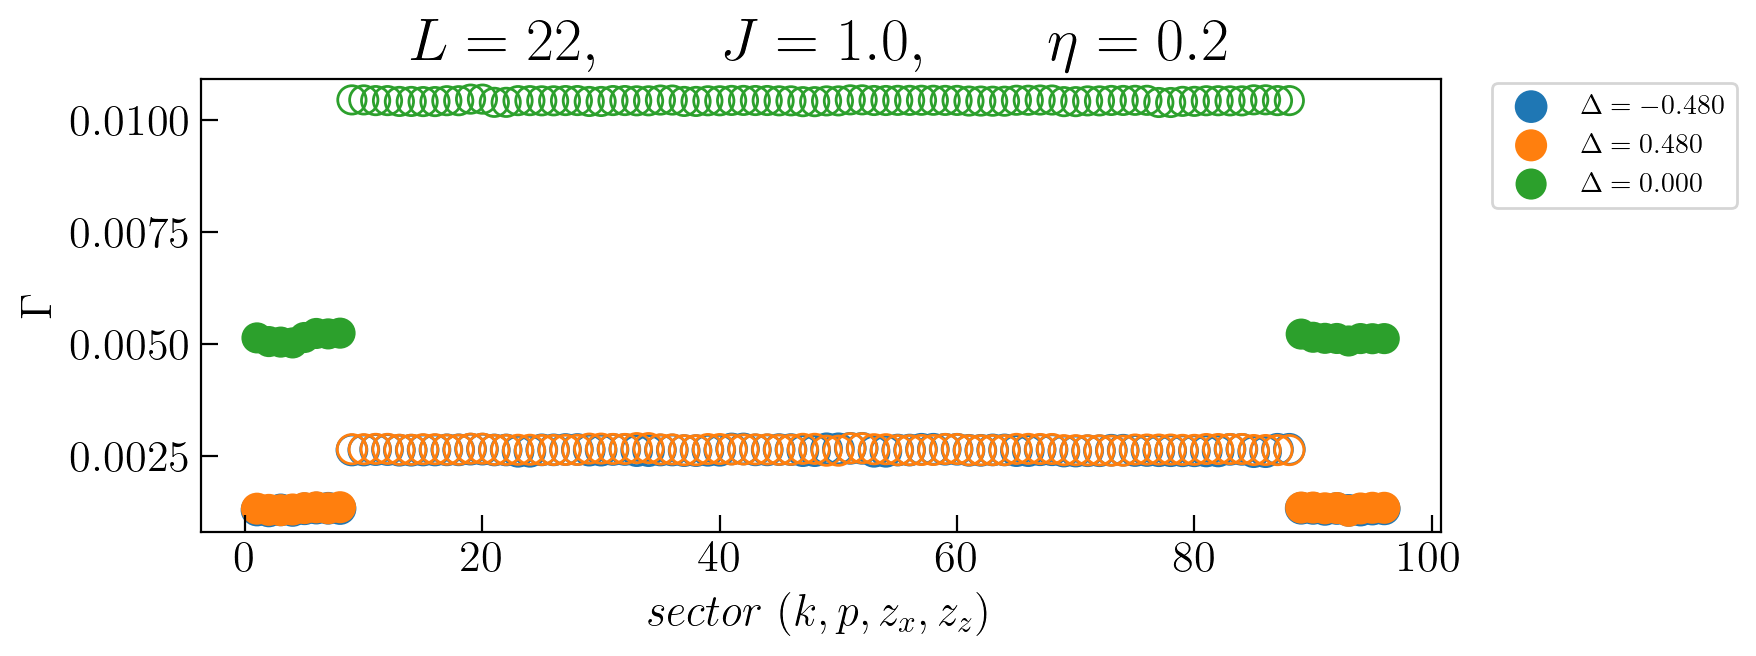

In [93]:

L=12
J1=1.0
d1=0.125
e1=0.5

J2=0.0
d2=0.0
e2=0.0

hx=0.0
hz=0.0

k=0
p=1
zx=1
zz=1
edge = 0
sizes = np.array([10, 11, 12, 13]) if BOUNDARY_COND == 'OBC' else np.arange(14, 23, 1)
#sizes = [10, 11, 12, 13]
deltas = np.array([ [0.5, -0.375], [0.5, -0.75], [0.2, -0.48], [0.2, 0.48] ])
deltas = np.array([ [0.2, -0.48], [0.2, 0.48] , [0.2, 0.0]])
# deltas = np.array([ [0.1, 0], [0.2, 0.0] ])
degen_sum = np.zeros( (sizes.size, deltas.size) )

for jj, L in enumerate(sizes):

    fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(8,3), dpi = 200, sharey=True, sharex=True)

    real_sec, imag_sec = get_sectors(L, hx, hz)
    sectors = [*real_sec, *imag_sec]
    # sectors = real_sec
    sectors = sorted(sectors, key=lambda x: x[0])

    dim_tot = 2**L
    colors_ls_cyc = itertools.cycle(colors_ls)
    for ii, [e1, d1] in enumerate(deltas):
    #for d1 in [0.75]:
        col = next(colors_ls_cyc)
        m_deg = 0
        tot_degen = []
        sector_names = []
        dim_check = 0
        fcs = []
        for [ks, ps, zxs, zzs] in (sectors):
            sec_str = ""
            if BOUNDARY_COND == 'PBC':                          sec_str += "$(%d\pi/L$,"%(2*ks)
            else:                                               sec_str += "$($"
            if BOUNDARY_COND == 'OBC' or (k==0 or k==L//2):     sec_str += "$%d$"%ps
            if hx == 0:                                         sec_str += "$,%d$"%zzs
            if hz == 0 and not edge and (L % 2 == 0 or hx != 0):sec_str += "$,%d)$"%zxs
            else:                                               sec_str += "$)$"
            sector_names.append(sec_str)

            name = base_dir + 'Entropy/Eigenstate/' + info_sym(L, J1, J2, d1, d2, e1, e2, hx, hz, ks, ps, zxs, zzs, edge) + ".hdf5"
            degen_num = 0
            if exists(name):

                with h5py.File(name, "r") as file:
                    try:
                        energies = np.array(file.get('energies'))[0]
                        dim = energies.size
                        dim_check += dim

                        _, indices, counts = np.unique(np.round(energies, 14), return_index=True, return_counts=True)
                        deg_idx = []
                        for new_iii, idx in enumerate(indices):
                            if counts[new_iii] > 1:
                                for _ in range(counts[new_iii]):
                                    deg_idx.append(idx)
                        
                        tot_degen.append(len(deg_idx) / dim_tot)
                        fcs.append(col if ks == 0 or (ks == L // 2 and L%2==0) else 'None')
                        if not (ks == 0 or (ks == L // 2 and L%2==0)) :
                            tot_degen.append(len(deg_idx) / dim_tot)
                            fcs.append('None')

                    except IndexError:
                        print(name)
            else:
                a=1
                print(name)
        # max_degen_L.append(m_deg)
        print(dim_check, dim_tot)
        data = {'sectors': sector_names, 'degeneracies': tot_degen}
        
        
        ydata = np.array(data['degeneracies'])
        print(L, d1, np.sum(ydata))
        degen_sum[jj][ii] = np.sum(ydata)
        width = 0.1
        shift = 0#- width/2 + width * ii
        bins = np.array([x + shift for x in range(1, len(ydata) + 1)])
        #axis.bar(bins, ydata, width = width, label=r"$\Delta=%.3f$"%d1, linewidth=3, alpha=0.5)
        #axis.set_xticks([x for x in range(1,len(ydata) + 1)])
        
        axis.scatter(bins, ydata, label=r"$\Delta=%.3f$"%d1, edgecolors=col, facecolors=fcs, s=int(120 - (ii+2)**2))
    
    #axis.set_xticklabels(data['sectors'], rotation=90, rotation_mode="anchor", ha="right")

    axis.legend(loc='upper right', bbox_to_anchor=(1.25,1.02))
        
    axis.set_ylabel(r"$\Gamma$", fontsize=16)
    if BOUNDARY_COND == 'PBC':  axis.set_xlabel(r"$sector\ (k,p,z_x,z_z)$", fontsize=16)
    else:                       axis.set_xlabel(r"$sector\ (p,z_x,z_z)$", fontsize=16)
    axis.tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
    axis.tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)
    
    axis.set_title(r"$L=%d,\qquad J=%.1f,\qquad \eta=%.1f$"%(L, J1, e1), fontsize=22 )


even -0.48 [5.16766193 0.61641739] [3.09111878e-04 5.45800336e-09] [18 20 22]
odd -0.48 [11.38591757  1.03213866] [8.35744083e-01 6.77834648e-07] [17 19 21]
even 0.48 [5.15221156 0.61599538] [2.66219584e-04 4.75725503e-09] [18 20 22]
even 0.0 [366.91344859   2.75065126] [3.67680388e+12 2.65241011e+00] [18 20 22]
odd 0.0 [10.91056296  0.98342266] [2.75007345e+00 2.64272606e-06] [17 19 21]


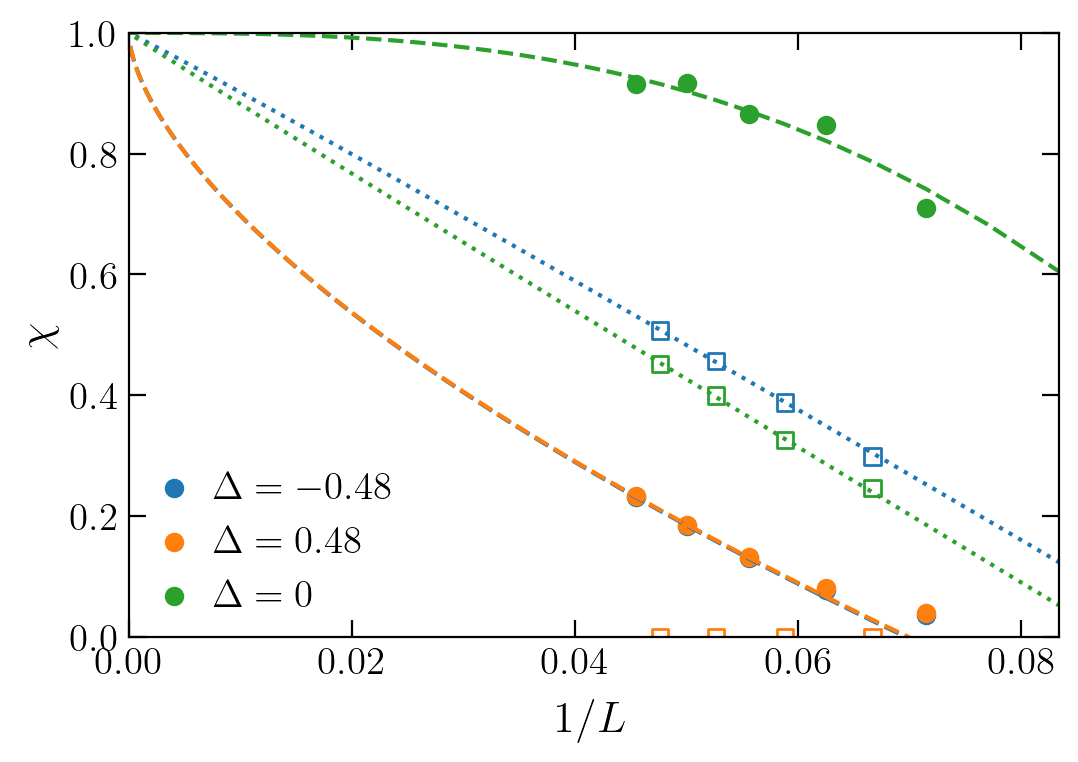

In [94]:

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(6,4), dpi = 200)

alfa=0.01

def func_x(x):
    return 1. / x #np.log(x)

colors_ls_cyc = itertools.cycle(colors_ls)

def fiter(x, a, alfa):
    return 1 - a / x**alfa
for ii, [e1, d1] in enumerate(deltas):
    col = next(colors_ls_cyc)
    for jj, L in enumerate(sizes):
        degen = np.transpose(degen_sum)[ii][jj]
        # if degen > 0: degen = 1./degen
        # else: degen = np.nan
        # print(e1, d1, degen)
        axis.scatter(func_x(L), degen, edgecolor=col, marker='o' if not L%2 else 's', facecolor=col if not L%2 else 'None')
    
    if np.any(np.transpose(degen_sum)[ii][::2] > 0):
        if not np.any(np.isnan(np.transpose(degen_sum)[ii][::2])):
            degen = np.transpose(degen_sum)[ii][4::2]
            Ls = sizes[4::2]

            # if np.all(degen > 0): degen = 1. / (degen)

            pars, pconv = fit(fiter,
                            xdata = Ls,
                            ydata = degen,
                            maxfev=10000)
            print("even", d1, pars, np.diag(pconv)**2, Ls)
            aa = np.linspace(sizes[0]/2, 10000, 10000)
            axis.plot(func_x(aa), fiter(aa, *pars), ls='--', color=col)
    # axis.scatter(np.nan, np.nan, edgecolor=col, marker='o', facecolor=col, label=r"${\rm even}:\quad\sim %.2f\ln L$"%(-pars[0]))
    axis.scatter(np.nan, np.nan, edgecolor=col, marker='o', facecolor=col, label=r"$\Delta=%g$"%d1, zorder=2*ii)
    
    if np.any(np.transpose(degen_sum)[ii][1::2] > 0):
        if not np.any(np.isnan(np.transpose(degen_sum)[ii][1::2])):
            degen = np.transpose(degen_sum)[ii][3::2]
            Ls = sizes[3::2]

            # if np.all(degen > 0): degen = 1. /  (degen)
            pars, pconv = fit(fiter,
                            xdata = Ls,
                            ydata = degen,
                            maxfev=10000)
            print("odd", d1, pars, np.diag(pconv)**2, Ls)
            aa = np.linspace(sizes[0]/2, 10000, 10000)
            axis.plot(func_x(aa), fiter(aa, *pars), ls=':', color=col)
            # axis.scatter(np.nan, np.nan, edgecolor=col, marker='s', facecolor='None', label=r"${\rm odd}\ :\quad\sim %.2f\ln L$"%(np.round(pars[1],2)))
            axis.scatter(np.nan, np.nan, edgecolor=col, marker='o', facecolor='None', zorder=2*ii+1)
    

# axis.scatter(np.nan, np.nan, color='k', marker='o', label='even', zorder=len(deltas))
# axis.scatter(np.nan, np.nan, color='k', marker='s', facecolor='None', label = 'odd', zorder=len(deltas)+1)
N = 3
# axis.plot(np.log(aa), -0.235 + 0.09 * np.log(aa), ls='--', color='black')
# axis.plot(np.log(aa), 1e-4 * aa**2, ls='--', color='red')

# axis.annotate(r"$\left.\begin{array}{c}\ \\ \ \end{array}\right\}\Delta=-0.48$", fontsize=14, xy=(0.25, 0.85), xycoords='axes fraction')
# axis.annotate(r"$\left.\begin{array}{c}\ \\ \ \end{array}\right\}\Delta=0.48$", fontsize=14, xy=(0.25, 0.67), xycoords='axes fraction')

x1 = func_x(12)
x2 = func_x(23)
axis.set_xlim(min([0, x1, x2]), max([x1, x2]))
axis.set_ylim(0, 1.0)
fig_help.set_plot_elements(axis, xlabel=r"$1 / L$", ylabel=r"$\chi$", font_size=14, set_legend=False, xscale='linear', yscale='linear')
axis.legend(frameon=0, fontsize=14, loc='lower left', ncol=1, handletextpad=0.25, handlelength = 1.5, bbox_to_anchor=(-0.02,-0.02), columnspacing=1.5)

plt.savefig("PLOTS/degeneracy_fraction.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig("PLOTS/degeneracy_fraction.png", bbox_inches = 'tight', pad_inches=0.02)

$\Gamma>1$ [603, 5134, 34172, 192821, 971711]
$\Gamma>4$ [5, 0, 135, 2669, 23077]
$\Gamma>\frac{L}{4}$ [313, 0, 135, 2304, 18087]
$\Gamma>\frac{L}{2}$ [0, 0, 72, 361, 1345]


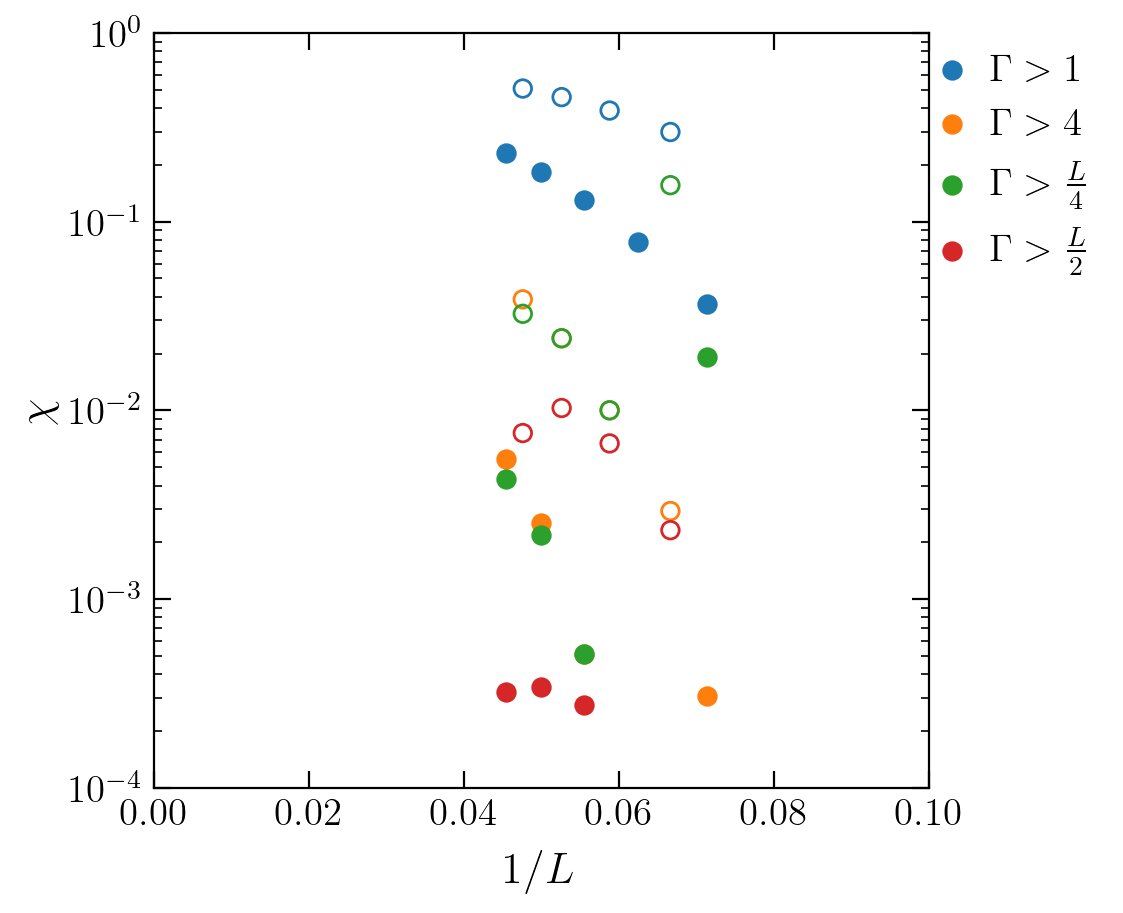

In [103]:

L=12
J1=1.0
d1=-0.48
e1=0.2

J2=0.0
d2=0.0
e2=0.0

hx=0.0
hz=0.0
edge = 0

colors_ls_cyc = itertools.cycle(colors_ls)
sizes = np.array([10, 11, 12, 13]) if BOUNDARY_COND == 'OBC' else np.arange(14, 23, 1)
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)

def fiter(x, a, alfa):
    return 1 - a / x - alfa / x**2

names = [r"$\Gamma>1$", r"$\Gamma>4$", r"$\Gamma>\frac{L}{4}$", r"$\Gamma>\frac{L}{2}$"]
for ii, condition in enumerate([lambda x, L: x > 1, lambda x, L: x > 4, lambda x, L: x > L//4, lambda x, L: x > L // 2]):
    
    degen_size_even = []
    degen_size_odd = []
    col = next(colors_ls_cyc)
    for jj, L in enumerate(sizes):
        real_sec, imag_sec = get_sectors(L, 0, 0)
        sectors = [*real_sec, *imag_sec]
        # sectors = real_sec
        sectors = sorted(sectors, key=lambda x: x[0])

        dim_tot = 2**L
        
        dim_check = 0
        degenerate_subspace_size = 0
        for [ks, ps, zxs, zzs] in (sectors):

            name = base_dir + 'Entropy/Eigenstate/' + info_sym(L, J1, J2, d1, d2, e1, e2, hx, hz, ks, ps, zxs, zzs, edge) + ".hdf5"
            if exists(name):
                with h5py.File(name, "r") as file:
                    try:
                        energies = np.array(file.get('energies'))[0]
                        dim = energies.size
                        dim_check += dim  if ks == 0 or (ks == L // 2 and L%2==0) else 2 * dim

                        _, indices, counts = np.unique(np.round(energies, 14), return_index=True, return_counts=True)
                        deg_idx = []
                        for new_iii, idx in enumerate(indices):
                            if condition(counts[new_iii], L):
                                for _ in range(counts[new_iii]):
                                    deg_idx.append(idx)
                        
                        degenerate_subspace_size += len(deg_idx) if ks == 0 or (ks == L // 2 and L%2==0) else 2 * len(deg_idx)
                    except IndexError:
                        print(name)
            else:
                a=1
                print(name)
        
        if L % 2:   degen_size_odd.append(degenerate_subspace_size)
        else:       degen_size_even.append(degenerate_subspace_size)
    
    def plot_with_fit(Ls, degen):
        try:
            pars, pconv = fit(fiter,
                        xdata = Ls,
                        ydata = degen,
                        maxfev=10000)
            print(d1, pars, np.diag(pconv)**2, Ls)
            aa = np.linspace(sizes[0]/2, 10000, 10000)
            axis.plot(1./(aa), fiter(aa, *pars), ls=':', color=col)
        except RuntimeError:
            print("Failed to Fit!")

    Ls = sizes[::2]
    # plot_with_fit(Ls, degen_size_even / 2**Ls)
    axis.scatter(1./Ls, degen_size_even / 2**Ls, label = names[ii], color=col, s=40)
    
    print(names[ii], degen_size_even)
    Ls = sizes[1::2]
    # plot_with_fit(Ls, degen_size_odd / 2**Ls)
    axis.scatter(1./Ls, degen_size_odd / 2**Ls, color=col, facecolor='None', s=40)

axis.set_xlim(0, 0.1)
axis.set_ylim(1e-4, 1.0)
fig_help.set_plot_elements(axis, xlabel=r"$1 / L$", ylabel=r"$\chi$", font_size=14, set_legend=False, xscale='linear', yscale='log')
axis.legend(frameon=0, fontsize=14, loc='upper right', ncol=1, handletextpad=0.25, handlelength = 1.5, bbox_to_anchor=(1.25,1.02), columnspacing=1.5)


4194304

15 0 0.2 No degeneracies
14 -0.375 0.5 No degeneracies
16 -0.375 0.5 No degeneracies
15 -0.75 0.5 No degeneracies
17 -0.75 0.5 No degeneracies
19 -0.75 0.5 No degeneracies
21 -0.75 0.5 No degeneracies
14 -0.75 0.5 No degeneracies
16 -0.75 0.5 No degeneracies
15 0.48 0.2 No degeneracies
17 0.48 0.2 No degeneracies
19 0.48 0.2 No degeneracies
21 0.48 0.2 No degeneracies
14 0.48 0.2 No degeneracies
16 0.48 0.2 No degeneracies
14 -0.48 0.2 No degeneracies
16 -0.48 0.2 No degeneracies


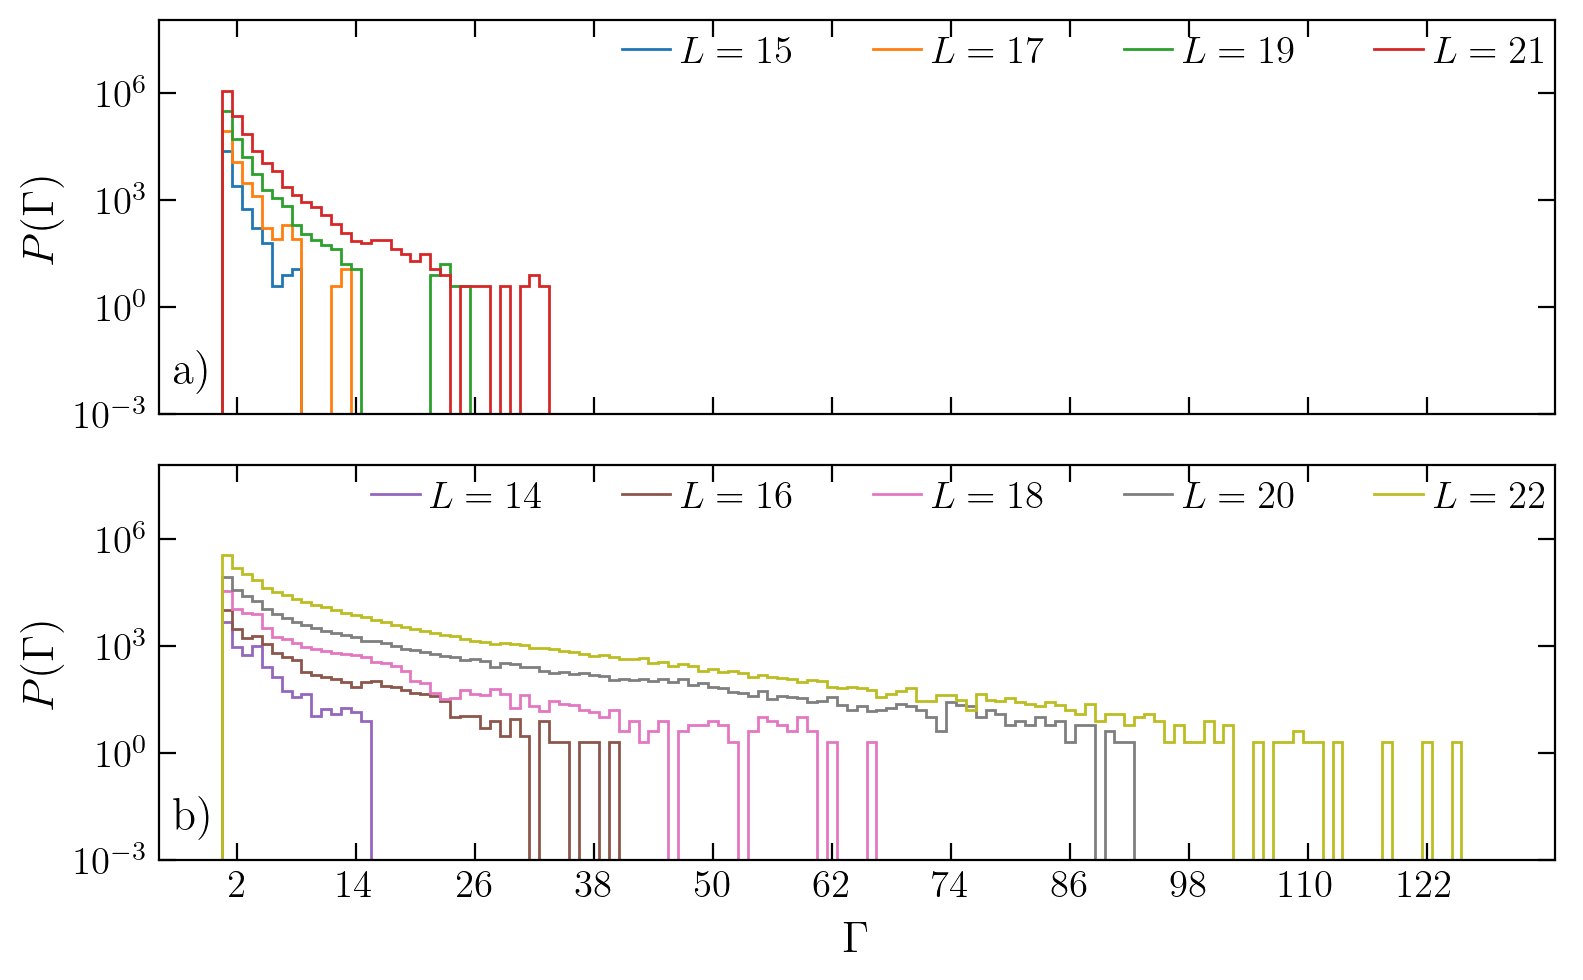

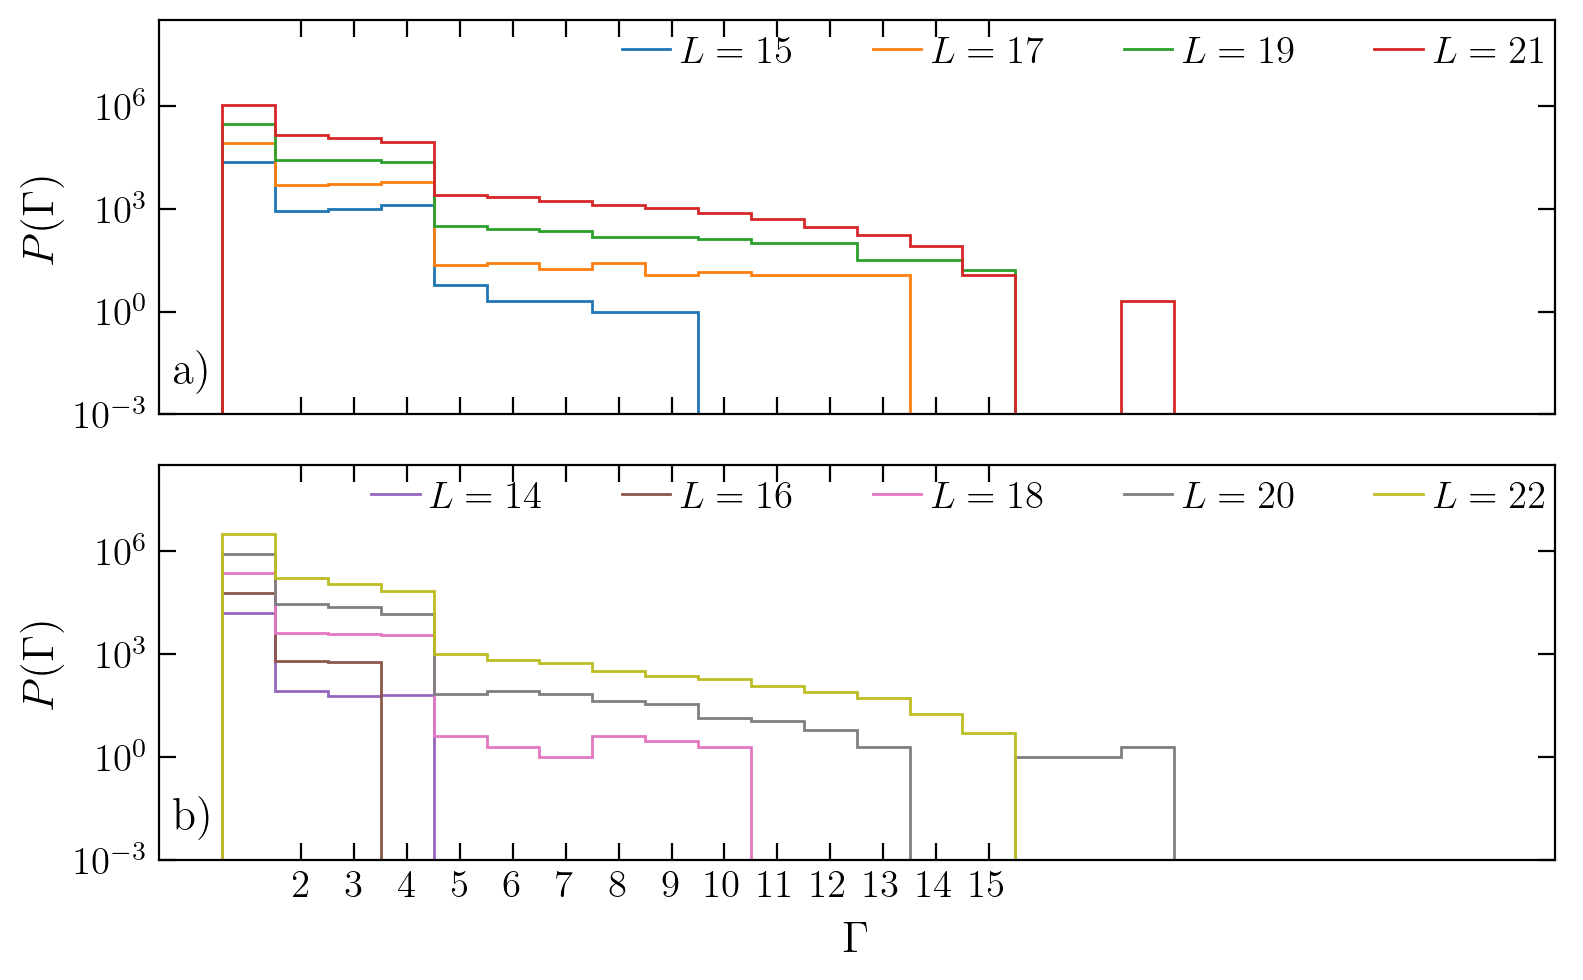

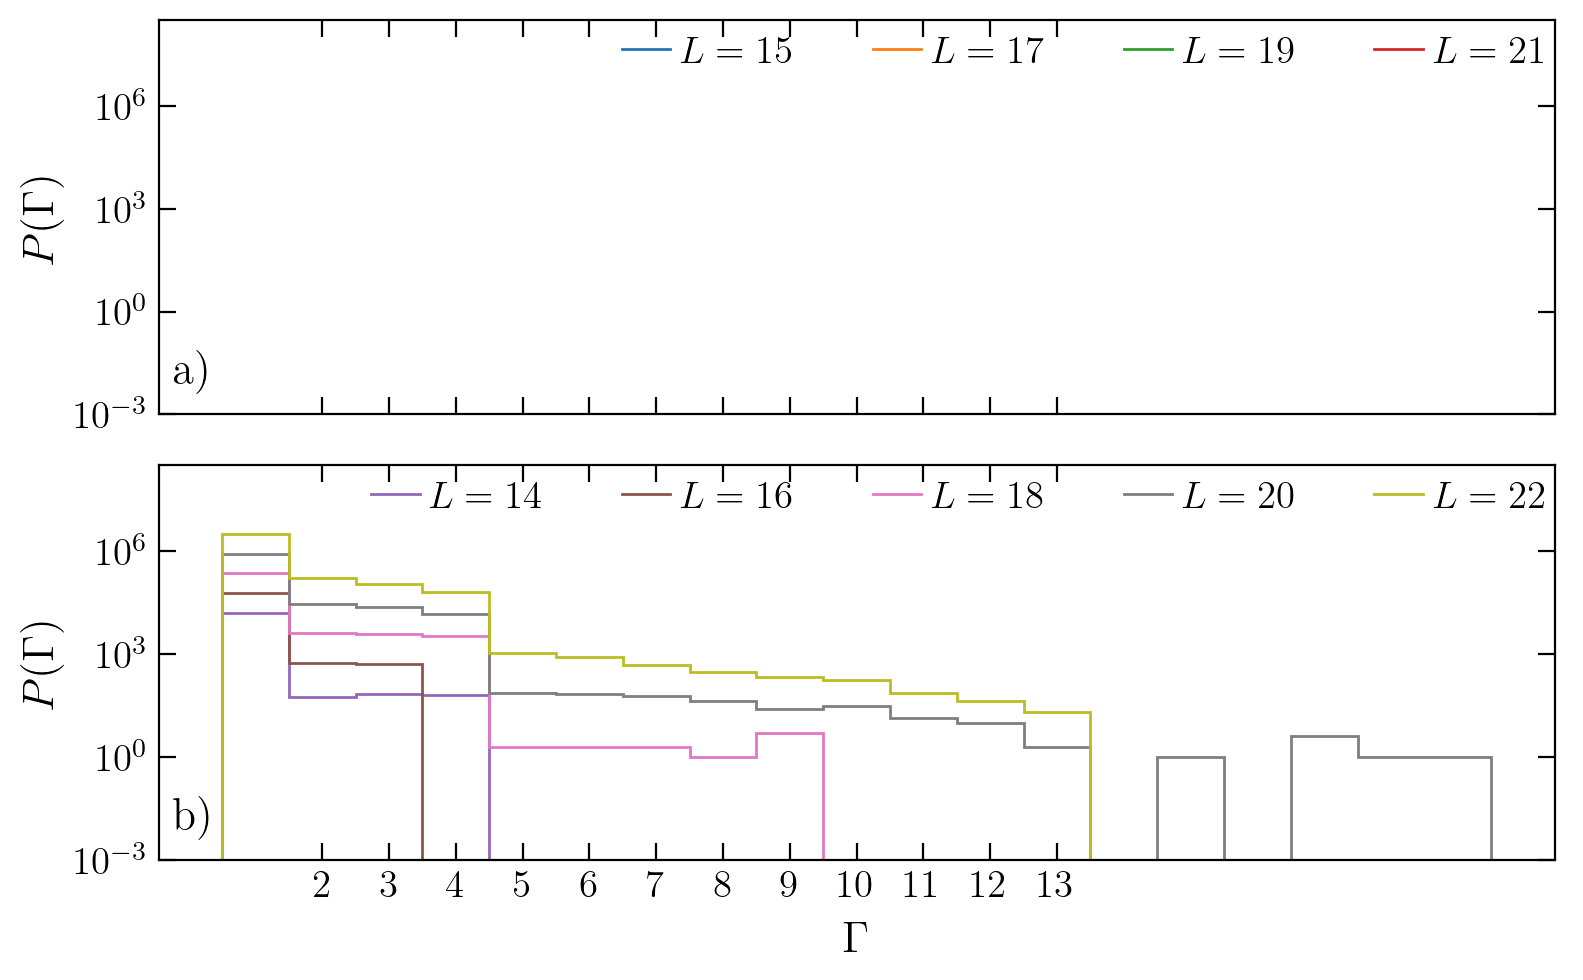

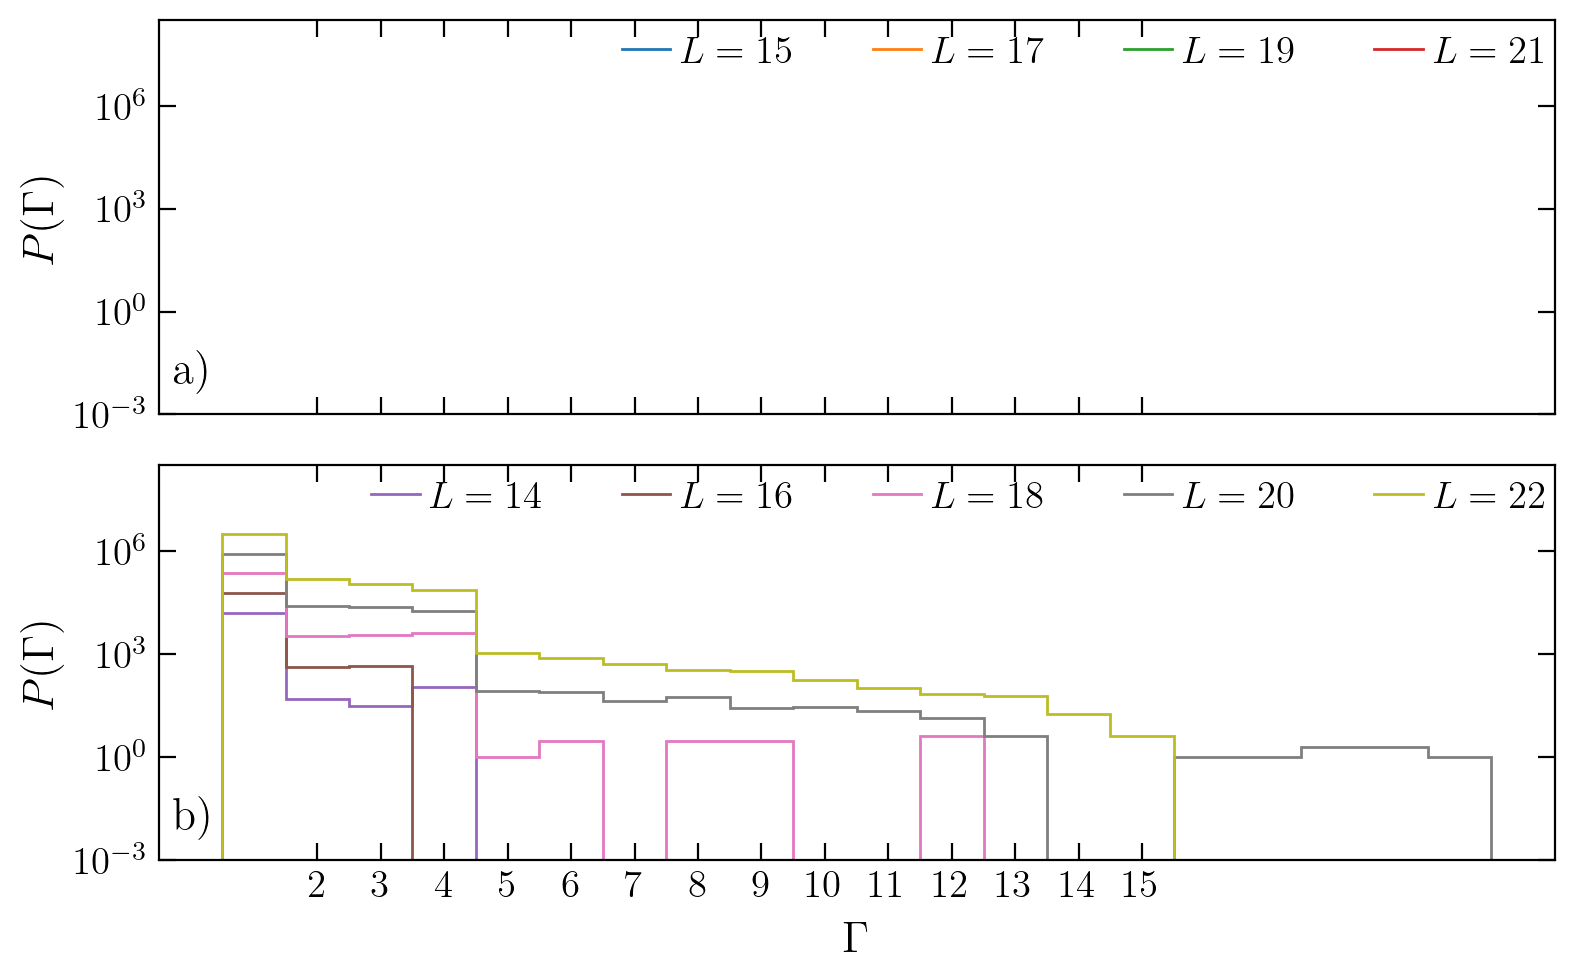

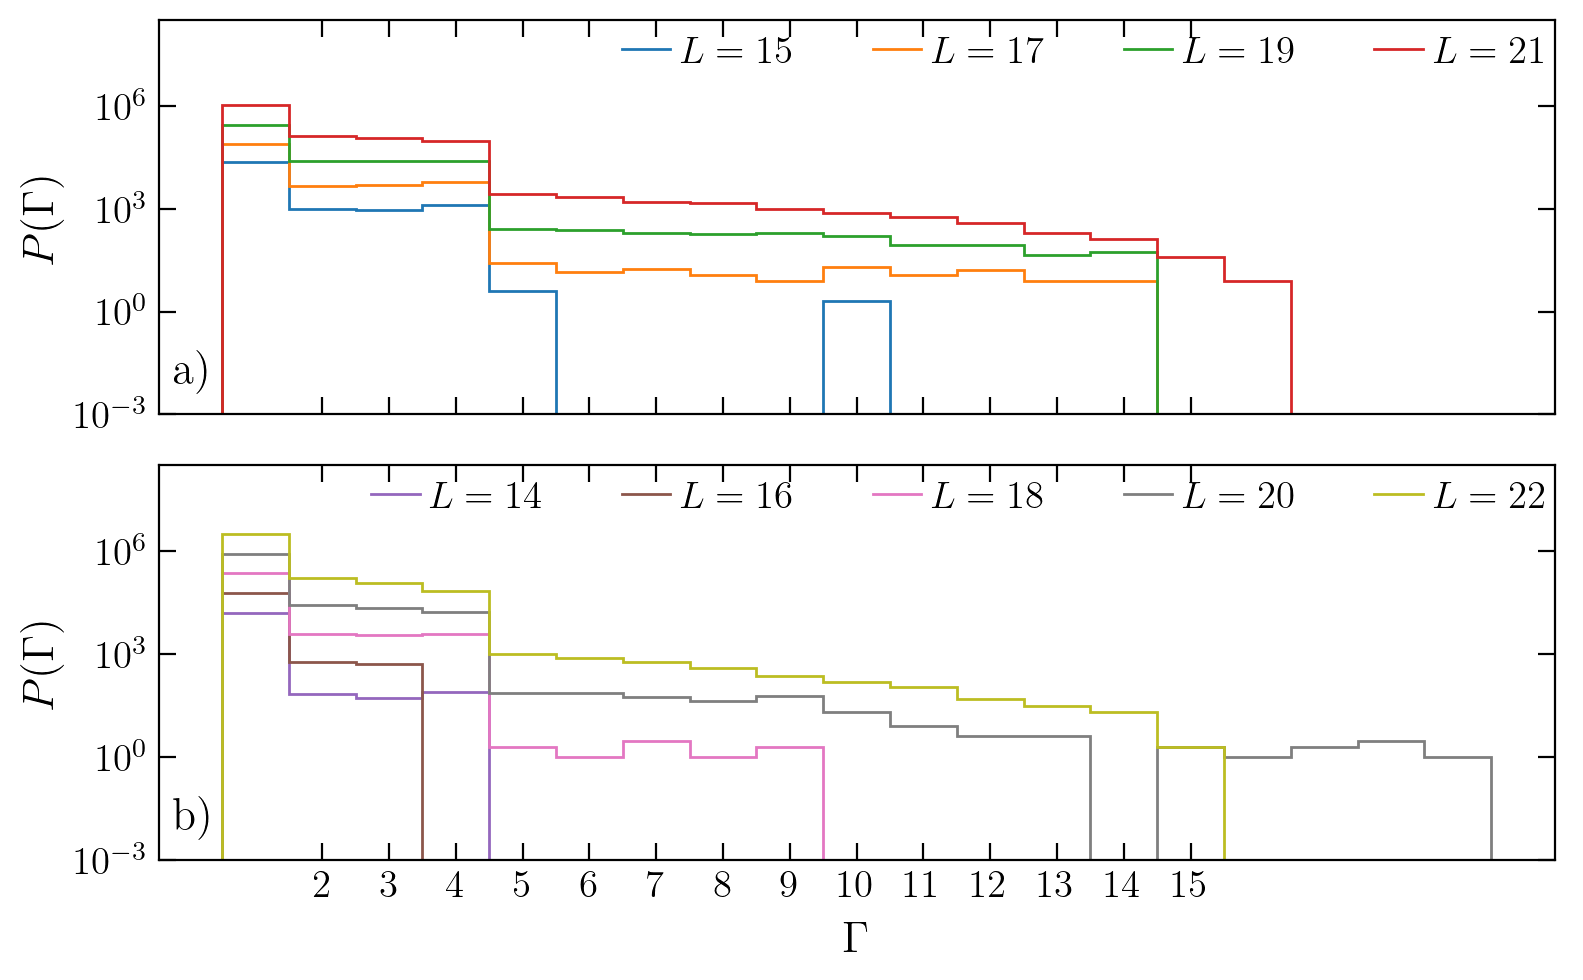

In [223]:
L=12
J1=1.0
d1=-0.375
e1=0.5


sizes = np.arange(16, 24, 2)

for [d1, e1] in [ [0, 0.2], [-0.375, 0.5], [-0.75, 0.5], [0.48, 0.2], [-0.48, 0.2] ]:
    
    fig, axis = plt.subplots( nrows=2, ncols=1, figsize=(8,5), dpi = 200, sharey=True, sharex=True)
    colors_ls_cyc = itertools.cycle(colors_ls)
    ymin = 1e10
    ymax = 1e-10
    for ii, sizes in enumerate([np.arange(15, 23, 2), np.arange(14, 23, 2)]):
        for L in sizes:

            real_sec, imag_sec = get_sectors(L, 0, 0)
            sectors = [*real_sec, *imag_sec]

            dim_tot = 2**L
            col = next(colors_ls_cyc)

            degeneracy_rank = []
            dim_check = 0
            for [ks, ps, zxs, zzs] in (sectors):

                name = base_dir + 'Entropy/Eigenstate/' + info_sym(L, J1, 0, d1, 0, e1, 0, 0, 0, ks, ps, zxs, zzs, 0) + ".hdf5"
                
                if exists(name):

                    with h5py.File(name, "r") as file:
                        energies = np.array(file.get('energies'))[0]

                        _, indices, counts = np.unique(np.round(energies, 14), return_index=True, return_counts=True)
                        #deg_idx = [idx for ii, idx in enumerate(indices) if counts[ii] > 1]

                        degeneracy_rank = [*degeneracy_rank, *counts ] if ks == 0 or (ks == L // 2 and L%2==0) else [*degeneracy_rank, *counts, *counts ]
                        
                        dim = energies.size
                        dim_check += dim if ks == 0 or ks == L / 2 else 2 * dim

                else:
                    print(name)
            if dim_check != dim_tot:
                print("waaaah", L, d1, e1, dim_check, dim_tot) 

            if len(degeneracy_rank) > 0:
                try:
                    # print(L, d1, e1)
                    hist, edges = np.histogram(degeneracy_rank, bins = np.arange(0.5, max(degeneracy_rank)+0.5))
                    # print(L, 2**L, np.sum(hist * np.arange(1, max(degeneracy_rank))))
                    ydata = hist# / np.arange(2, max(degeneracy_rank))# / 2**L
                    # axis[ii].bar(np.arange(2, max(degeneracy_rank)), ydata, label=r"$L=%d$"%L, color=col, fill=False, edgecolor=col, width = L**2 / 24**2)
                    axis[ii].stairs(ydata, edges, label=r"$L=%d$"%L, color=col)
                    
                    fig_help.set_plot_elements(axis[ii], ylabel=r"$P(\Gamma)$", xlabel=r"$\Gamma$" if ii > 0 else "", font_size=14, set_legend=True, yscale='log')
                    axis[ii].legend(frameon=0, fontsize=14, loc='upper right', ncol=5, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.02,1.05))

                    xticks = np.arange(2, max(degeneracy_rank), max(degeneracy_rank) // 10)
                    xticklabels = ["%d"%x for x in xticks]
                    axis[ii].set_xticks(xticks)
                    axis[ii].set_xticklabels(xticklabels)

                    # axis[ii].annotate(r"$\eta=%.1f, \Delta=%.3f$"%(e1,d1), fontsize=16, xy=(0.35, 0.85), xycoords='axes fraction')
                    
                    if min(ydata[ydata > 0]) < ymin: ymin = min(ydata[ydata > 0])
                    if max(ydata[ydata > 0]) > ymax: ymax = max(ydata[ydata > 0])
                except ValueError:
                    print(L, d1, e1, "No degeneracies")

    axis[0].set_ylim(1e-3, 100 * ymax)
    axis[0].annotate(r"a)", fontsize=16, xy=(0.01, 0.08), xycoords='axes fraction')
    axis[1].annotate(r"b)", fontsize=16, xy=(0.01, 0.08), xycoords='axes fraction')

    fig.tight_layout()
    plt.savefig(f"PLOTS/Degeneracy_e1={e1},d1={d1}.pdf", bbox_inches = 'tight', pad_inches=0.02)
    plt.savefig(f"PLOTS/Degeneracy_e1={e1},d1={d1}.png", bbox_inches = 'tight', pad_inches=0.02)

7 File corrupt, no entropies: ../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=-0.48,d2=0,e1=0.2,e2=0,hx=0,hz=0,k=0,p=-1,zx=1,zz=1,edge=0.hdf5
waaaaaaa 4170961 4194304
10 File corrupt, no entropies: ../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=-0.48,d2=0,e1=0.2,e2=0,hx=0,hz=0,k=0,p=-1,zx=-1,zz=-1,edge=0.hdf5
10 File corrupt, no entropies: ../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=-0.48,d2=0,e1=0.2,e2=0,hx=0,hz=0,k=0,p=-1,zx=-1,zz=1,edge=0.hdf5
10 File corrupt, no entropies: ../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=-0.48,d2=0,e1=0.2,e2=0,hx=0,hz=0,k=0,p=-1,zx=1,zz=-1,edge=0.hdf5
10 File corrupt, no entropies: ../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=-0.48,d2=0,e1=0.2,e2=0,hx=0,hz=0,k=0,p=1,zx=-1,zz=-1,edge=0.hdf5
10 File corrupt, no entropies: ../results/symmetries/PBC/Entropy/Eigenstate/_L=22,J1=1,J2=0,d1=-0.48,d2=0,e1=0.2,e2=0,hx=0,hz=0,k=0,p=1,zx=-1,zz=1,edge=0.hdf5
10 File corrupt, 

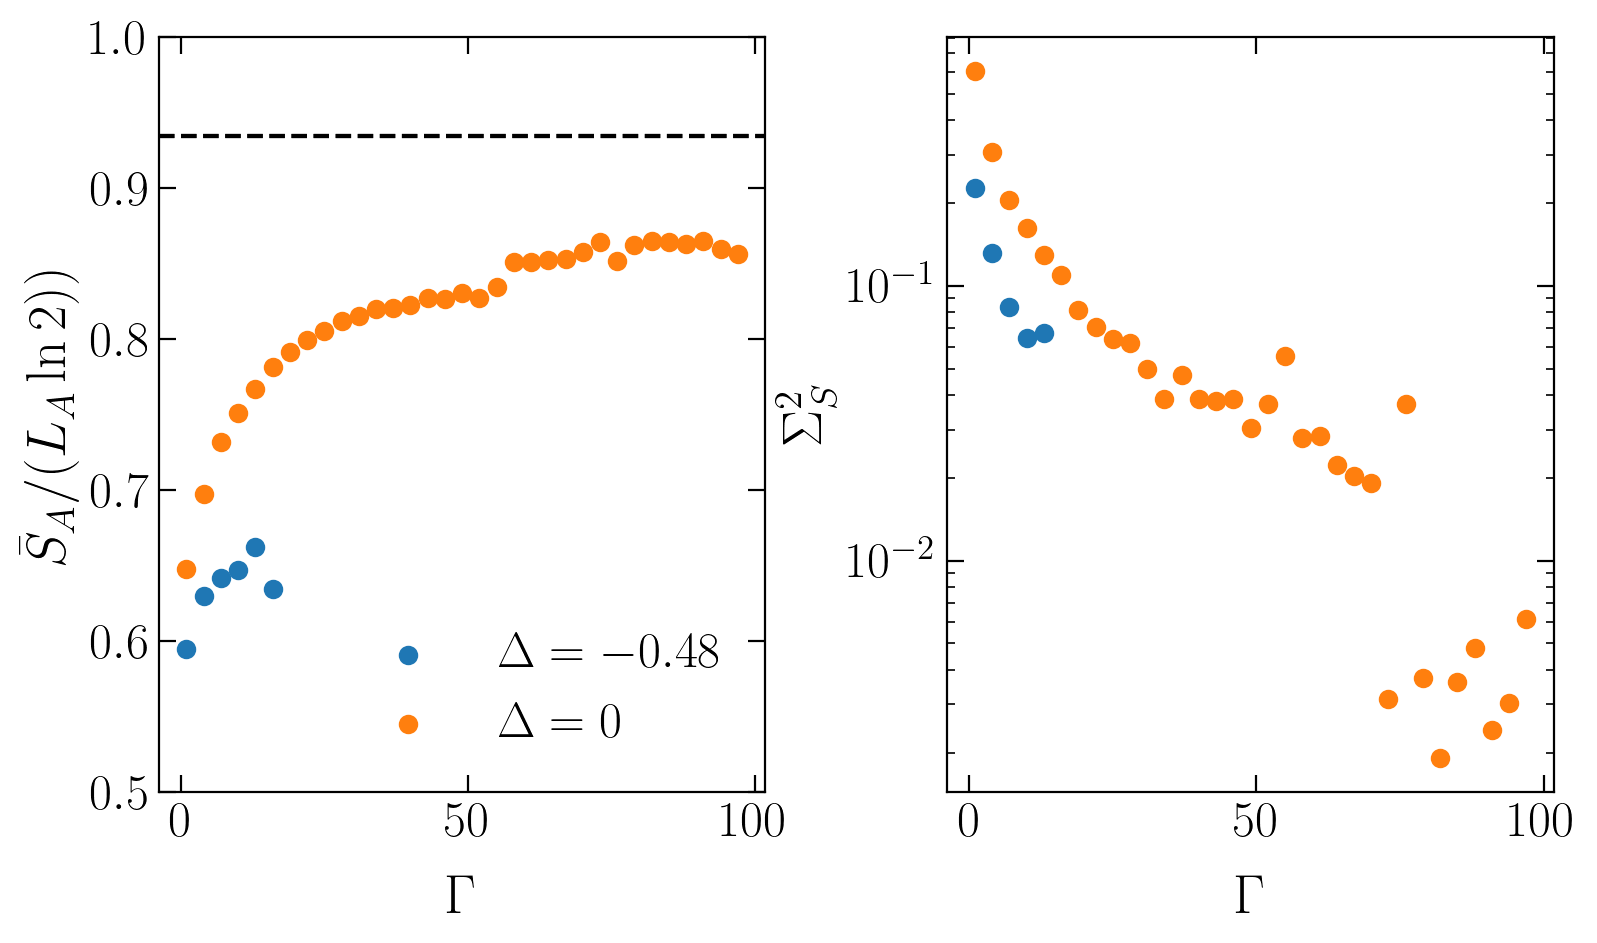

In [76]:

L=22
LA = L//2

J1=1.0
d1=0.0
e1=0.2

sizes_even = np.arange(12,19,2) if BOUNDARY_COND == 'OBC' else np.arange(14, 23, 2)
sizes_odd = np.arange(11,19,2) if BOUNDARY_COND == 'OBC' else np.arange(15, 23, 2)

def typical(data):
    data = np.array(data)
    return np.exp(np.mean(np.log(data)))

nu = 1.0

frac = lambda dim: dim+1

Gamma = np.arange(1, 100, 3)

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(9,5), dpi = 200)

for d1 in [-0.48, 0.0]:
    entropy = np.zeros((Gamma.size))
    entropy2 = np.zeros((Gamma.size))
    entropy_var = np.zeros((Gamma.size))
    real_sec, imag_sec = get_sectors(L, 0.0, 0.0)

    sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec
    for ii, G in enumerate(Gamma):
        dim_tot = 0
        Stot = []
        for [ks, ps, zxs, zzs] in sects:
            name = base_dir + 'Entropy/Eigenstate/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs) + ".hdf5"
            if exists(name):
                with h5py.File(name, "r") as file:
                    try:
                        energies = np.array(file.get('energies')[0])
                        dim = energies.size

                        _, indices, counts = np.unique(np.round(energies, 14), return_index=True, return_counts=True)
                        non_deg_idx = []
                        for new_iii, idx in enumerate(indices):
                            if counts[new_iii] == G:
                                for _ in range(counts[new_iii]):
                                    non_deg_idx.append(idx)
                        if len(non_deg_idx) > 0:
                            entropies = np.array(file.get('entropy'))
                            if entropies.shape != ():
                                entropies = np.array(file.get('entropy'))[LA][non_deg_idx]
                                
                                dim_tot += dim if ks == 0 or (ks == L // 2 and L%2 == 0) else 2 * dim

                                num = frac(dim)

                                E_av = np.mean(energies)
                                index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                                
                                my_min = int(index_meanE - num / 2)
                                if my_min < 0: my_min = 0;  

                                my_max = int(index_meanE + num / 2) 
                                if my_max >= dim: my_max = dim

                                sample = entropies
                                if num < dim and my_min > 0 and my_max < dim:
                                    sample = entropies[my_min : my_max]
                                Stot = [*Stot, *sample] if ks == 0 or (ks == L // 2 and L%2==0) else [*Stot, *sample, *sample]
                                
                                entropy[ii] += dim * np.mean(sample) if ks == 0 or (ks == L // 2 and L%2==0) else 2 * dim * np.mean(sample)
                                entropy2[ii] += dim * np.mean(sample**2) if ks == 0 or (ks == L // 2 and L%2==0) else 2 * dim * np.mean(sample**2)
                        else:
                            print(G, "File corrupt, no entropies:", name)
                    except TypeError:
                        print(G, "File corrupt, no energies:", name)
            else:
                print("Not found:", name)
        if dim_tot != 2**L:
            print("waaaaaaa", dim_tot, 2**L)
        
        if dim_tot > 0: entropy[ii] /= dim_tot
        entropy_var[ii] = entropy2[ii] / dim_tot - (entropy[ii])**2
        
    axis[0].scatter(Gamma, entropy / (LA*np.log(2)), label=r"$\Delta=%g$"%d1)
    axis[0].axhline(y = page(LA, L-LA) / (LA * np.log(2)), color='k', ls='--')
    axis[1].scatter(Gamma, entropy_var)

fig_help.set_plot_elements(axis[0], xlabel=r"$\Gamma$", ylabel=r"$\bar S_A / (L_A\ln2))$", font_size=18, set_legend=True, ylim=(0.5,1.0))
fig_help.set_plot_elements(axis[1], xlabel=r"$\Gamma$", ylabel=r"$\Sigma_S^2$", font_size=18, set_legend=False, ylim=(0,None), yscale='log')

# axis[0].legend(frameon=0, fontsize=14, loc='upper left', ncol=4, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.03,1.2))#, title=r"$\Delta=0.2$", title_fontsize=16)

# ff = np.linspace(0, 0.5, 100)
# axis[1].plot(ff, (1./(L*np.log(2))**2 * (ff * L / 3 + 1/(6*L*ff)))**1.25, ls='--', color='black')

fig.subplots_adjust(wspace = 0.3, hspace=0.05)

In [161]:
Ls_e=[12, 14, 16, 18, 20]
Ls_o=[13, 15, 17, 19]
print("OBC even", [int(2**L / (8)) for L in Ls_e])
print("OBC odd", [int(2**L / (4)) for L in Ls_o])

Ls_e=[16, 18, 20, 22, 24]
Ls_o=[15, 17, 19, 21, 23]
print("PBC even real", [int(2**L / (8*L)) for L in Ls_e])
print("PBC odd real", [int(2**L / (4*L)) for L in Ls_o])

print("PBC even imag", [int(2**L / (4*L)) for L in Ls_e])
print("PBC odd imag", [int(2**L / (2*L)) for L in Ls_o])

OBC even [512, 2048, 8192, 32768, 131072]
OBC odd [2048, 8192, 32768, 131072]
PBC even real [512, 1820, 6553, 23831, 87381]
PBC odd real [546, 1927, 6898, 24966, 91180]
PBC even imag [1024, 3640, 13107, 47662, 174762]
PBC odd imag [1092, 3855, 13797, 49932, 182361]


waaaaaaa 2344.0 16384
waaaaaaa 8230.0 65536
Not found: ../results/symmetries/PBC/Entropy/Degeneracy/_L=18,J1=1,J2=1,d1=0.2,d2=0.2,e1=0.2,e2=0.2,hx=0,hz=0,k=9,p=-1,zx=-1,zz=1,edge=0.hdf5
Not found: ../results/symmetries/PBC/Entropy/Degeneracy/_L=18,J1=1,J2=1,d1=0.2,d2=0.2,e1=0.2,e2=0.2,hx=0,hz=0,k=9,p=-1,zx=1,zz=-1,edge=0.hdf5
Not found: ../results/symmetries/PBC/Entropy/Degeneracy/_L=18,J1=1,J2=1,d1=0.2,d2=0.2,e1=0.2,e2=0.2,hx=0,hz=0,k=9,p=-1,zx=1,zz=1,edge=0.hdf5
Not found: ../results/symmetries/PBC/Entropy/Degeneracy/_L=18,J1=1,J2=1,d1=0.2,d2=0.2,e1=0.2,e2=0.2,hx=0,hz=0,k=9,p=1,zx=-1,zz=-1,edge=0.hdf5
Not found: ../results/symmetries/PBC/Entropy/Degeneracy/_L=18,J1=1,J2=1,d1=0.2,d2=0.2,e1=0.2,e2=0.2,hx=0,hz=0,k=9,p=1,zx=-1,zz=1,edge=0.hdf5
Not found: ../results/symmetries/PBC/Entropy/Degeneracy/_L=18,J1=1,J2=1,d1=0.2,d2=0.2,e1=0.2,e2=0.2,hx=0,hz=0,k=9,p=1,zx=1,zz=-1,edge=0.hdf5
Not found: ../results/symmetries/PBC/Entropy/Degeneracy/_L=18,J1=1,J2=1,d1=0.2,d2=0.2,e1=0.2,e2=0.2,hx=0,hz

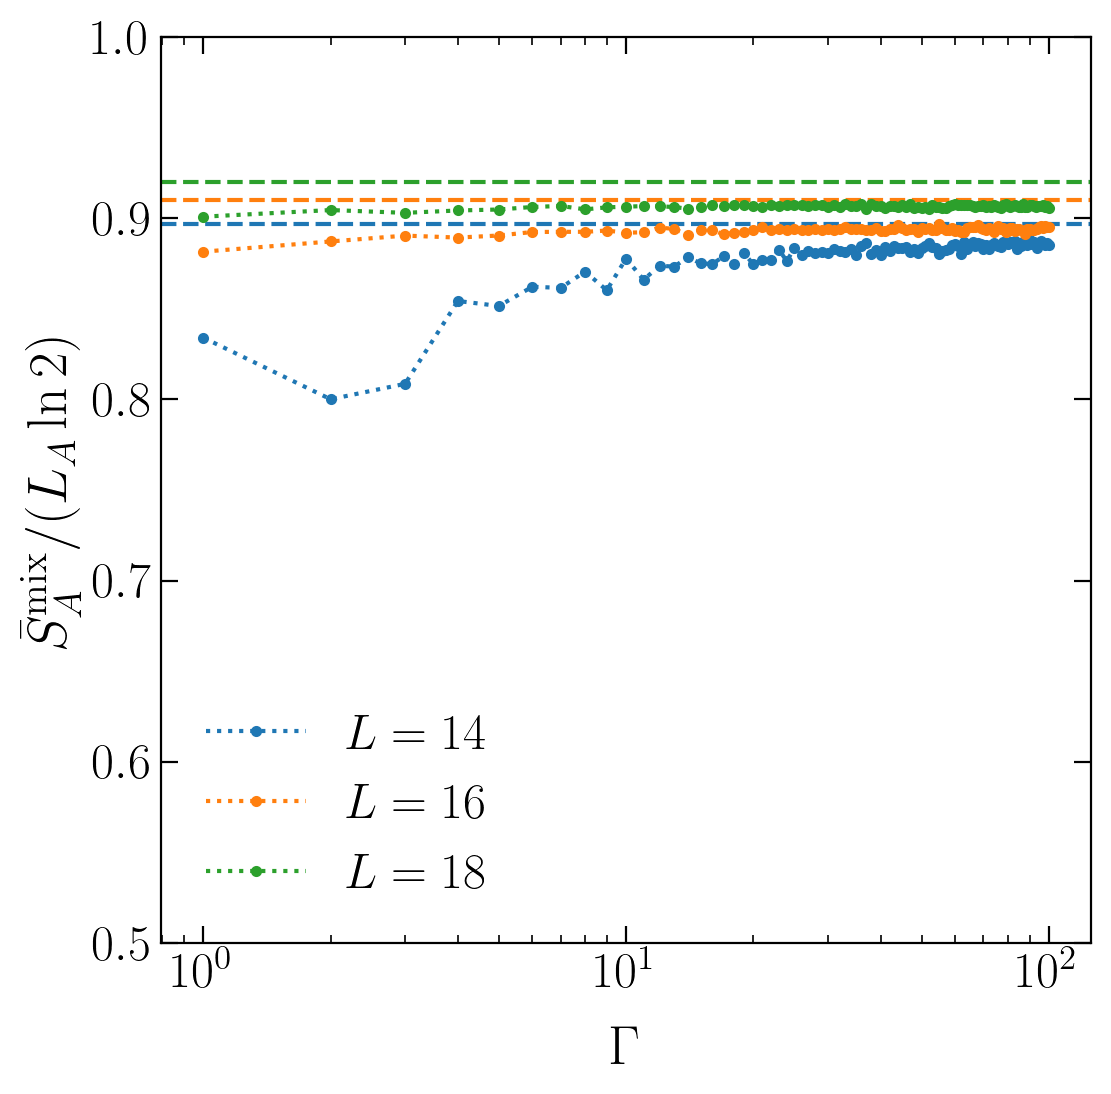

In [74]:

J1=1.0
d1=0.2
e1=0.2
J2=1.0
d2=0.2
e2=0.2

sizes = np.arange(14, 19, 2)

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(6,6), dpi = 200)

for ii, L in enumerate(sizes):
    LA = L // 2

    real_sec, imag_sec = get_sectors(L, 0, 0)

    sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec
    dim_tot = 0
    entropy = np.zeros((100))
    # sects = [[1, 1, 1, 1]]
    for [ks, ps, zxs, zzs] in real_sec:
        name = base_dir + 'Entropy/Degeneracy/' + info_sym(L=L, J1=J1, J2=J2, delta1=d1, delta2=d2, eta1=e1, eta2=e2, k=ks, p=ps, zx=zxs, zz=zzs) + ".hdf5"
        if exists(name):
            with h5py.File(name, "r") as file:
                entropies = np.array(file.get('entropy'))[LA]
                dim = np.array(file.get('dim')[0][0])
                dim_tot += dim if ks == 0 or ks == L / 2 else 2 * dim
                entropy += dim * entropies if ks == 0 or ks == L / 2 else 2 * dim * entropies

        else:
            print("Not found:", name)
    if dim_tot != 2**L:
        print("waaaaaaa", dim_tot, 2**L)
    
    if dim_tot > 0: 
        entropy /= dim_tot
    pl = axis.plot(np.arange(1, entropy.size+1), entropy / (LA * np.log(2)), marker='o', markersize=3, ls=':', label=r"$L=%d$"%L)
    axis.axhline(y = page(LA, L-LA) / (LA * np.log(2)), color=pl[0].get_color(), ls='--')

fig_help.set_plot_elements(axis, ylabel=r"$\bar{S}^{\rm mix}_A/(L_A\ln2)$", xlabel=r"$\Gamma$", font_size=18, set_legend=True, ylim=(0.5,1.0), xscale='log')

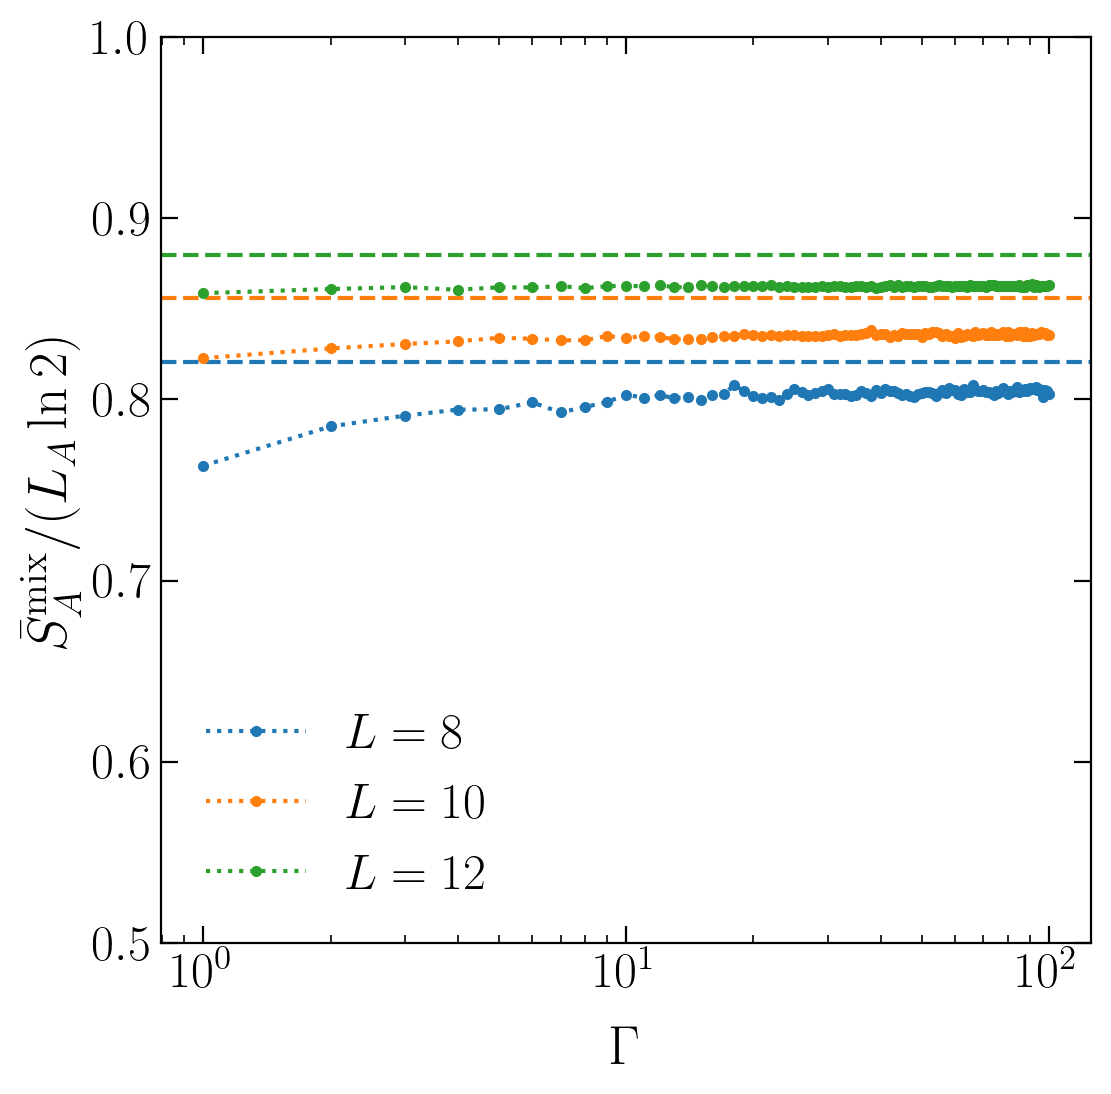

In [116]:

J1=1.0
d1=0.2
e1=0.2
J2=1.0
d2=0.2
e2=0.2

sizes = np.arange(8, 13, 2)

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(6,6), dpi = 200)

d1=0.55
e1=0.5
J2=0.0
d2=0.2
e2=0.0
hx=0.5
w=0.7

for ii, L in enumerate(sizes):
    LA = L // 2

    dim_tot=0
    name = '../../XYZ/results/disorder/PBC/Entropy/Degeneracy/' + info_dis(L=L, J1=J1, J2=J2, delta1=d1, delta2=d2, eta1=e1, eta2=e2,hx=hx,w=w) + "_jobid=0.hdf5"
    if exists(name):
        with h5py.File(name, "r") as file:
            entropy = np.array(file.get('entropy'))[LA]
            pl = axis.plot(np.arange(1, entropy.size+1), entropy / (LA * np.log(2)), marker='o', markersize=3, ls=':', label=r"$L=%d$"%L)
            axis.axhline(y = page(LA, L-LA) / (LA * np.log(2)), color=pl[0].get_color(), ls='--')
    else:
        print("Not found:", name)

fig_help.set_plot_elements(axis, ylabel=r"$\bar{S}^{\rm mix}_A/(L_A\ln2)$", xlabel=r"$\Gamma$", font_size=18, set_legend=True, ylim=(0.5,1.0), xscale='log')

## SUPERSYMMETRY - ED

3 2
4 1
5 4
6 2
7 9
8 9
9 23
10 24
11 63
12 88
13 190
14 288
15 612
16 1033
17 2056
18 3628


[Text(3, 0, '3'),
 Text(4, 0, '4'),
 Text(5, 0, '5'),
 Text(6, 0, '6'),
 Text(7, 0, '7'),
 Text(8, 0, '8'),
 Text(9, 0, '9'),
 Text(10, 0, '10'),
 Text(11, 0, '11'),
 Text(12, 0, '12'),
 Text(13, 0, '13'),
 Text(14, 0, '14'),
 Text(15, 0, '15'),
 Text(16, 0, '16'),
 Text(17, 0, '17'),
 Text(18, 0, '18')]

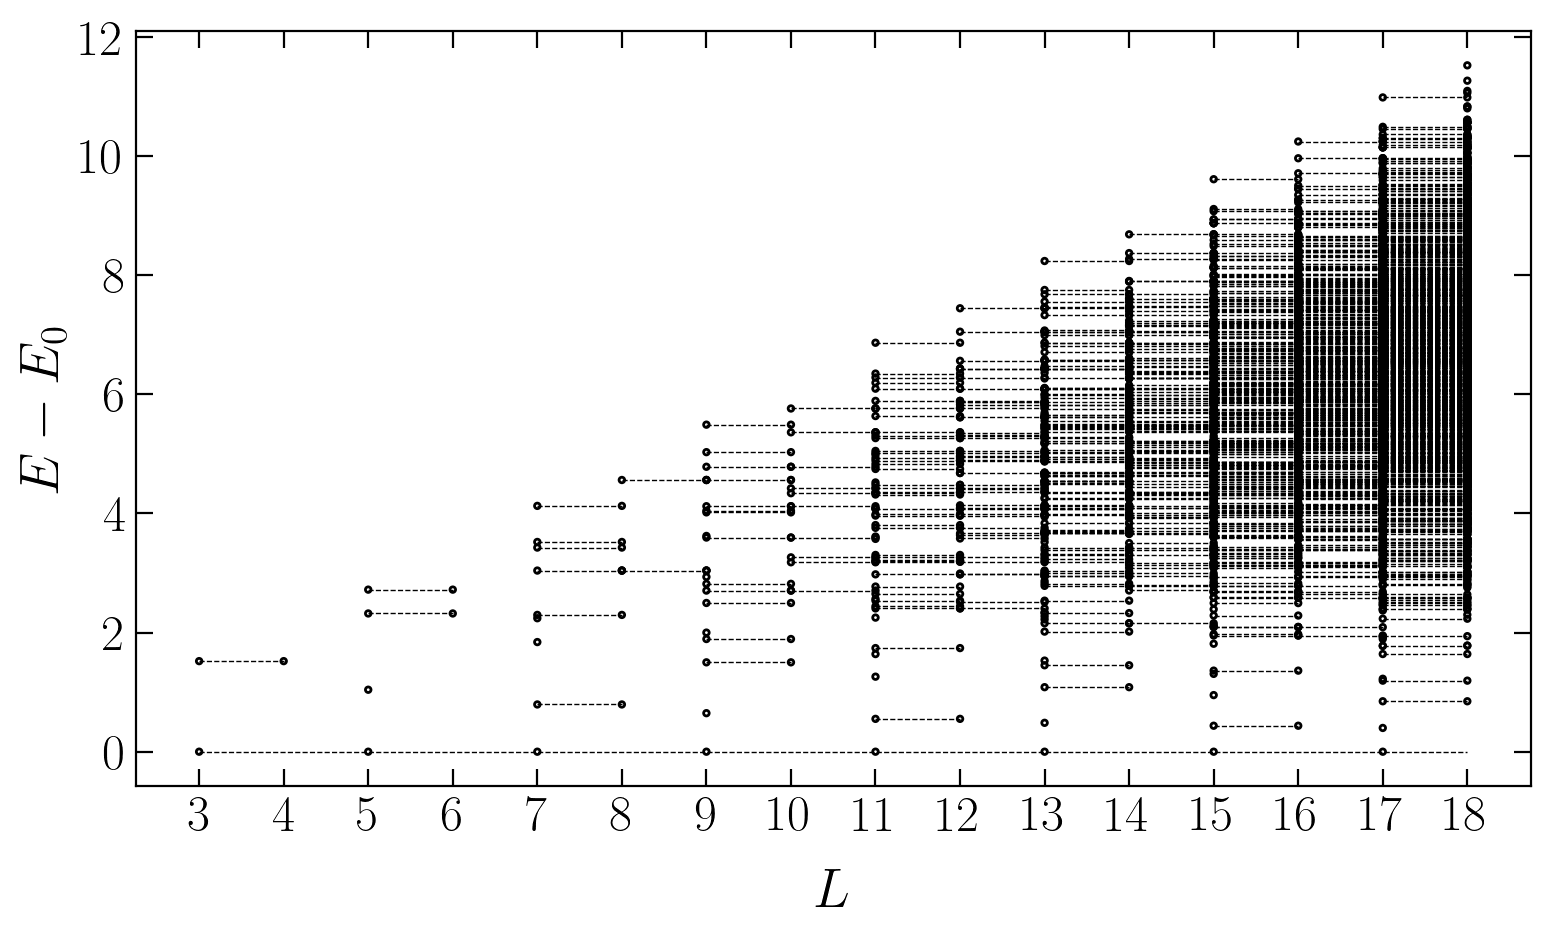

In [30]:
L = 6
J1 = 1.0
e1 = 0.2
d1 = -0.48

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(9,5), dpi = 200)
E_prev = np.ones((1))
dim = 0
ps = 1
zzs = 1
zzsss = [1, 1, -1]
for L in np.arange(3, 19):
    ks = 0 if L % 2 else L // 2
    zzs = zzsss[L % 3]# 1 if L % 2 else -1

    zx = 1
    name = base_dir + 'DIAGONALIZATION/' + info_sym(L, J1, 0, d1, 0, e1, 0, 0, 0, ks, ps, zxs, zzs, 0) + ".hdf5"
    # print(name)
    # if not exists(name): name = base_dir + 'Entropy/Eigenstate/' + info_sym(L, J1, 0, d1, 0, e1, 0, 0, 0, ks, ps, zxs, zzs, edge) + ".hdf5"

    if L % 2 == 0:
        ps *= 1

    if exists(name):
        with h5py.File(name, "r") as file:
            E = np.round(np.array(file.get('energies'))[0], 12)
            print(L, E.size)
            if L == 15:
                dim = E.size
            axis.scatter(L * np.ones(E.shape), E, color='k', facecolor='None', s=4)
            
            degenerate = np.intersect1d(E, E_prev)
            # print(degenerate)
            for En in degenerate:
                axis.plot([L-1, L], [En, En], c='k', lw=0.5, ls='--')
            E_prev = E
    else:
        print(name)

axis.plot([3, 18], [0, 0], c='k', lw=0.5, ls='--')

fig_help.set_plot_elements(axis, ylabel=r"$E-E_0$", xlabel=r"$L$", font_size=18, set_legend=False, ylim=(0,None))
xticks = np.arange(3, 19)
xticklabels = ["%g"%x for x in xticks]
axis.set_xticks(xticks)
axis.set_xticklabels(xticklabels)
# plt.savefig("PLOTS/Susy_multiplets.pdf", bbox_inches = 'tight', pad_inches=0.02)
# plt.savefig("PLOTS/Susy_multiplets.png", bbox_inches = 'tight', pad_inches=0.02)

In [ ]:
L = 6
J1 = 1.0
e1 = 0.2
d1 = -0.48

for L in np.arange(16, 20):
    ks = 0 if L % 2 else L // 2
    zzs = 1 if L % 2 else -1
    ps = 1
    zx = 1
    E1 = []
    E2 = []
    name = base_dir + 'DIAGONALIZATION/' + info_sym(L, J1, 0, d1, 0, e1, 0, 0, 0, ks, ps, zxs, zzs, edge) + ".hdf5"
    if exists(name):
        with h5py.File(name, "r") as file:
            E1 = np.round(np.array(file.get('energies'))[0], 14)
        
    name = base_dir + 'Entropy/Eigenstate/' + info_sym(L, J1, 0, d1, 0, e1, 0, 0, 0, ks, ps, zxs, zzs, edge) + ".hdf5"
    if exists(name):
        with h5py.File(name, "r") as file:
            E2 = np.round(np.array(file.get('energies'))[0], 14)

    if any(np.abs(E2 - E1) > 0):
           print(E1)
           print(E2)

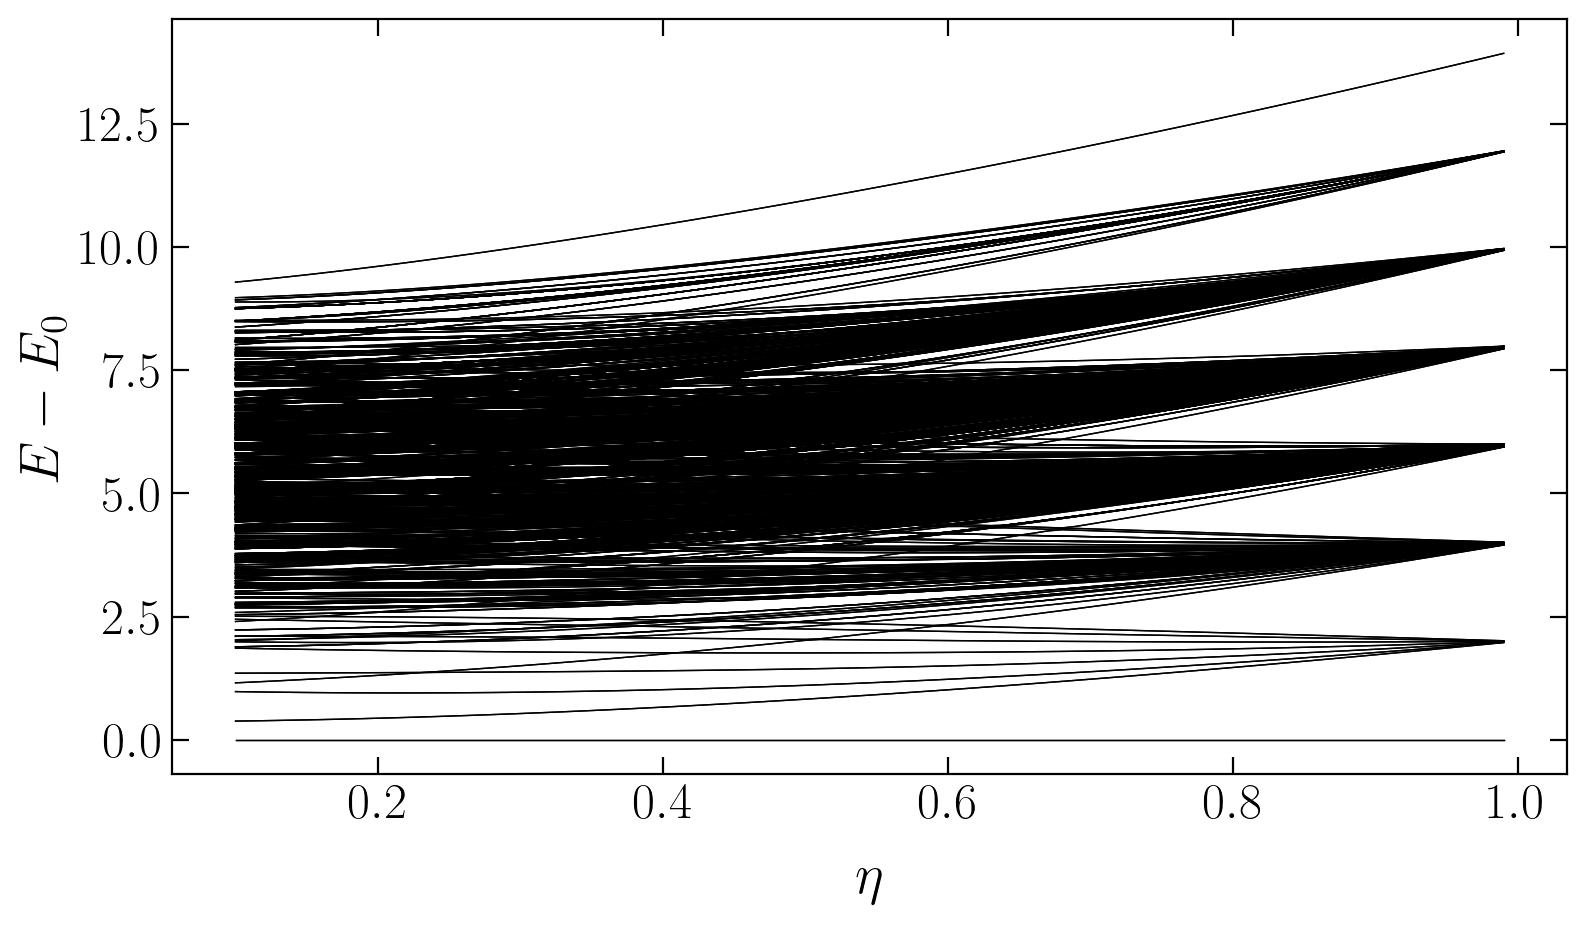

In [177]:
L = 15
J1 = 1.0
e1 = 0.2
d1 = -0.48

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(9,5), dpi = 200)
E_prev = np.ones((1))
ks = 0 if L % 2 else L // 2
zzs = 1
ps = 1
zx = 1
etas = np.linspace(0.1, 0.99, 90)

energies = np.zeros((dim, etas.size))
for ii, e1 in enumerate(etas):
    d1 = (e1 * e1 - 1) / 2
    name = base_dir + 'DIAGONALIZATION/' + info_sym(L, J1, 0, d1, 0, e1, 0, 0, 0, ks, ps, zxs, zzs, edge) + ".hdf5"
    if exists(name):
        with h5py.File(name, "r") as file:
            E = np.round(np.array(file.get('energies'))[0], 12)
            energies[:, ii] = E
    else:
        print(name)

for ii in range(0, dim):
    axis.plot(etas, energies[ii, :], c='k', lw=0.5)
fig_help.set_plot_elements(axis, ylabel=r"$E-E_0$", xlabel=r"$\eta$", font_size=18, set_legend=False, ylim=(0,None))

plt.savefig("PLOTS/Susy_energy_evolution.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig("PLOTS/Susy_energy_evolution.png", bbox_inches = 'tight', pad_inches=0.02)

## DOS & ENERGY STATISTICS

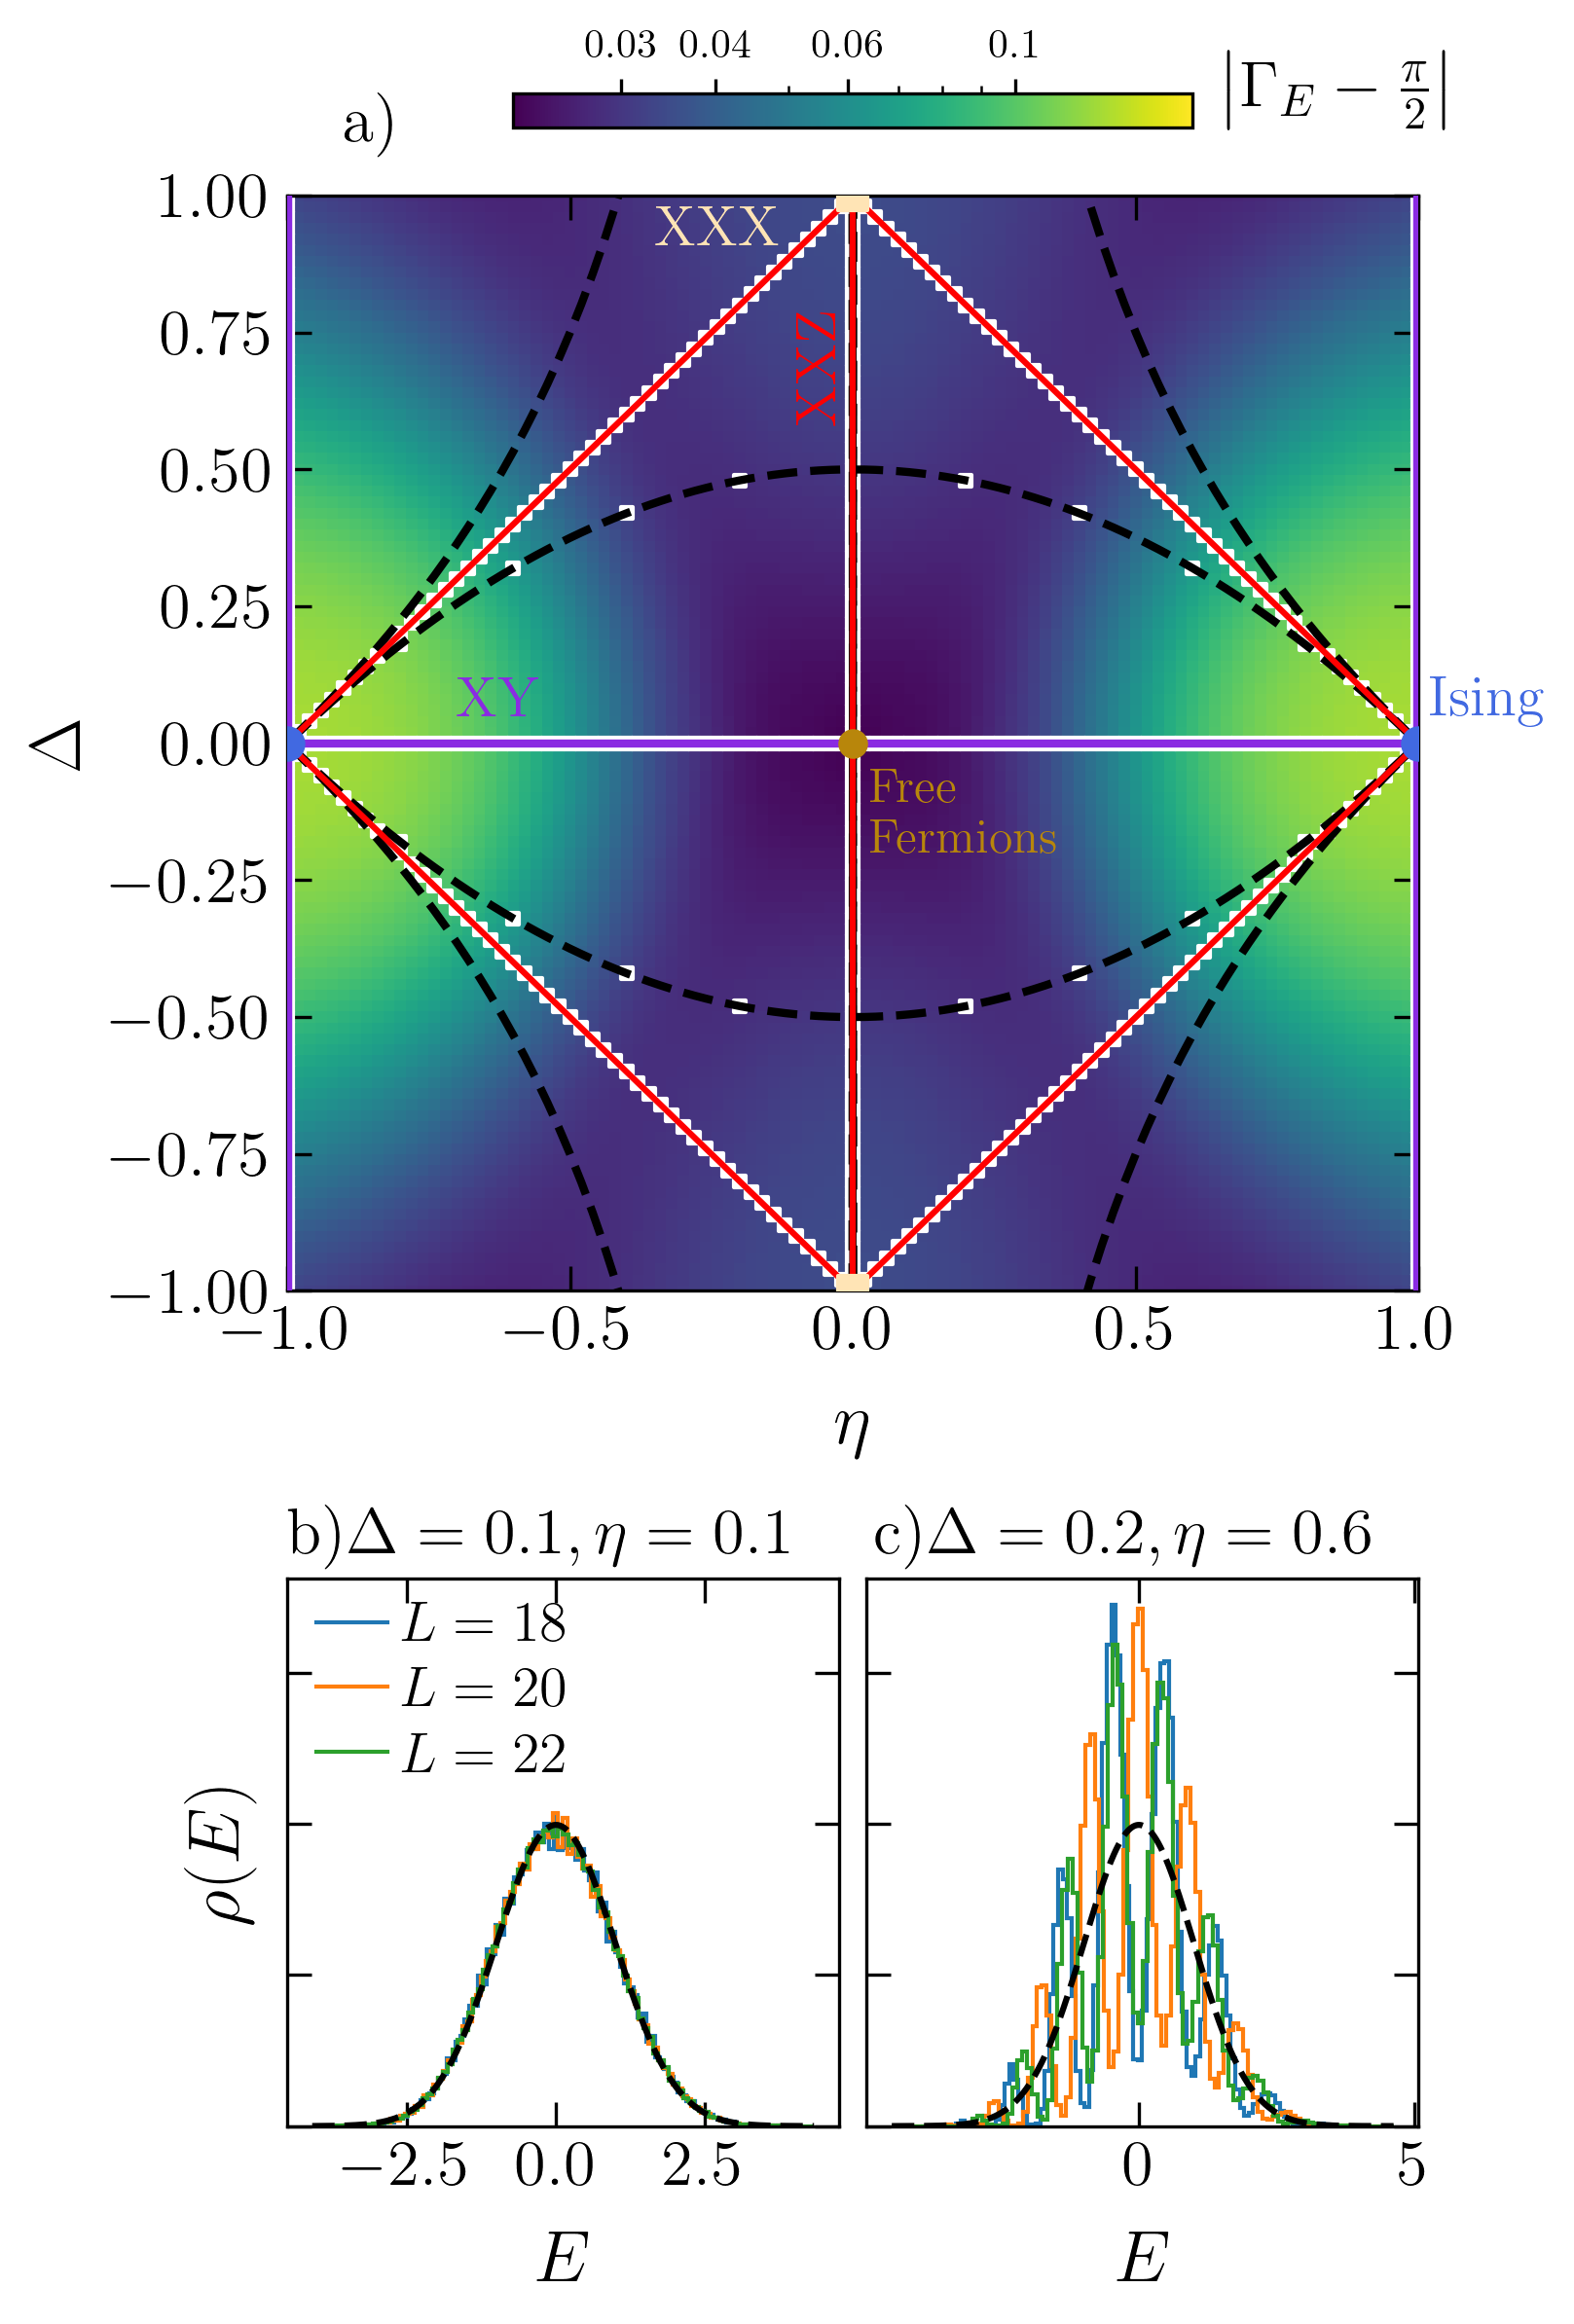

In [28]:

L=18
nu = 1.0

LA = L // 2



fig = plt.figure(figsize=(5,10), dpi = 300)
gs = GridSpec(nrows=2, ncols=2, height_ratios=[5, 2])
axis = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1], sharey=ax1)

df = pd.read_csv(f'./RESULTS/nu={nu}/param_sweep_L={L}.csv') 

deltas = np.linspace(-1.0, 1.0, 101)
etas = np.linspace(-1.0, 1.0, 101)

X, Y = np.meshgrid(etas, deltas)


gauss = np.abs(np.pi / 2 - np.array(df[df['d1'] < 0 ]['gaussianity1']))
ymax = 1.05 * np.max(gauss)

gauss = np.abs(np.pi / 2- np.array(df['gaussianity1'][df['d1'] <= max(deltas) ]).reshape((deltas.size, etas.size)))
p2 = axis.pcolormesh(X, Y, gauss, shading='nearest', norm=matplotlib.colors.LogNorm(vmin=np.min(gauss), vmax=ymax), zorder=0)
cbar = fig.colorbar(p2, ax = axis, location='top', shrink=0.6)
cbar.set_ticks([0.03, 0.04, 0.06, 0.1])
cbar.set_ticklabels([r"$0.03$", r"$0.04$", r"$0.06$", r"$0.1$"])
# cbar.set_label(r"$\left|\Gamma_E-\frac{\pi}{2}\right|$", loc='right')
# axis.contour(X, Y, gauss, linestyles=':', colors='cyan')

del_idx, eta_idx = np.where(gauss < 1e-3)

degeneracy = np.array(df['degeneracy'][df['d1'] <= max(deltas) ]).reshape((deltas.size, etas.size))

deg_del_idx, deg_eta_idx = np.where(degeneracy > 0)


def delta1(eta):
    return (1 - eta**2) / 2

def delta2(eta):
    return (1 - eta**2) / (2 * eta)

new_etas = np.concatenate( (np.linspace(-1, 0, 51)[:-1], np.linspace(0, 1, 51)[1:]) )

for ax in [axis]:
    ax.scatter(etas[deg_eta_idx], deltas[deg_del_idx], marker='s', color='white', s=8, zorder=1)

    ax.plot(new_etas, delta1(new_etas), c='black', ls='--', lw=2, zorder=2)
    ax.plot(new_etas, -delta1(new_etas), c='black', ls='--', lw=2, zorder=2)
    ax.plot(new_etas, delta2(new_etas), c='black', ls='--', lw=2, zorder=2)
    ax.plot(new_etas, -delta2(new_etas), c='black', ls='--', lw=2, zorder=2)
    
    ax.plot(new_etas, 1+(new_etas), c='red', ls='-', lw=1.5, zorder=3)
    ax.plot(new_etas, 1-(new_etas), c='red', ls='-', lw=1.5, zorder=3)
    ax.plot(new_etas, -1-(new_etas), c='red', ls='-', lw=1.5, zorder=3)
    ax.plot(new_etas, -1+(new_etas), c='red', ls='-', lw=1.5, zorder=3)
    ax.plot(0*etas, etas, c='red', ls='-', lw=1.5)

    ax.plot(etas, 0*etas, c='blueviolet', ls='-', lw=2, zorder=4)
    ax.plot(-np.ones(etas.shape), etas, c='blueviolet', ls='-', lw=2.5, zorder=4)
    ax.plot(np.ones(etas.shape), etas, c='blueviolet', ls='-', lw=2.5, zorder=4)


    ax.scatter(0.0, 1.0, c='moccasin', marker='s', s=50, zorder=4)
    ax.scatter(0.0, -1.0, c='moccasin', marker='s', s=50, zorder=4)
    ax.scatter(0.0, 0.0, c='darkgoldenrod', s=40, zorder=5)
    ax.scatter(-1.0, 0.0, c='royalblue', s=60, zorder=6)
    ax.scatter(1.0, 0.0, c='royalblue', s=60, zorder=6)


    fig_help.set_plot_elements(ax, ylabel=r"$\Delta$", xlabel=r"$\eta$", font_size=16, set_legend=False, xlim=(-1.0, 1.0), ylim=(-1.0, 1.0))

axis.annotate("XXX", xy=(-0.35, 0.91), fontsize=14, rotation=0, color='moccasin')
axis.annotate("XXZ", xy=(-0.1, 0.6), fontsize=14, rotation=90, color='red')
axis.annotate("XY", xy=(-0.7, 0.05), fontsize=14, rotation=0, color='blueviolet')
axis.annotate("Free\n Fermions", xy=(0.03, -0.2), fontsize=12, rotation=0, color='darkgoldenrod')
axis.annotate("Ising", xy=(1.02, 0.05), fontsize=14, rotation=0, color='royalblue', annotation_clip=False)

# axis.annotate("XYY", xy=(-0.55, 0.55), fontsize=14, rotation=45, color='cyan')
# axis.annotate("XYX", xy=(0.45, 0.45), fontsize=14, rotation=-45, color='blueviolet')

sizes = [18, 20, 22]
def add_dos(axis, d1, e1):
    x_min = 0
    x_max = 10
    for L in sizes:
        real_sec, imag_sec = get_sectors(L, 0.0, 0.0)

        sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec
        LA = L // 2
        dim_tot = 0
        E = []
        S = []
        for [ks, ps, zxs, zzs] in sects:
            name = base_dir + 'Entropy/Eigenstate/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs) + ".hdf5"
            if exists(name):
                with h5py.File(name, "r") as file:
                    energies = np.array(file.get('energies')[0]) - L * (3+e1**2)/8
                    energies /= np.std(energies)
                    E = [*E, *energies] if ks == 0 or ks == L / 2 else [*E, *energies, *energies]

            #print(L, e1, ks, ps, zxs, zzs)
        hist, edges = np.histogram(E, bins=100, normed=True)
        axis.stairs(hist, edges, label=r"$L=%d$"%L)
        x_min = min(edges)
        x_max = max(edges)
        # axis.set_ylim(0, 0.45)
    aa = np.linspace(x_min, x_max, 1000)
    axis.plot(aa, 1 / np.sqrt(2*np.pi) * np.exp(-aa**2 / 2), ls='--', c='k')

axis.annotate(r"$\left|\Gamma_E-\frac{\pi}{2}\right|$", fontsize=16, xy=(0.83, 1.08), xycoords='axes fraction')
add_dos(axis=ax1, d1=0.1, e1=0.1)
ax2.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
ax2.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))

add_dos(axis=ax2, d1=0.2, e1=0.6)

fig_help.set_plot_elements(ax1, ylabel=r"$\rho(E)$", xlabel=r"$E$", font_size=16, set_legend=False)
ax1.legend(frameon=0, fontsize=14, loc='upper left', ncol=1, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.04,1.05), labelspacing=0.25)

fig_help.set_plot_elements(ax2, ylabel="", xlabel=r"$E$", font_size=16, set_legend=False)

# axis.scatter(0.1, 0.1, marker='o', color='k', s=8)
# axis.annotate("", xy=(0.1, 0.1), xytext=(1.2, 0.65), arrowprops=dict(arrowstyle="<-", lw=2, color='k'))

# axis.scatter(0.6, 0.2, marker='o', color='k', s=8)
# axis.annotate("", xy=(0.6, 0.2), xytext=(1.1, -0.4), arrowprops=dict(arrowstyle="<-", lw=2, color='k'))
axis.annotate("a)", fontsize=16, xy=(0.05, 1.05), xycoords='axes fraction')
axis.annotate("b)$\Delta=0.1,\eta=0.1$", fontsize=16, xy=(0.0, -0.24), xycoords='axes fraction')
axis.annotate("c)$\Delta=0.2,\eta=0.6$", fontsize=16, xy=(0.52, -0.24), xycoords='axes fraction')

fig.subplots_adjust(wspace = 0.05, hspace=0.3)
plt.savefig("PLOTS/Gaussianity_map.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig("PLOTS/Gaussianity_map.png", bbox_inches = 'tight', pad_inches=0.02)

## ENTROPY

No supersymmetric point at eta=0.495
No supersymmetric point at eta=-0.495
No supersymmetric point at eta=-4.95
[  0  25  75 100]
No U(1) point at eta=-1.1
No supersymmetric point at eta=-2.4
[  0  26  74 100]
No U(1) point at eta=-1.2
No supersymmetric point at eta=0.455
No supersymmetric point at eta=-0.455
No supersymmetric point at eta=-1.516667
[  0  27  73 100]
No U(1) point at eta=-1.3
No supersymmetric point at eta=-1.05
[  0  29  71 100]
No U(1) point at eta=-1.4
No supersymmetric point at eta=0.255
No supersymmetric point at eta=0.364286
No supersymmetric point at eta=-0.255
No supersymmetric point at eta=-0.364286
[32 37 63 68]
No U(1) point at eta=-1.7


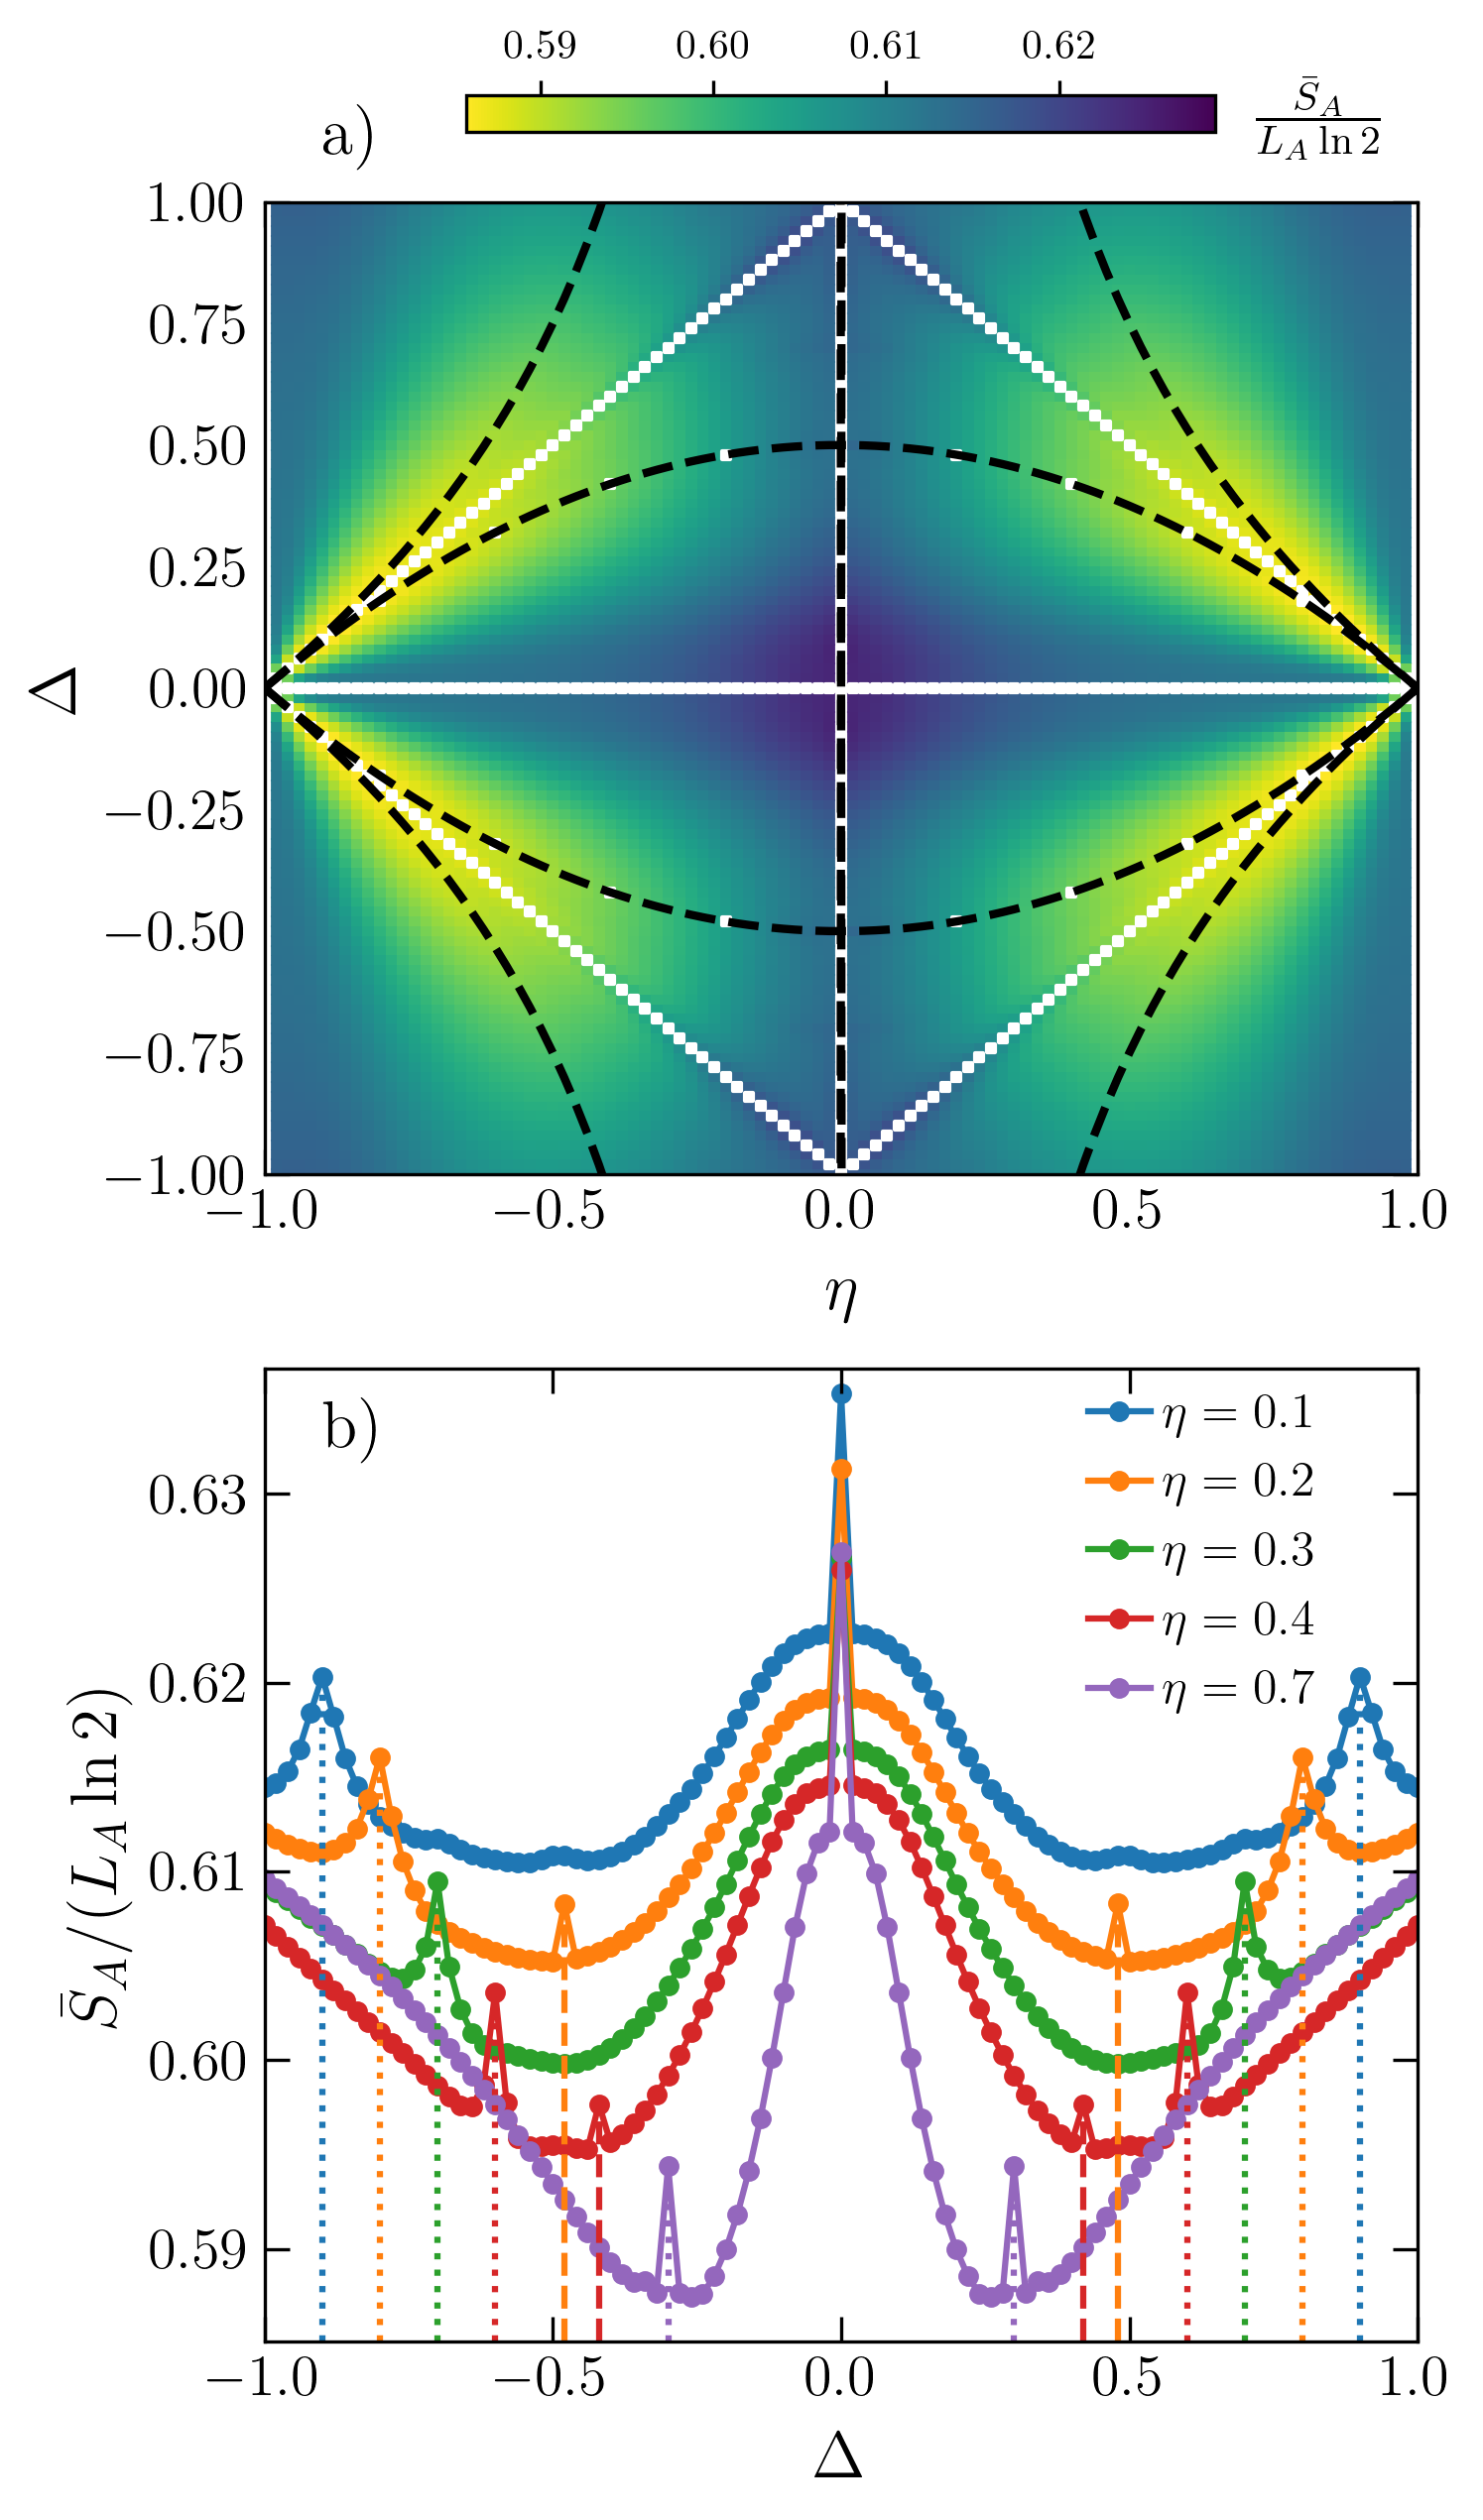

In [7]:

L=18
nu = 1.0

LA = L // 2

plt.rcParams['image.cmap'] = 'viridis_r'
fig = plt.figure(figsize=(5,10), dpi = 300)
# gs = GridSpec(nrows=2, ncols=1)
# axis = [fig.add_subplot(gs[1]) ,fig.add_subplot(gs[0])]
fig.subplots_adjust(hspace=0.0)
outer = GridSpec(2, 1, height_ratios = [1, 20]) 
# gs = fig.add_gridspec(ncols=1, nrows=3, hspace=0.3, height_ratios=[1, 20, 20])
gs1 = grid.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])
gs = grid.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[1], hspace = 0.2)
# a = gs.subplots()

a = fig.add_subplot(gs1[0])
axis = [fig.add_subplot(gs[1]) ,fig.add_subplot(gs[0])]
a.axis('off')
# a[1].axis('off')
# axis = [a[2], a[1]]

df = pd.read_csv(f'./RESULTS/nu={nu}/param_sweep_L={L}.csv') 

S = np.array(df[ np.round(df['d1'],3) > 0.0 ][f'S_LA={LA}'][df['e1'] > 0 ]) / (LA * np.log(2))

ymax = 0.99*np.max(S)
ymin = np.min(S)

deltas = np.round(np.linspace(-1.0, 1.0, 101), 2)
etas = np.linspace(-1.0, 1.0, 101)

X, Y = np.meshgrid(etas, deltas)

S = np.array(df[f'S_LA={LA}'][df['d1'] <= max(deltas) ]).reshape((deltas.size, etas.size)) / (LA * np.log(2))
p1 = axis[1].pcolormesh(X, Y, S, shading='nearest', vmin=ymin, vmax=ymax)
fig.colorbar(p1, ax = a, location='top', fraction = 0.35 * S.shape[1] / float(S.shape[0]))
# fig.colorbar(p1, ax = a[0], location='top')

axis[1].annotate(r"$\frac{\bar S_A}{L_A\ln2}$", fontsize=14, xy=(0.86, 1.07), xycoords='axes fraction')

degeneracy = np.array(df['degeneracy'][df['d1'] <= max(deltas) ]).reshape((deltas.size, etas.size))

deg_del_idx, deg_eta_idx = np.where(degeneracy > 0)


def delta1(eta):
    return (1 - eta**2) / 2

def delta2(eta):
    return (1 - eta**2) / (2 * eta)

new_etas = np.concatenate( (np.linspace(-1, 0, 51)[:-1], np.linspace(0, 1, 51)[1:]) )

for ax in [axis[1]]:
    ax.scatter(etas[deg_eta_idx], deltas[deg_del_idx], marker='s', color='white', s=4)

    ax.plot(new_etas, delta1(new_etas), c='black', ls='--', lw=2)
    ax.plot(new_etas, -delta1(new_etas), c='black', ls='--', lw=2)
    
    ax.plot(new_etas, delta2(new_etas), c='black', ls='--', lw=2)
    ax.plot(new_etas, -delta2(new_etas), c='black', ls='--', lw=2)
    
    # ax.plot(new_etas, 1-(new_etas), c='black', ls=':', lw=2)
    # ax.plot(new_etas, 1+(new_etas), c='black', ls=':', lw=2)

    fig_help.set_plot_elements(ax, ylabel=r"$\Delta$", xlabel=r"$\eta$", font_size=14, set_legend=False, xlim=(-1.0, 1.0), ylim=(-1.0, 1.0))


def merge(ydata, indices):
    res = []
    res = [*res, *ydata[indices[0] : indices[1] ], *ydata[indices[2] : indices[3] ]]
    return res

ymax = 1.012*ymax
ymin = 0.999*ymin
for eta in [0.1, 0.2, 0.3, 0.4, 0.7]:
    entropy = np.array(df[ np.round(df['e1'],3) == eta ][df['d1'] <= max(deltas) ][f'S_LA={LA}'])
    # ydata = entropy - 0.5573*LA*np.log(2)
    ydata = entropy / (LA * np.log(2))
    pl = axis[0].plot(deltas, ydata, marker='o', label=f"$\eta={eta}$", markersize=4, zorder=0)

    supersym_point = [delta1(eta), delta2(eta), -delta1(eta), -delta2(eta)]
    indices = []
    for sp in supersym_point:
        id = min(range(len(deltas)), key=lambda i: abs(deltas[i] - sp))
        indices.append(id)
        if sp < 1.0:
            try:
                sp = np.round(sp, 6)
                idx = list(deltas).index(sp)
                axis[0].axvline(x=sp, ls='--', color=pl[0].get_color(), ymax = (ydata[idx] - ymin) / (ymax - ymin), zorder=2)
            except ValueError:
                print(f"No supersymmetric point at eta={sp}")
    
    indices = np.sort(np.array(indices))
    print(indices)
    # axis[0].scatter(merge(deltas, indices), merge(ydata, indices), marker='o', s=25, color=pl[0].get_color(), edgecolor='black', zorder=3)
    
    
    U1_point = [1-eta, 1+eta, -1-eta, -1+eta]
    for sp in U1_point:
        if sp < 1.0:
            try:
                sp = np.round(sp, 6)
                idx = list(deltas).index(sp)
                axis[0].axvline(x=sp, ls=':', color=pl[0].get_color(), ymax = (ydata[idx] - ymin) / (ymax - ymin), zorder=1)
            except ValueError:
                print(f"No U(1) point at eta={sp}")

fig_help.set_plot_elements(axis[0], ylabel="\ ", xlabel=r"$\Delta$", font_size=14, set_legend=False, xlim=(-1.0, max(deltas)), ylim=(ymin, ymax))

axis[0].legend(frameon=0, fontsize=12, loc='upper right', ncol=1, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.95, 1.02))
axis[0].set_ylabel(r"$\bar S_A/(L_A\ln2)$", fontsize=16)

axis[1].annotate("a)", fontsize=16, xy=(0.05, 1.05), xycoords='axes fraction')
axis[0].annotate("b)", fontsize=16, xy=(0.05, 0.92), xycoords='axes fraction')
# fig.subplots_adjust(wspace = 0.3, hspace=0.2)
plt.savefig("PLOTS/Entropy_map.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig("PLOTS/Entropy_map.png", bbox_inches = 'tight', pad_inches=0.02)

plt.rcParams['image.cmap'] = 'viridis_r'

No supersymmetric point at eta=0.495
No supersymmetric point at eta=-0.495
No supersymmetric point at eta=-4.95
[  0  25  75 100]
No U(1) point at eta=-1.1
No supersymmetric point at eta=-2.4
[  0  26  74 100]
No U(1) point at eta=-1.2
No supersymmetric point at eta=0.455
No supersymmetric point at eta=-0.455
No supersymmetric point at eta=-1.516667
[  0  27  73 100]
No U(1) point at eta=-1.3
No supersymmetric point at eta=-1.05
[  0  29  71 100]
No U(1) point at eta=-1.4
No supersymmetric point at eta=0.255
No supersymmetric point at eta=0.364286
No supersymmetric point at eta=-0.255
No supersymmetric point at eta=-0.364286
[32 37 63 68]
No U(1) point at eta=-1.7


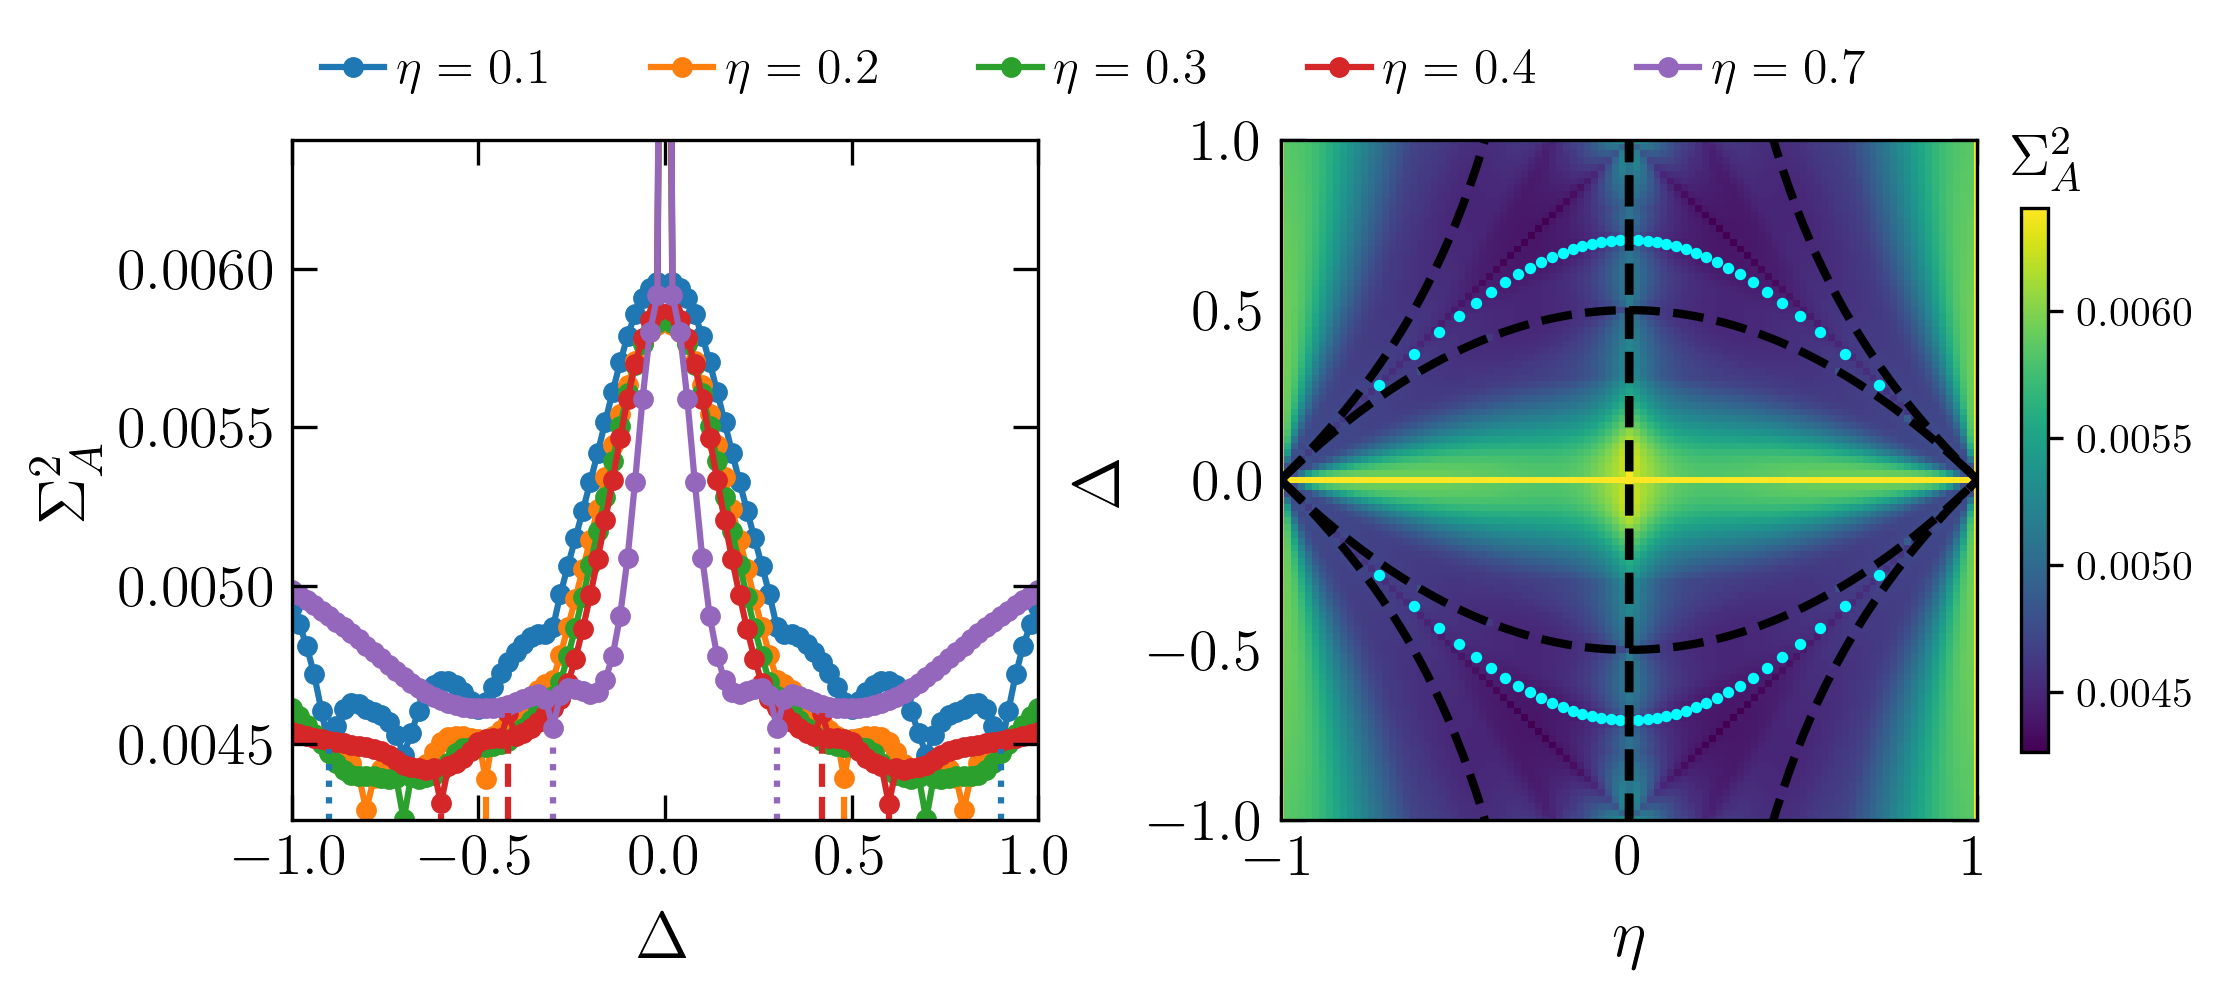

In [7]:

L=18
nu = 1.0

LA = L // 2

fig = plt.figure(figsize=(8,3), dpi = 300)
gs = GridSpec(nrows=1, ncols=2, width_ratios=[6, 7])
axis = [fig.add_subplot(gs[0]) ,fig.add_subplot(gs[1])]

df = pd.read_csv(f'./RESULTS/nu={nu}/param_sweep_L={L}.csv') 

S = np.array(df[ np.abs(np.round(df['d1'],2)) > 0 ][ np.abs(np.round(df['e1'],2)) < 1 ][f'S2_LA={LA}']) / (LA*np.log(2))**2

ymax = 1.0 * np.max(S)
ymin = 0.9999 * np.min(S)

deltas = np.round(np.linspace(-1.0, 1.0, 101), 2)
etas = np.linspace(-1.0, 1.0, 101)

X, Y = np.meshgrid(etas, deltas)

p1 = axis[1].pcolormesh(X, Y, np.array(df[f'S2_LA={LA}'][df['d1'] <= max(deltas) ]).reshape((deltas.size, etas.size)) / (LA*np.log(2))**2, shading='nearest', vmin=np.min(S), vmax=ymax)
fig.colorbar(p1, ax = axis[1], shrink=0.8)

axis[1].annotate(r"$\Sigma^2_A$", fontsize=14, xy=(1.05, 0.95), xycoords='axes fraction')

degeneracy = np.array(df['degeneracy'][df['d1'] <= max(deltas) ]).reshape((deltas.size, etas.size))

deg_del_idx, deg_eta_idx = np.where(degeneracy > 0)


def delta1(eta):
    return (1 - eta**2) / 2

def delta2(eta):
    return (1 - eta**2) / (2 * eta)

new_etas = np.concatenate( (np.linspace(-1, 0, 51)[:-1], np.linspace(0, 1, 51)[1:]) )

for ax in [axis[1]]:
    # ax.scatter(etas[deg_eta_idx], deltas[deg_del_idx], marker='s', color='white', s=2)

    ax.plot(new_etas, delta1(new_etas), c='black', ls='--', lw=2)
    ax.plot(new_etas, -delta1(new_etas), c='black', ls='--', lw=2)
    
    ax.plot(new_etas, delta2(new_etas), c='black', ls='--', lw=2)
    ax.plot(new_etas, -delta2(new_etas), c='black', ls='--', lw=2)
    
    # ax.plot(new_etas, 1-(new_etas), c='black', ls=':', lw=2)
    # ax.plot(new_etas, 1+(new_etas), c='black', ls=':', lw=2)

    fig_help.set_plot_elements(ax, ylabel=r"$\Delta$", xlabel=r"$\eta$", font_size=14, set_legend=False, xlim=(-1.0, 1.0), ylim=(-1.0, 1.0))


    for k in np.linspace(0, 1, 20):
        eta = k * (np.sqrt(2) / (np.sqrt(1-k) + np.sqrt(1+k)) )**2
        delta = np.sqrt(2 * (1-k**2) ) / (np.sqrt(1-k) + np.sqrt(1+k))
        ax.scatter(eta, delta, marker='o', s=3, color='cyan')
        ax.scatter(-eta, delta, marker='o', s=3, color='cyan')
        ax.scatter(eta, -delta, marker='o', s=3, color='cyan')
        ax.scatter(-eta, -delta, marker='o', s=3, color='cyan')
        
def merge(ydata, indices):
    res = []
    res = [*res, *ydata[indices[0] : indices[1] ], *ydata[indices[2] : indices[3] ]]
    return res

for eta in [0.1, 0.2, 0.3, 0.4, 0.7]:
    entropy = np.array(df[ np.round(df['e1'],3) == eta ][df['d1'] <= max(deltas) ][f'S2_LA={LA}'])
    ydata = entropy / (LA*np.log(2))**2
    pl = axis[0].plot(deltas, ydata, marker='o', label=f"$\eta={eta}$", markersize=4, zorder=0)

    supersym_point = [delta1(eta), delta2(eta), -delta1(eta), -delta2(eta)]
    indices = []
    for sp in supersym_point:
        id = min(range(len(deltas)), key=lambda i: abs(deltas[i] - sp))
        indices.append(id)
        if sp < 1.0:
            try:
                sp = np.round(sp, 6)
                idx = list(deltas).index(sp)
                axis[0].axvline(x=sp, ls='--', color=pl[0].get_color(), ymax = (ydata[idx] - ymin) / (ymax - ymin), zorder=2)
            except ValueError:
                print(f"No supersymmetric point at eta={sp}")
    
    indices = np.sort(np.array(indices))
    print(indices)
    # axis[0].scatter(merge(deltas, indices), merge(ydata, indices), marker='o', s=25, color=pl[0].get_color(), edgecolor='black', zorder=3)
    
    
    U1_point = [1-eta, 1+eta, -1-eta, -1+eta]
    for sp in U1_point:
        if sp < 1.0:
            try:
                sp = np.round(sp, 6)
                idx = list(deltas).index(sp)
                axis[0].axvline(x=sp, ls=':', color=pl[0].get_color(), ymax = (ydata[idx] - ymin) / (ymax - ymin), zorder=1)
            except ValueError:
                print(f"No U(1) point at eta={sp}")

fig_help.set_plot_elements(axis[0], ylabel="\ ", xlabel=r"$\Delta$", font_size=14, set_legend=False, xlim=(-1.0, max(deltas)), ylim=(ymin, ymax))

axis[0].legend(frameon=0, fontsize=12, loc='upper left', ncol=5, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02, 1.2))
axis[0].set_ylabel(r"$\Sigma^2_A$", fontsize=16)


fig.subplots_adjust(wspace = 0.3, hspace=0.25)
plt.savefig("PLOTS/Entropy_var_map.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig("PLOTS/Entropy_var_map.png", bbox_inches = 'tight', pad_inches=0.02)

In [530]:
sum = 0
cpus=[1, 1, 1, 4, 4, 16, 16, 32, 32]
for L in np.arange(14, 23, 2):
    sum += (2 * 8 + (L // 2 - 2) * 4) * cpus[L-14]

for L in np.arange(15, 23, 2):
    sum += (4 + (L // 2 - 1) * 2)*cpus[L-14]

print(sum)

3796


No handles with labels found to put in legend.


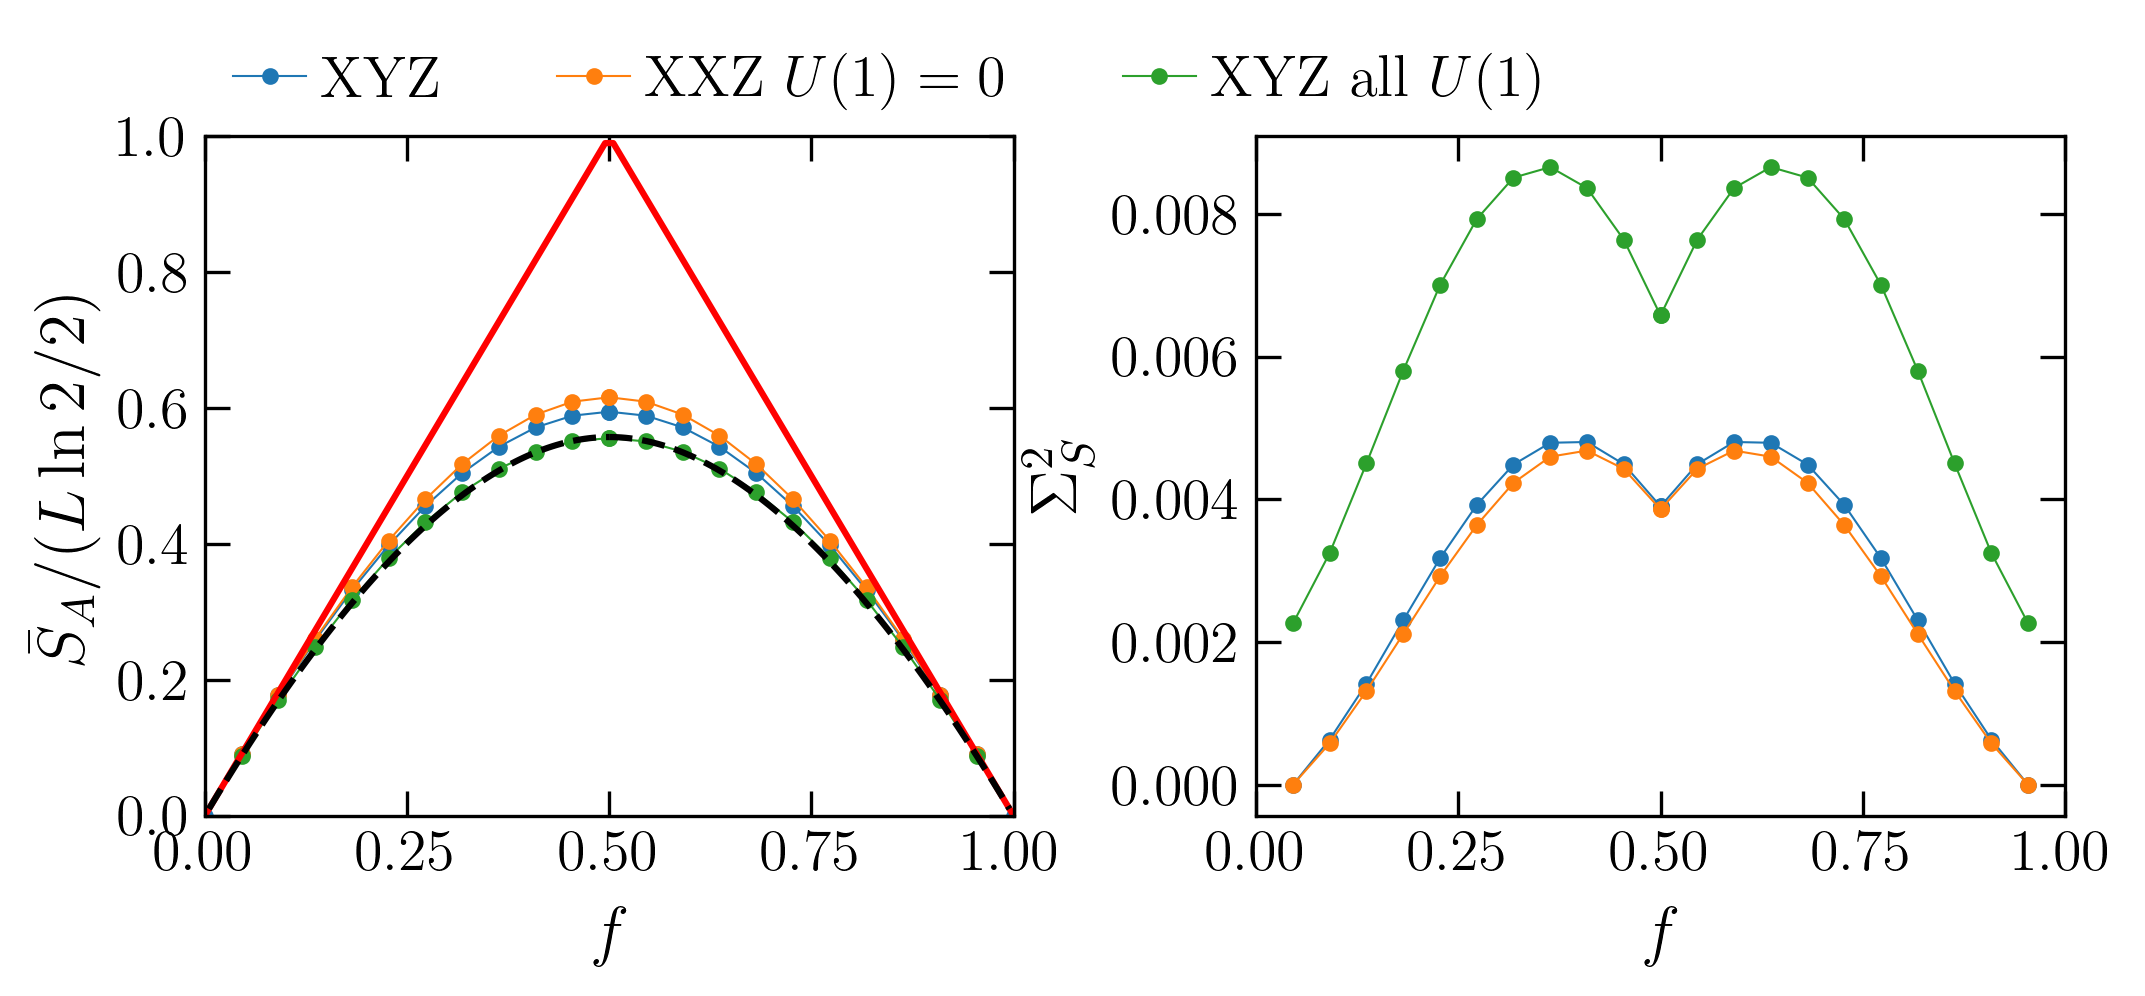

In [619]:

markers = itertools.cycle(markers_ls)

L=22
Lxxz=22

nu=1.0

J1=1.0
d1=0.48
e1=0.2

fig = plt.figure(figsize=(8,3), dpi = 300)
gs = GridSpec(nrows=1, ncols=2, width_ratios=[1, 1])
axis = [fig.add_subplot(gs[0]) ,fig.add_subplot(gs[1])]

def plot_arc(L, choice = 0, key_label = ""):
    # LAA = np.arange(0, L//2+1, 1)
    
    Lx = Lxxz
    if choice == 0:
        Lx = L   
        df = pd.read_csv(f'./RESULTS/nu={nu}/Entropy/_L={L},eta={e1},delta={d1}.csv')
    elif choice == 1:   
        df = pd.read_csv(f'./RESULTS_XXZ/nu={nu}/L={Lxxz}/_U1=%d,delta=0.55.csv'%(Lxxz//2))
    else:               
        df = pd.read_csv(f'./RESULTS_XXZ/nu={nu}/L={Lxxz}/_all_U1,delta=0.55.csv')
    
    LAA = np.array(df['subsizes'])
    entropy = np.array(df['<S>']) / (Lx//2 * np.log(2))
    entropy_var = np.array(df['<S^2>']) / (LAA * np.log(2))**2

    sc = axis[0].plot(LAA / Lx, entropy, label=key_label, marker='o', markersize=3, lw=0.5)
    
    axis[0].plot(np.ones(LAA.shape) - LAA / Lx, entropy, color=sc[0].get_color(), marker='o', markersize=3, lw=0.5)
    
    sc = axis[1].plot(LAA / Lx, entropy_var, marker='o', markersize=3, lw=0.5)
    axis[1].plot(np.ones(LAA.shape) - LAA / Lx, entropy_var, color=sc[0].get_color(), marker='o', markersize=3, lw=0.5)


plot_arc(L=L, choice = 0, key_label="XYZ")
plot_arc(L=L, choice = 1, key_label="XXZ $U(1)=0$")
plot_arc(L=L, choice = 2, key_label="XYZ all $U(1)$")

ff = np.linspace(0, 1.0, 100)
axis[0].plot(ff, 1 - 2*np.abs(0.5 - ff), ls='-', color='red')

ff = np.linspace(0., 0.5, 100)
axis[0].plot(ff, 2 * ff * (1 - (1 + (1-ff)/ff * np.log(1-ff) ) / np.log(2)), ls='--', color='black')
ff = np.linspace(.5, 1., 100)
axis[0].plot(ff, 2 * (1-ff) * (1 - (1 + ff/(1-ff) * np.log(ff) ) / np.log(2)), ls='--', color='black')    


fig_help.set_plot_elements(axis[0], ylabel=r"$\bar S_A / (L\ln2/2)$", xlabel="$f$", font_size=14, set_legend=True, xlim=(0,1), ylim=(0,1))
axis[0].legend(frameon=0, fontsize=14, loc='upper left', ncol=4, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.03,1.2))#, title=r"$\Delta=0.2$", title_fontsize=16)

# ff = np.linspace(0, 0.5, 100)
# axis[1].plot(ff, (1./(L*np.log(2))**2 * (ff * L / 3 + 1/(6*L*ff)))**1.25, ls='--', color='black')


fig_help.set_plot_elements(axis[1], ylabel=r"$\Sigma^2_S$", xlabel="$f$", font_size=14, set_legend=True)

fig.subplots_adjust(wspace = 0.3, hspace=0.05)

(-1.0, 1.0)

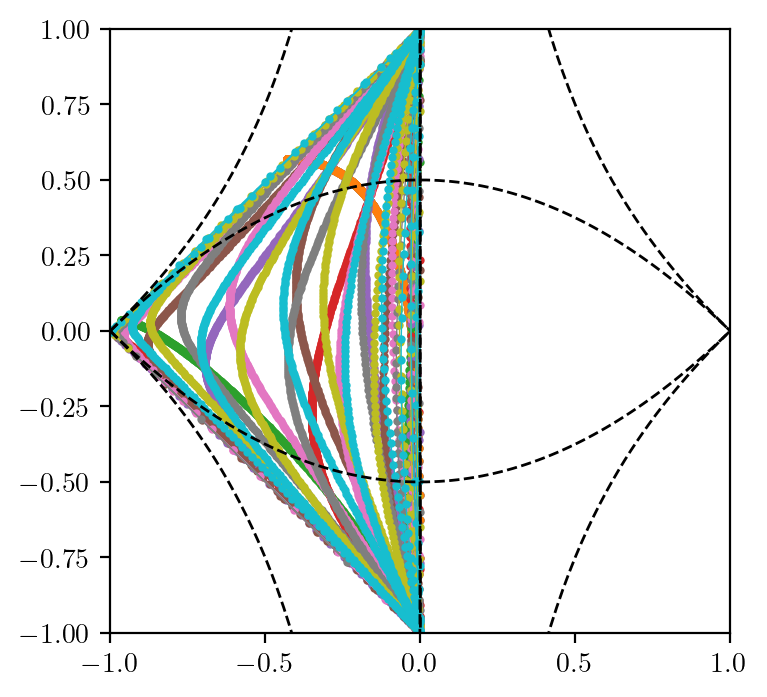

In [63]:
from scipy.special import ellipj
from scipy.special import ellipkm1
from sympy import solve

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(4,4), dpi = 200)

N=2
m1=3
m2=2

for m1 in np.arange(0, 10):
    k = np.linspace(0, 1, 1000)
    g = (2 * m1 - m2 / 2) / N * ellipkm1(k)

    sn, cn, dn, _ = ellipj(g, k)
    eta = -k * sn**2
    delta = cn * dn
    axis.plot(eta, delta, lw=0.5, marker='o', markersize=2)
# axis.scatter(-eta, delta, marker='o', s=3, color='black')
# axis.scatter(eta, -delta, marker='o', s=3, color='black')
# axis.scatter(-eta, -delta, marker='o', s=3, color='black')

    


axis.plot(new_etas, delta1(new_etas), c='black', ls='--', lw=1)
axis.plot(new_etas, -delta1(new_etas), c='black', ls='--', lw=1)
axis.plot(new_etas, delta2(new_etas), c='black', ls='--', lw=1)
axis.plot(new_etas, -delta2(new_etas), c='black', ls='--', lw=1)

# axis.scatter(etas[deg_eta_idx], deltas[deg_del_idx], marker='o', color='red', facecolor='None', s=1)

# for i in range(len(deg_eta_idx)):
#     print(etas[deg_eta_idx[i]], deltas[deg_del_idx[i]])

axis.set_xlim(-1,1)
axis.set_ylim(-1,1)

## EIGENSTATES

0.2
0.4
0.6
0.8
1.0


(-10.0, 10.0)

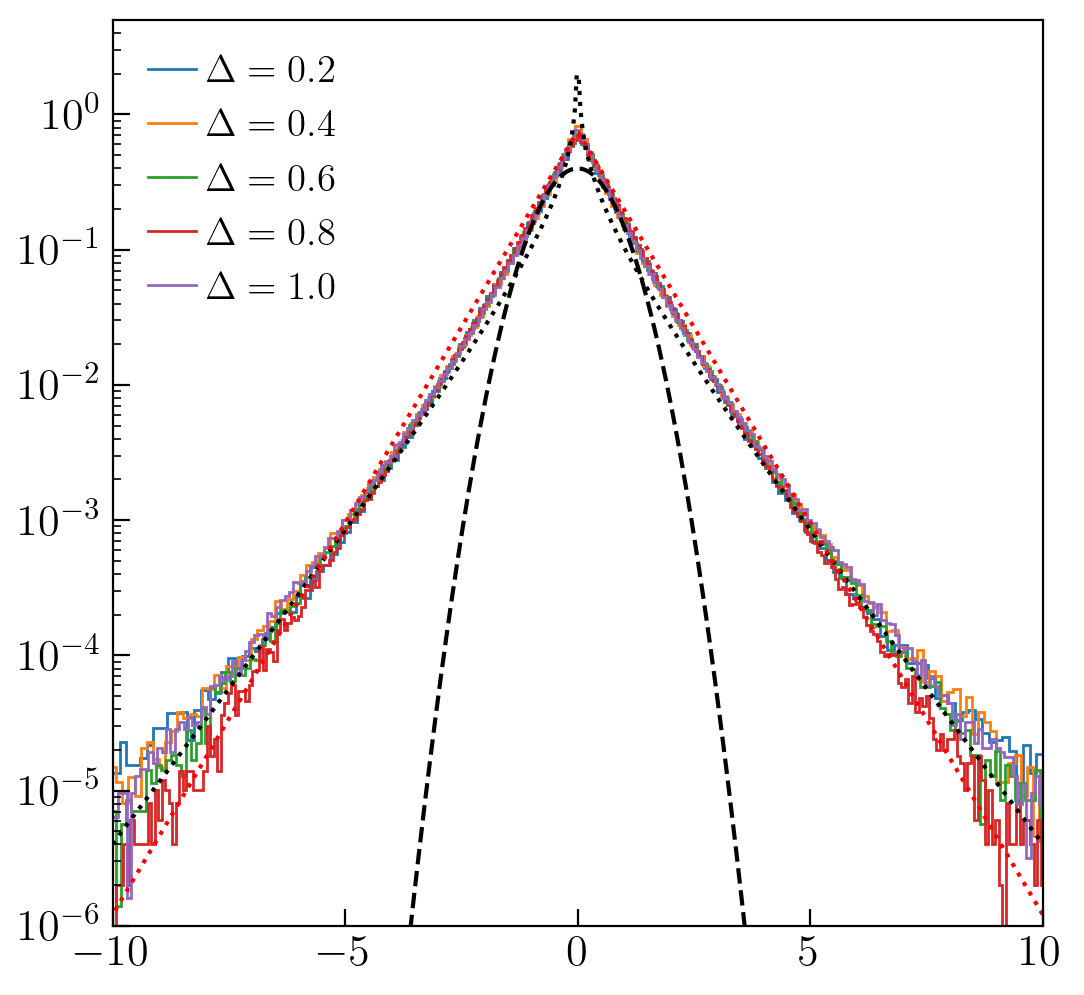

In [61]:

markers = itertools.cycle(markers_ls)

L=16

J1=1.0
d1=0.5
e1=0.2

J2=0.0
d2=0.0
e2=0.0

hx=0.0
hz=0.0

k=0
p=1
zx=1
zz=1

f = 0.5
LA = int(L*f)
LA = 2

frac = lambda dim: 0.25 * dim

sizes = [16]

deltas = np.linspace(0.02, 1.00, 50)
etas = np.linspace(0.02, 1.00, 50)

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(6,6), dpi = 200, sharey=True)


real_sec, _ = get_sectors(L, hx, hz)

pred = L * (np.log(2) / 2 - 41 / 288)

dim_tot = 2**L
colors_ls_cyc = itertools.cycle(colors_ls)
for ii, d1 in enumerate([0.2, 0.4, 0.6, 0.8, 1.0]):
    entropy = []
    energy = []
    states = []
    for [ks, ps, zxs, zzs] in real_sec:
        name = dir + 'Entropy/Eigenstate/' + info_sym(L, J1, J2, d1, d2, e1, e2, hx, hz, ks, ps, zxs, zzs) + ".hdf5"
        if exists(name):
            with h5py.File(name, "r") as file:
                energies = np.array(file.get('energies')[0])
                entropies = np.array(file.get('entropy'))[LA]
                dim = energies.size
                V = np.array(file.get('eigenvectors'))
                V = V.flatten()
                
                V = (V / np.std(V))
                energies /= np.std(energies)
                
                energy = [*energy, *energies]
                entropy = [*entropy, *entropies]
                states = [*states, *V]
        else:
            print(name)
    print(d1)
    bins, hist = np.histogram(states, bins=300, normed=True)
    axis.stairs(bins, hist, label=f"$\Delta={d1}$", color = next(colors_ls_cyc))


legend = axis.legend(frameon=False, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.00,1.00))
en = np.linspace(-20, 20, 1000)
axis.plot(en, 1/np.sqrt(2*np.pi) * np.exp(-en**2), ls='--', color='black')
axis.plot(en, 1/np.sqrt(np.abs(4*np.pi*en)) * np.exp(-np.abs(en)), ls=':', color='black')
axis.plot(en, 3/4*np.exp(-4/3 * np.abs(en)), ls=':', color='red')

axis.tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
axis.tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)
#axis.set_xscale('log');
axis.set_yscale('log')
axis.set_ylim(1e-6, 5e0)
axis.set_xlim(-10, 10)

# SIZE SCALING

## DISTRIBUTIONS

In [ ]:

markers = itertools.cycle(markers_ls)

L=16

J1=1.0
d1=0.2
e1=0.3
J2=0.0
d2=0.0
e2=0.0

hx=0.0
hz=0.0

k=0
p=1
zx=1
zz=1

f = 0.5
LA = int(L*f)
LA = 2

frac = lambda dim: 2 * dim

sizes = [16]

deltas = np.linspace(0.02, 1.00, 50)
etas = np.linspace(0.02, 1.00, 50)

fig, axis = plt.subplots( nrows=3, ncols=3, figsize=(12,8), dpi = 200, sharey=True)
#axis = np.array(axis).flatten()

# deltas = [0.02, 0.1, 0.7]
# etas = [0.02, 0.5]
print(deltas)



pred = L * (np.log(2) / 2 - 41 / 288)

dim_tot = 2**L

#print(subsystem_frac)
for jj, e1 in enumerate([0.2, 0.4, 0.6]):
    colors_ls_cyc = itertools.cycle(colors_ls)
    for ii, d1 in enumerate([0.2]):
        
        for L in np.arange(14,22,1):
            
            entropy_ave = np.zeros((L//2 + L%2))
            subsystem_frac = np.linspace(0, 0.5, L // 2 + L%2)
            real_sec, imag_sec = get_sectors(L, hx, hz)

            for LA in range(L//2 + L%2):
                dim_tot = 0
                for [ks, ps, zxs, zzs] in real_sec + imag_sec:
                    name = base_dir + 'Entropy/Eigenstate/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs) + ".hdf5"
                    if exists(name):
                        with h5py.File(name, "r") as file:
                            energies = np.array(file.get('energies')[0])
                            entropies = np.array(file.get('entropy'))[LA]
                            dim = energies.size
                            dim_tot += dim if ks == 0 or ks == L / 2 else 2 * dim

                            num = frac(dim)

                            E_av = np.mean(energies)
                            index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                            
                            my_min = int(index_meanE - num / 2)
                            if my_min < 0: my_min = 0;  

                            my_max = int(index_meanE + num / 2) 
                            if my_max >= dim: my_max = dim

                            sample = entropies
                            if my_min > 0 and my_max < dim:
                                sample = entropies[my_min : my_max]
                            entropy_ave[LA] += dim * np.mean(sample) if ks == 0 or ks == L / 2 else 2 * dim * np.mean(sample)
                            #if LA < L//2: entropy_ave[L - LA] += dim * np.mean(sample) / 2**L
                    else:
                        print(name)
                if dim_tot != 2**L:
                    print("waaaaaaa", dim_tot, 2**L)
                
                entropy_ave[LA] /= dim_tot   
                
            axis[ii][jj].scatter(subsystem_frac, entropy_ave / (L/2*np.log(2) - 0.5), label=f"$L={L}$", color = next(colors_ls_cyc), s=20, facecolor='None')

        if ii == 0 and jj == 0:
            legend = axis[ii][jj].legend(frameon=False, fontsize=12, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.04,1.04))
            legend.set_title(f"$\eta={e1}$")
        
        axis[ii][jj].set_xlabel(r"$f$", fontsize=14)
        if jj % 2 == 0: axis[ii][jj].set_ylabel(r"$\bar{S}_f/(L/2\ln2)$", fontsize=14)
        
        ff = np.linspace(0, 0.5, 100)
        axis[ii][jj].plot(ff, 1 - 2*np.abs(0.5 - ff), ls='--', color='black')
        
        ff = np.linspace(0., 0.5, 100)
        axis[ii][jj].plot(ff, 2 * ff * (1 - (1 + (1-ff)/ff * np.log(1-ff) ) / np.log(2)), ls=':', color='black')
        
        #ff = np.linspace(.5, 1., 100)
        #axis[ii][jj].plot(ff, 2 * (1-ff) * (1 - (1 + ff/(1-ff) * np.log(ff) ) / np.log(2)), ls=':', color='black')
        
        axis[ii][jj].tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
        axis[ii][jj].tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)

fig.subplots_adjust(wspace = 0.02, hspace=0.02)

0 -1 -1 -1 1
0 -1 -1 1 1
0 -1 1 -1 1
0 -1 1 1 1
0 1 -1 -1 1
0 1 -1 1 1
0 1 1 -1 1
0 1 1 1 1
11 -1 -1 -1 1
11 -1 -1 1 1
11 -1 1 -1 1
11 -1 1 1 1
11 1 -1 -1 1
11 1 -1 1 1
11 1 1 -1 1
11 1 1 1 1
[[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
 [ 1  2  3  4  5

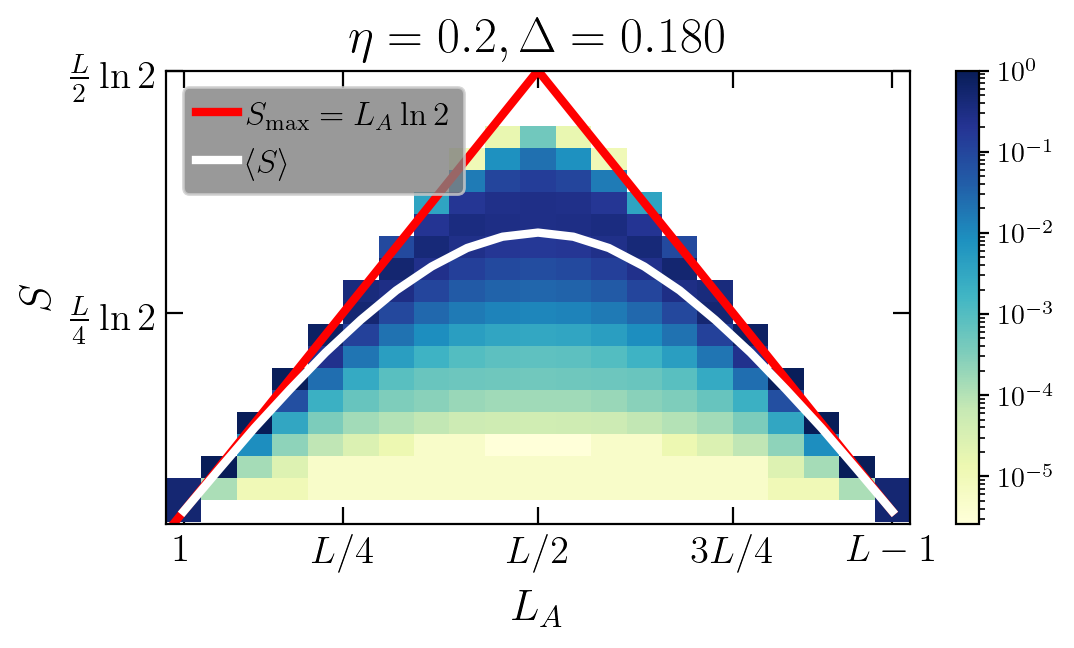

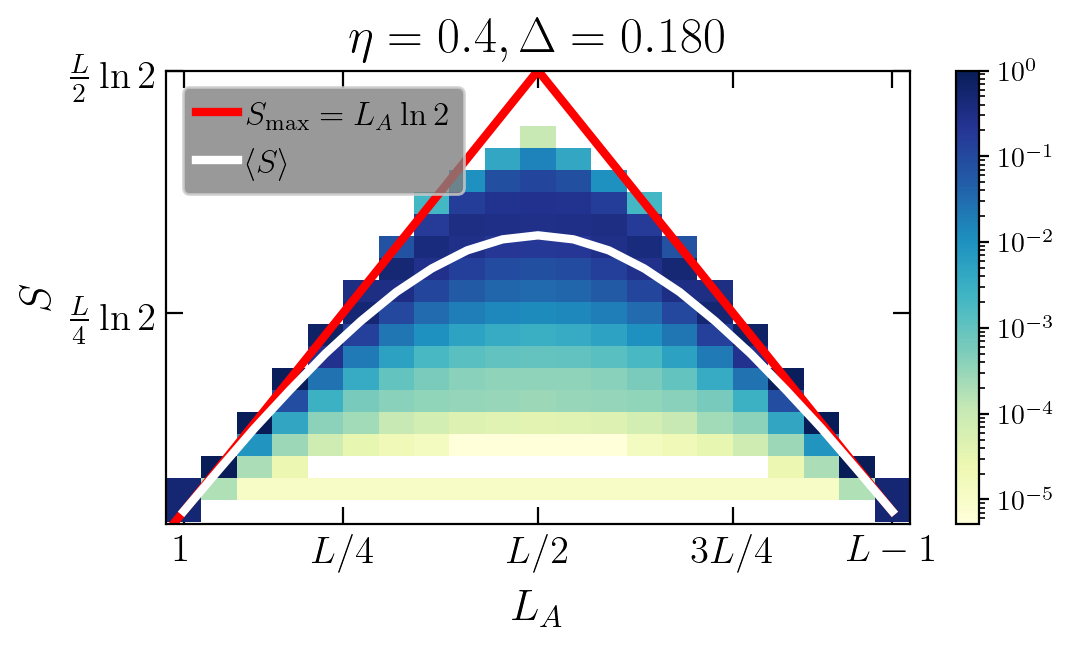

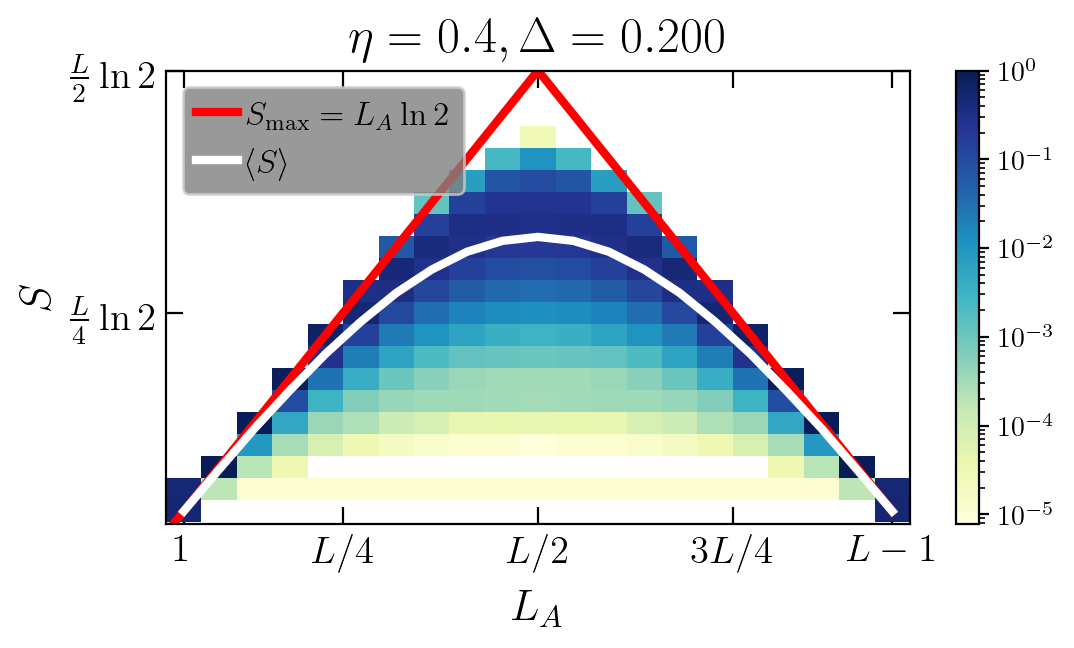

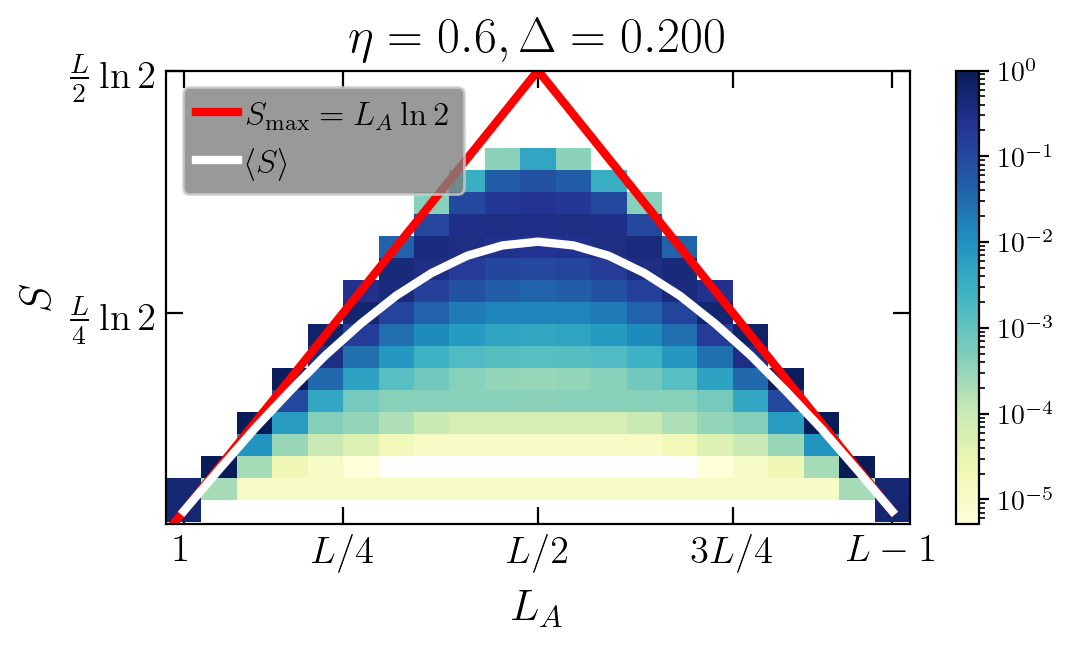

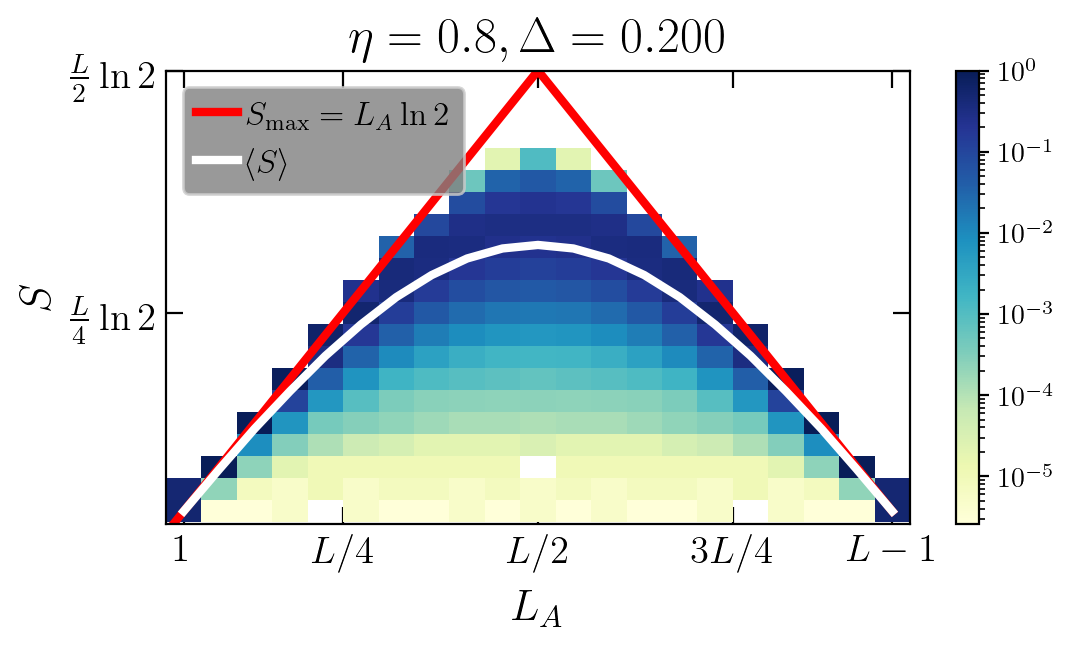

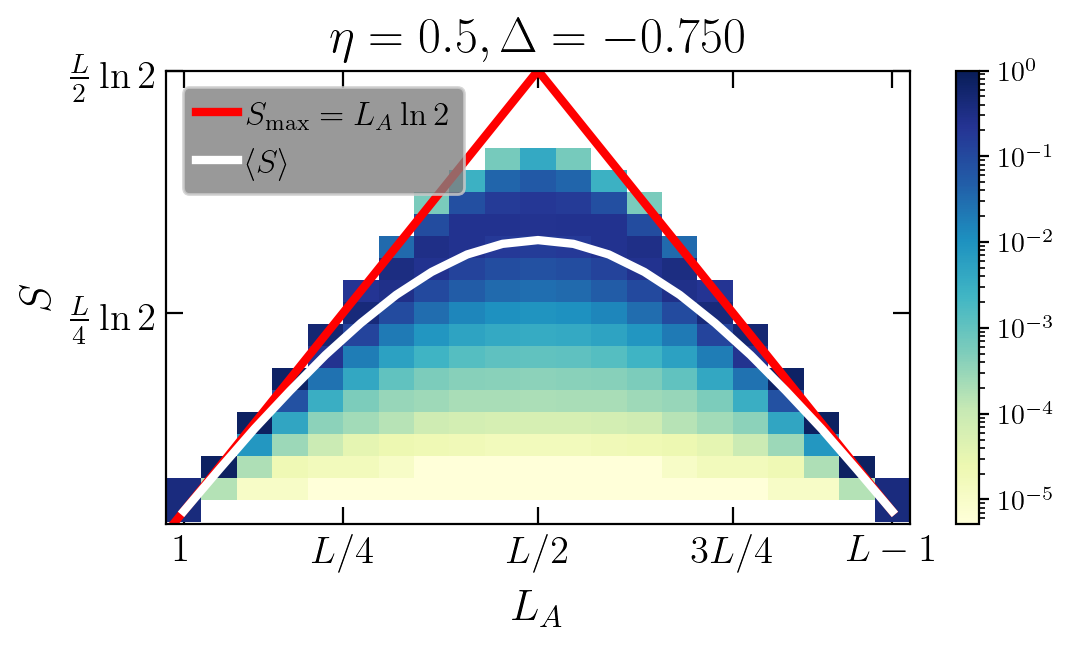

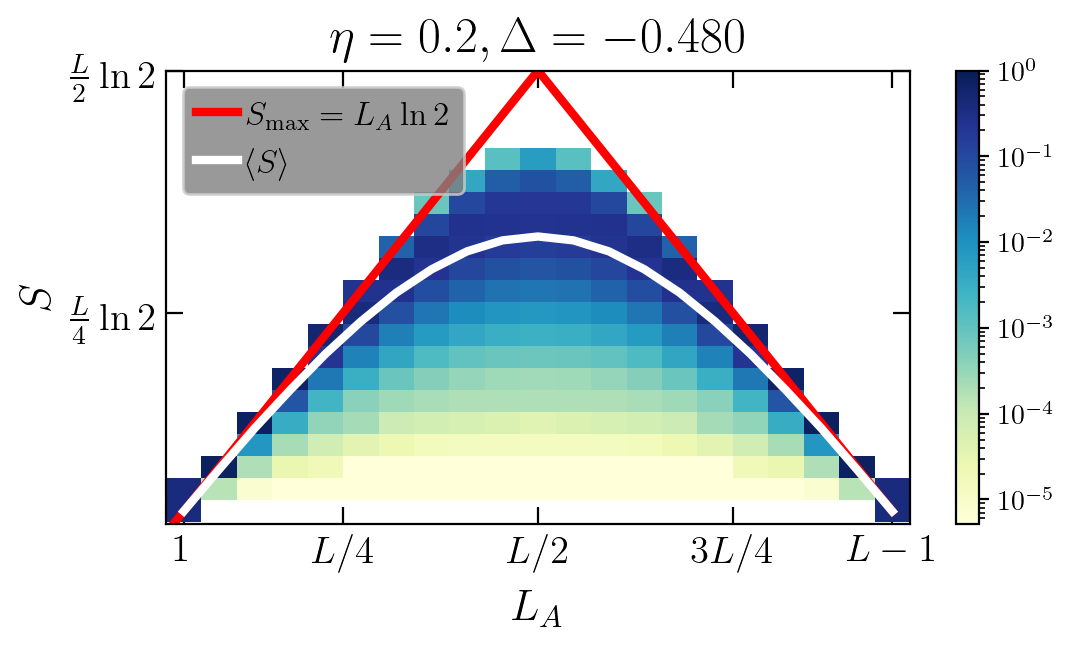

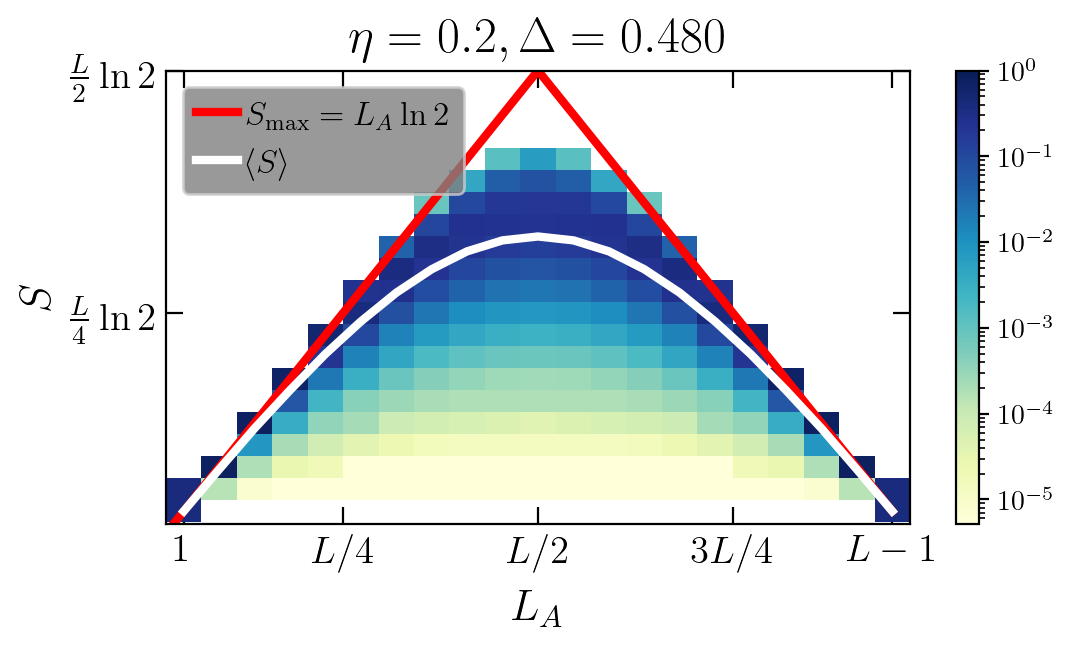

In [36]:

markers = itertools.cycle(markers_ls)

L=22

J1=1.0
d1=0.2
e1=0.2



real_sec, imag_sec = get_sectors(L, 0, 0)

sects = real_sec #+ imag_sec if BOUNDARY_COND == 'PBC' else real_sec


def plot_nice_heatmap(d1, e1):
    fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(6,3), dpi = 200)

    entrop = np.arange(0, 2*(L//2 + L%2) + 1)/2
    entrop = np.linspace(0, L * np.log(2)/2, L + 1)

    sub_sizes = np.arange(1, L)
    density = np.zeros((sub_sizes.size, entrop.size - 1))

    average_entropy = np.zeros((sub_sizes.size))
    dim_tot = 0
    for [ks, ps, zxs, zzs] in sects:
        name = base_dir + 'Entropy/Eigenstate/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs) + ".hdf5"
        if exists(name):
            with h5py.File(name, "r") as file:
                energies = np.array(file.get('energies')[0])
                dim = energies.size

                _, indices, counts = np.unique(np.round(energies, 14), return_index=True, return_counts=True)
                non_deg_idx = [idx for ii, idx in enumerate(indices) if counts[ii] == 1]
                print(ks, ps, zxs, zzs, max(counts))
                # if len(non_deg_idx) < dim:
                #     print(ks, ps, zxs, zzs, counts[counts > 1])

                dim_tot += (2 if ks == 0 or ks == L / 2 else 1) * dim
                for LA in np.arange(1, (L//2 + L%2) + 1):
                    if LA > L//2:   entropies = np.array(file.get('entropy'))[L - LA][non_deg_idx]
                    else:           entropies = np.array(file.get('entropy'))[LA][non_deg_idx]

                    hist, bins = np.histogram(entropies, bins=entrop)
                    hist = np.array(hist)
                    #print(bins, hist)
                    #hist.resize( sub_sizes.size )

                    density[LA-1] += (2 if ks == 0 or ks == L / 2 else 1) * np.array(hist) #* dim
                    average_entropy[LA-1] += (2 if ks == 0 or ks == L / 2 else 1) * np.mean(entropies) * dim
                    if LA < L//2:
                        density[L - LA-1] += (2 if ks == 0 or ks == L / 2 else 1) * np.array(hist) #* dim
                        average_entropy[L - LA-1] += (2 if ks == 0 or ks == L / 2 else 1) * np.mean(entropies) * dim
                    #print(LA, ks, ps, zxs, zzs)
        else:
            print(name)

    density /= dim_tot
    average_entropy /= dim_tot

    #white = plt.get_cmap('seismic', 100)(0.5*np.ones(1))
    upper = plt.get_cmap('YlGnBu', 100)(np.linspace(0.0, 1.0, 100))
    colors = np.vstack((upper))  

    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

    X, Y = np.meshgrid(sub_sizes, entrop[1:])
    print(X, Y)
    p = axis.pcolormesh(X, Y, np.transpose(density), shading='nearest', cmap=mymap, norm=matplotlib.colors.LogNorm(vmin=np.min(density[density > 0]), vmax=1.0))

    laa = np.arange(0, L//2 + L%2 + 1)
    axis.plot(laa, laa * np.log(2), c='red', lw=3)
    laa = np.arange(L//2, L)
    axis.plot(laa, (L - laa)*np.log(2), c='red', lw=3, label=r"$S_{\rm max}=L_A\ln2$")

    axis.plot(sub_sizes, average_entropy, lw=3, c='white', label=r"$\langle S\rangle$")
    axis.set_xlim(0.5, L-0.5)
    axis.set_ylim(0.5, L/2*np.log(2))

    fig_help.set_plot_elements(axis, ylabel="$S$", xlabel=r"$L_A$", font_size=14, set_legend=False)

    xticks = [1, L/4, L/2, 3*L/4, L-1]
    tick_labels = ["$1$", "$L/4$", "$L/2$", "$3L/4$", "$L-1$"]
    axis.set_xticks(xticks)
    axis.set_xticklabels(tick_labels)

    xticks = [L/4*np.log(2), L/2*np.log(2)]
    tick_labels = [r"$\frac{L}{4}\ln2$", r"$\frac{L}{2}\ln2$"]
    axis.set_yticks(xticks)
    axis.set_yticklabels(tick_labels)
    # axis.xaxis.set_minor_locator(plt.NullLocator())
    # axis.yaxis.set_minor_locator(plt.NullLocator())

    axis.set_title(r"$\eta=%.1f,\Delta=%.3f$"%(e1,d1), fontsize=18)
    legend = axis.legend(frameon=1, fontsize=12, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0), facecolor="gray")
    fig.colorbar(p)

    plt.savefig(f"PLOTS/HeatMap_L={L},d1={d1},e1={e1}.pdf", bbox_inches = 'tight', pad_inches=0.02)
    plt.savefig(f"PLOTS/HeatMap_L={L},d1={d1},e1={e1}.png", bbox_inches = 'tight', pad_inches=0.02)


plot_nice_heatmap(d1=0.18, e1=0.2)
plot_nice_heatmap(d1=0.18, e1=0.36)

plot_nice_heatmap(d1=0.2, e1=0.4)
plot_nice_heatmap(d1=0.2, e1=0.6)
plot_nice_heatmap(d1=0.2, e1=0.8)
plot_nice_heatmap(d1=-0.75, e1=0.5)
plot_nice_heatmap(d1=-0.48, e1=0.2)
plot_nice_heatmap(d1=0.48, e1=0.2)
plt.show()

16 0 -1 -1 -1 4
16 0 -1 -1 1 4
16 0 -1 1 -1 4
16 0 -1 1 1 4
16 0 1 -1 -1 4
16 0 1 -1 1 4
16 0 1 1 -1 4
16 0 1 1 1 4
16 8 -1 -1 -1 4
16 8 -1 -1 1 4
16 8 -1 1 -1 4
16 8 -1 1 1 4
16 8 1 -1 -1 4
16 8 1 -1 1 4
16 8 1 1 -1 4
16 8 1 1 1 4
16 1 1 -1 -1 4
16 1 1 -1 1 4
16 1 1 1 -1 4
16 1 1 1 1 4
16 2 1 -1 -1 4
16 2 1 -1 1 4
16 2 1 1 -1 4
16 2 1 1 1 4
16 3 1 -1 -1 4
16 3 1 -1 1 4
16 3 1 1 -1 4
16 3 1 1 1 4
16 4 1 -1 -1 4
16 4 1 -1 1 4
16 4 1 1 -1 4
16 4 1 1 1 4
16 5 1 -1 -1 4
16 5 1 -1 1 4
16 5 1 1 -1 4
16 5 1 1 1 4
16 6 1 -1 -1 4
16 6 1 -1 1 4
16 6 1 1 -1 4
16 6 1 1 1 4
16 7 1 -1 -1 4
16 7 1 -1 1 4
16 7 1 1 -1 4
16 7 1 1 1 4
18 0 -1 -1 -1 9
18 0 -1 -1 1 4
18 0 -1 1 -1 6
18 0 -1 1 1 6
18 0 1 -1 -1 4
18 0 1 -1 1 9
18 0 1 1 -1 7
18 0 1 1 1 9
18 9 -1 -1 -1 4
18 9 -1 -1 1 4
18 9 -1 1 -1 4
18 9 -1 1 1 4
18 9 1 -1 -1 4
18 9 1 -1 1 4
18 9 1 1 -1 4
18 9 1 1 1 4
18 1 1 -1 -1 4
18 1 1 -1 1 4
18 1 1 1 -1 4
18 1 1 1 1 4
18 2 1 -1 -1 4
18 2 1 -1 1 4
18 2 1 1 -1 4
18 2 1 1 1 4
18 3 1 -1 -1 4
18 3 1 -1 1 4
18 

Text(0.5, 1.0, '$\\eta=0.5,\\Delta=-0.375,L_A=2$')

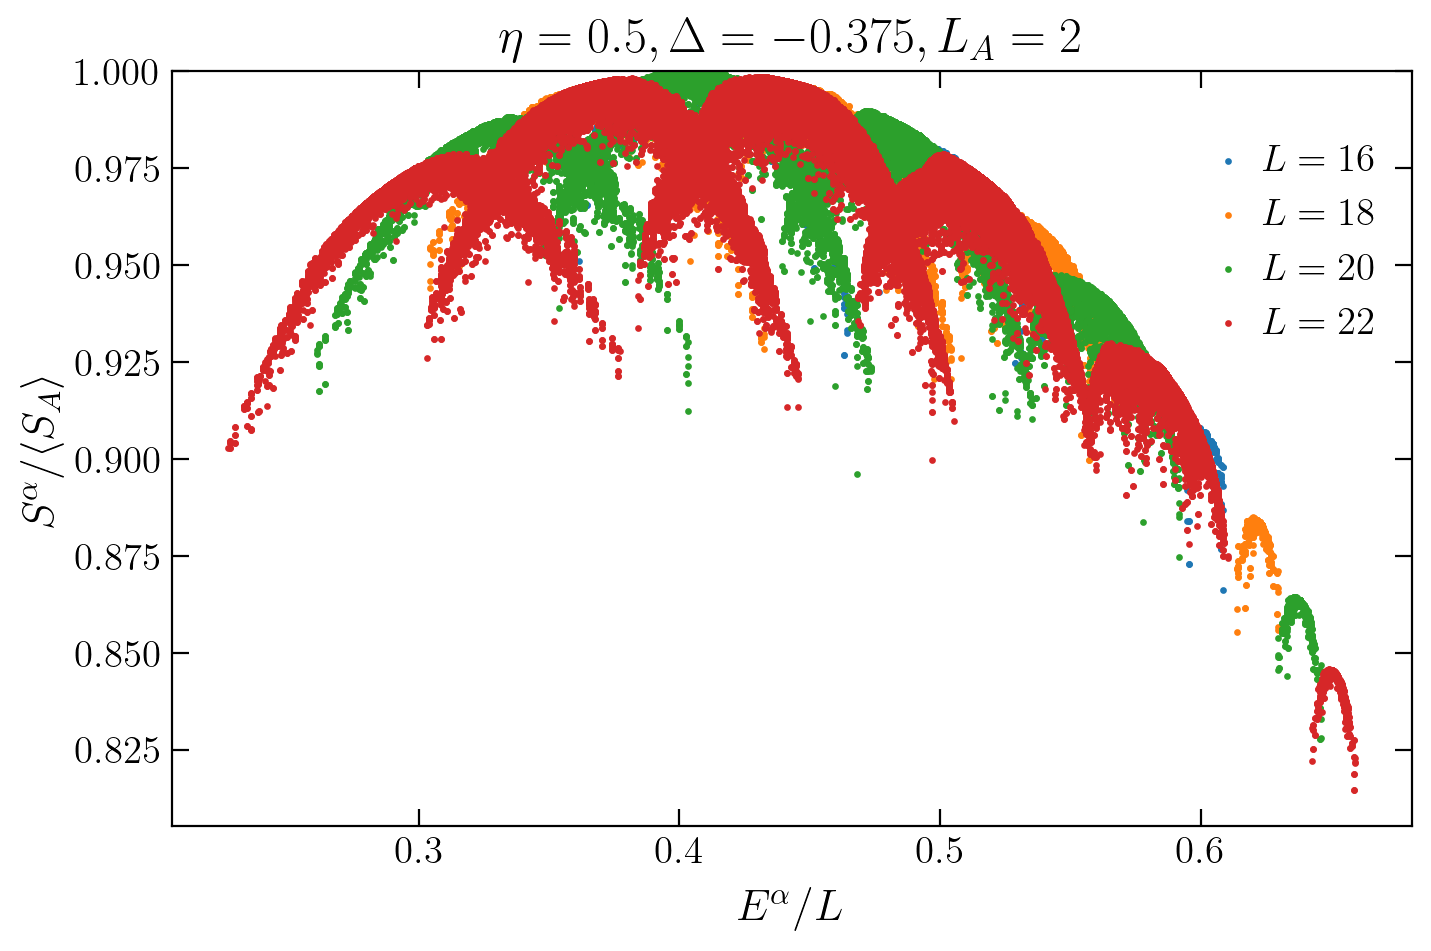

In [180]:

markers = itertools.cycle(markers_ls)

L=22

J1=1.0
d1=-0.375
e1=0.5


fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(8,5), dpi = 200, sharex=True, sharey=True)
for L in np.arange(16, 24, 2):
    real_sec, imag_sec = get_sectors(L, 0.0, 0.0)

    sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec
    LA = 2
    dim_tot = 0
    E = []
    S = []
    for [ks, ps, zxs, zzs] in sects:
        name = base_dir + 'Entropy/Eigenstate/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs) + ".hdf5"
        if exists(name):
            with h5py.File(name, "r") as file:
                energies = np.array(file.get('energies')[0])

                _, indices, counts = np.unique(np.round(energies, 14), return_index=True, return_counts=True)
                non_deg_idx = [idx for ii, idx in enumerate(indices) if counts[ii] > 1]
                print(L, ks, ps, zxs, zzs, max(counts))
                energies = energies[non_deg_idx]
                entropies = np.array(file.get('entropy'))[LA][non_deg_idx]
                E = [*E, *energies] if ks == 0 or ks == L / 2 else [*E, *energies, *energies]
                S = [*S, *entropies] if ks == 0 or ks == L / 2 else [*S, *entropies, *entropies]
        #print(L, e1, ks, ps, zxs, zzs)
    axis.scatter(E / L, S / page(LA, L - LA), s=2, rasterized=True, label=r"$L=%d$"%L)

fig_help.set_plot_elements(axis, ylabel=r"$S^\alpha/\langle S_A\rangle$", xlabel=r"$E^\alpha/L$", font_size=14, set_legend=False)
axis.legend(frameon=0, fontsize=14, loc='upper right', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.0, 0.95))
axis.set_ylim(None, 1)
#axis.axhline(y=LA * np.log(2), ls='--', c='black')
axis.set_title(r"$\eta=%.1f,\Delta=%.3f,L_A=2$"%(e1,d1), fontsize=18)

# plt.savefig(f"PLOTS/EntropyDistribution_L_even,d1={d1},e1={e1},LA=L_2.pdf", bbox_inches = 'tight', pad_inches=0.02)
# plt.savefig(f"PLOTS/EntropyDistribution_L_even,d1={d1},e1={e1},LA=L_2.png", bbox_inches = 'tight', pad_inches=0.02)

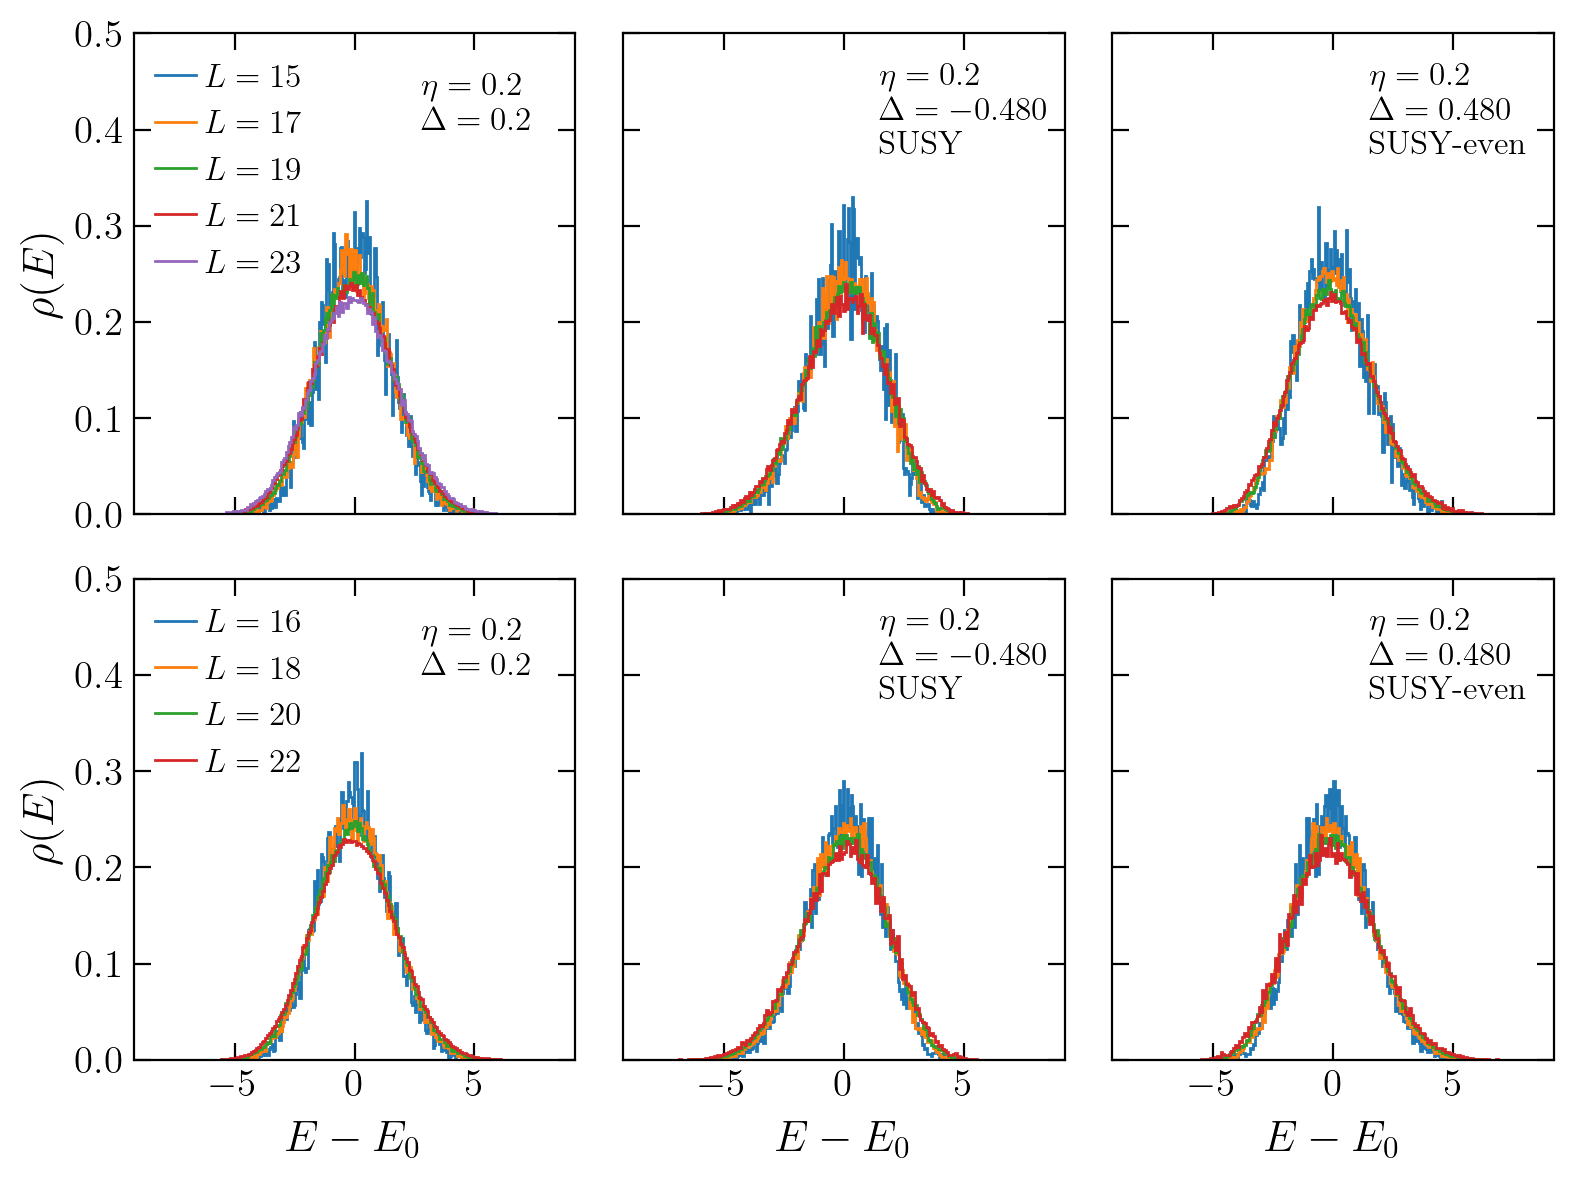

In [35]:

markers = itertools.cycle(markers_ls)

L=22

J1=1.0
d1=-0.375
e1=0.5

fig, axis = plt.subplots( nrows=2, ncols=3, figsize=(8,6), dpi = 200, sharey=True, sharex=True)
#axis = np.array(axis).flatten()

for ii, [d1, e1] in enumerate([ [0.2, 0.2], [-0.48, 0.2], [0.48, 0.2]]):

    for jj, sizes in enumerate([np.arange(15, 24, 2), np.arange(16, 24, 2)]):
        for L in sizes:
            real_sec, imag_sec = get_sectors(L, 0.0, 0.0)

            sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec
            LA = L // 2
            dim_tot = 0
            E = []
            S = []
            for [ks, ps, zxs, zzs] in sects:
                name = base_dir + 'Entropy/Eigenstate/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs) + ".hdf5"
                if exists(name):
                    with h5py.File(name, "r") as file:
                        energies = np.array(file.get('energies')[0]) - L * (3+e1**2)/8
                        E = [*E, *energies] if ks == 0 or ks == L / 2 else [*E, *energies, *energies]

                #print(L, e1, ks, ps, zxs, zzs)
            hist, edges = np.histogram(E, bins=200, normed=True)
            axis[jj][ii].stairs(hist, edges, label=r"$L=%d$"%L)
        
        fig_help.set_plot_elements(axis[jj][ii], ylabel=r"$\rho(E)$" if ii == 0 else "", xlabel=r"$E-E_0$" if jj > 0 else "", font_size=14, set_legend=False)
        if ii == 0:
            legend = axis[jj][ii].legend(frameon=0, fontsize=12, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02, 1.))
        #axis[ii].set_title(r"$\eta=%.1f,\Delta=%.3f$"%(e1,d1), fontsize=18)
        axis[jj][ii].annotate(r"$\eta=%.1f$"%e1 + f"\n" + (r"$\Delta=%.1f$"%(d1) if ii == 0 else r"$\Delta=%.3f$"%(d1)) + ("\nSUSY" if ii == 1 else ("\nSUSY-even" if ii == 2 else "")), 
                                    xy=(0.65, 0.8) if ii == 0 else (0.58, 0.75), fontsize=12, xycoords='axes fraction')

axis[0][0].set_ylim(0, 0.5)

fig.tight_layout()
plt.savefig(f"PLOTS/DOS_all.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig(f"PLOTS/DOS_all.png", bbox_inches = 'tight', pad_inches=0.02)

## FINITE SIZE SCALING

### XXZ

#### SAVER

In [ ]:

L=16

J1=1.0
d1=0.2
e1=0.0

sizes_even = np.arange(12,19,2) if BOUNDARY_COND == 'OBC' else np.arange(14, 23, 2)
sizes_odd = np.arange(11,19,2) if BOUNDARY_COND == 'OBC' else np.arange(15, 23, 2)

def typical(data):
    data = np.array(data)
    return np.exp(np.mean(np.log(data)))

nu = 1.0

frac = lambda dim: dim+1



for d1 in [-0.5, 0.55]:
    for L in np.arange(14,25, 2):
        folder = f'./RESULTS_XXZ/nu={nu}/L={L}/'
        os.makedirs(folder, exist_ok=True)

        LAA = np.arange(1, L//2+1, 1)

        entropy_ave = np.zeros((LAA.size))
        entropy_typ_ave = np.zeros((LAA.size))
        entropy2_ave = np.zeros((LAA.size))
        entropy_degen_ave = np.zeros((LAA.size))
        entropy_all_ave = np.zeros((LAA.size))

        dim_tot_no_U1 = 0
        for U1 in np.arange(1, L, 1):
            entropy = np.zeros((LAA.size))
            entropy_degen = np.zeros((LAA.size))
            entropy_all = np.zeros((LAA.size))

            entropy2 = np.zeros((LAA.size))
            entropy_var = np.zeros((LAA.size))
            entropy_typ = np.zeros((LAA.size))
            real_sec, imag_sec = get_sectors(L=L, hx=0.1, hz=0 if U1 == L/2 else 0.1) # hx != so PZ sector is only [1] same for PX if away from half-filling

            sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec
            for LA in LAA:
            # def loop_body_LA(LA, entropy, entropy2, entropy_var):
                dim_tot = 0
                # Stot = []
                for [ks, ps, zxs, zzs] in sects:
                    
                    name = maks_data + f"SQ,PBC,d=1,Ns={L},Lx={L},Ly=1,Lz=1/" + info_maks(L=L, J1=J1, delta1=d1, k=ks, p=ps, zx=zxs, zz=zzs, U1=U1) + ".h5"

                    if exists(name):
                        with h5py.File(name, "r") as file:
                            try:
                                energies = np.array(file.get('energy')[0])
                                
                                # if U1 == 2 and ks == L/2 and ps == -1 and zxs == 1 and zzs == 1:
                                #     print(energies)
                                dim = energies.size
                                if dim > 0:
                                    _, indices, counts = np.unique(np.round(energies, 14), return_index=True, return_counts=True)
                                    non_deg_idx = []
                                    deg_idx = []
                                    for new_iii, idx in enumerate(indices):
                                        if counts[new_iii] == 1:
                                            for _ in range(counts[new_iii]):
                                                non_deg_idx.append(idx)
                                        else:
                                            for _ in range(counts[new_iii]):
                                                deg_idx.append(idx)

                                    # if len(non_deg_idx) != dim:
                                    #     print(L, d1, e1, "Degeneracies! Number = ", dim - len(non_deg_idx), "Rank = ", max(counts))
                                    entropies = np.array(file.get('entropy'))
                                    # print(LA, non_deg_idx, entropies)
                                    if entropies.shape != ():
                                        if len(non_deg_idx) > 0:
                                            entropies = np.transpose(np.array(file.get('entropy')))[LA-1][non_deg_idx]
                                            
                                            dim_tot += dim if ks == 0 or (ks == L // 2 and L%2 == 0) else 2 * dim

                                            num = frac(dim)

                                            E_av = np.mean(energies)
                                            index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                                            
                                            my_min = int(index_meanE - num / 2)
                                            if my_min < 0: my_min = 0;  

                                            my_max = int(index_meanE + num / 2) 
                                            if my_max >= dim: my_max = dim

                                            sample = entropies
                                            if num < dim and my_min > 0 and my_max < dim:
                                                sample = entropies[my_min : my_max]
                                            # Stot = [*Stot, *sample] if ks == 0 or (ks == L // 2 and L%2==0) else [*Stot, *sample, *sample]
                                            # if U1 == 2:
                                            #     print(np.mean(sample), dim, sample.size)
                                            entropy[LA-1] += dim * np.mean(sample) if ks == 0 or (ks == L // 2 and L%2==0) else 2 * dim * np.mean(sample)
                                            entropy2[LA-1] += dim * np.mean(sample**2) if ks == 0 or (ks == L // 2 and L%2==0) else 2 * dim * np.mean(sample**2)
                                        else:
                                            print(energies)
                                            print("All states are degenerate:", d1, L, U1, ks, ps, zxs, zzs, " Degen size:", dim - len(non_deg_idx))
                                        
                                        if len(deg_idx) > 0:
                                            # DEGENERATE
                                            sample = np.transpose(np.array(file.get('entropy')))[LA-1][deg_idx]
                                            if num < dim and my_min > 0 and my_max < dim:
                                                sample = sample[my_min : my_max]
                                            entropy_degen[LA-1] += dim * np.mean(sample) if ks == 0 or (ks == L // 2 and L%2==0) else 2 * dim * np.mean(sample)

                                        # ALL
                                        sample = np.transpose(np.array(file.get('entropy')))
                                        # print(LA, dim, sample)
                                        sample = sample[LA-1]
                                        if num < dim and my_min > 0 and my_max < dim:
                                            sample = sample[my_min : my_max]
                                        entropy_all[LA-1] += dim * np.mean(sample) if ks == 0 or (ks == L // 2 and L%2==0) else 2 * dim * np.mean(sample)
                                    else:
                                        print("File corrupt, no entropies:", name)
                                  
                                        

                            except TypeError:
                                print("File corrupt, no energies:", name)
                    else:
                        some_wiaibfasdksda=1
                        #print("Not found:", name)
                if dim_tot != binom(L, U1):
                    print(L, LA, d1, "Check Hilbert space", dim_tot, binom(L, U1))
                    # a = 1. / 0
                
                if dim_tot > 0: 
                    entropy[LA-1] /= dim_tot
                    entropy2[LA-1] /= dim_tot
                    entropy_all[LA-1] /= dim_tot
                    entropy_degen[LA-1] /= dim_tot
                # entropy_var[LA] = np.var(np.array(Stot))
                entropy_var[LA-1] = entropy2[LA-1] - (entropy[LA-1])**2
                # entropy_typ[LA-1] = typical(np.array(Stot))
                # entropy[ii] = np.mean(np.array(Stot))
            
            # Parallel(n_jobs=min([10]))(delayed(loop_body_LA)(LA, entropy, entropy2, entropy_var) for LA in LAA)

            entropy_ave += entropy * binom(L, U1)
            entropy_all_ave += entropy_all * binom(L, U1)
            entropy_degen_ave += entropy_degen * binom(L, U1)
            entropy_typ_ave += entropy_typ * binom(L, U1)
            entropy2_ave += entropy2 * binom(L, U1)
            if U1 == 2:
                print(entropy)
            data = {'subsizes': LAA, '<S>': entropy, '<S^2>': entropy_var, '<S>_typ': entropy_typ, '<S>_deg': entropy_degen, '<S>_all': entropy_all}

            df = pd.DataFrame(data=data)
            # print(df) 
            print(L, U1, d1)
            df.to_csv(folder + f'/_U1={U1},delta={d1}.csv')

            dim_tot_no_U1 += binom(L, U1)
        
        entropy_var = entropy2_ave / dim_tot_no_U1 - (entropy_ave / dim_tot_no_U1)**2

        data = {'subsizes': LAA, '<S>': entropy_ave / dim_tot_no_U1, '<S^2>': entropy_var, '<S>_typ': entropy_typ_ave / dim_tot_no_U1, '<S>_deg': entropy_degen_ave / dim_tot_no_U1, '<S>_all': entropy_all_ave / dim_tot_no_U1}

        df = pd.DataFrame(data=data)
        # print(df) 
        df.to_csv(folder + f'/_all_U1,delta={d1}.csv')

#### PLOTTER

22 -0.5 0.2 [0.61941169 0.56339903]
22 -0.5 0.2 [0.76721101 0.54493742]
[3.02468643 3.58578029 4.06513586 4.46701736 4.86190891]
22 -0.5 0.2 [0.6903405 0.5750853]
22 -0.5 0.2 [0.11901308 0.54693547]
22 -0.5 0.2 [0.27332853 0.52441784]
[2.67306256 3.16098232 3.5783763  3.97611253 4.35856376]
22 -0.5 0.2 [0.09380275 0.5635189 ]


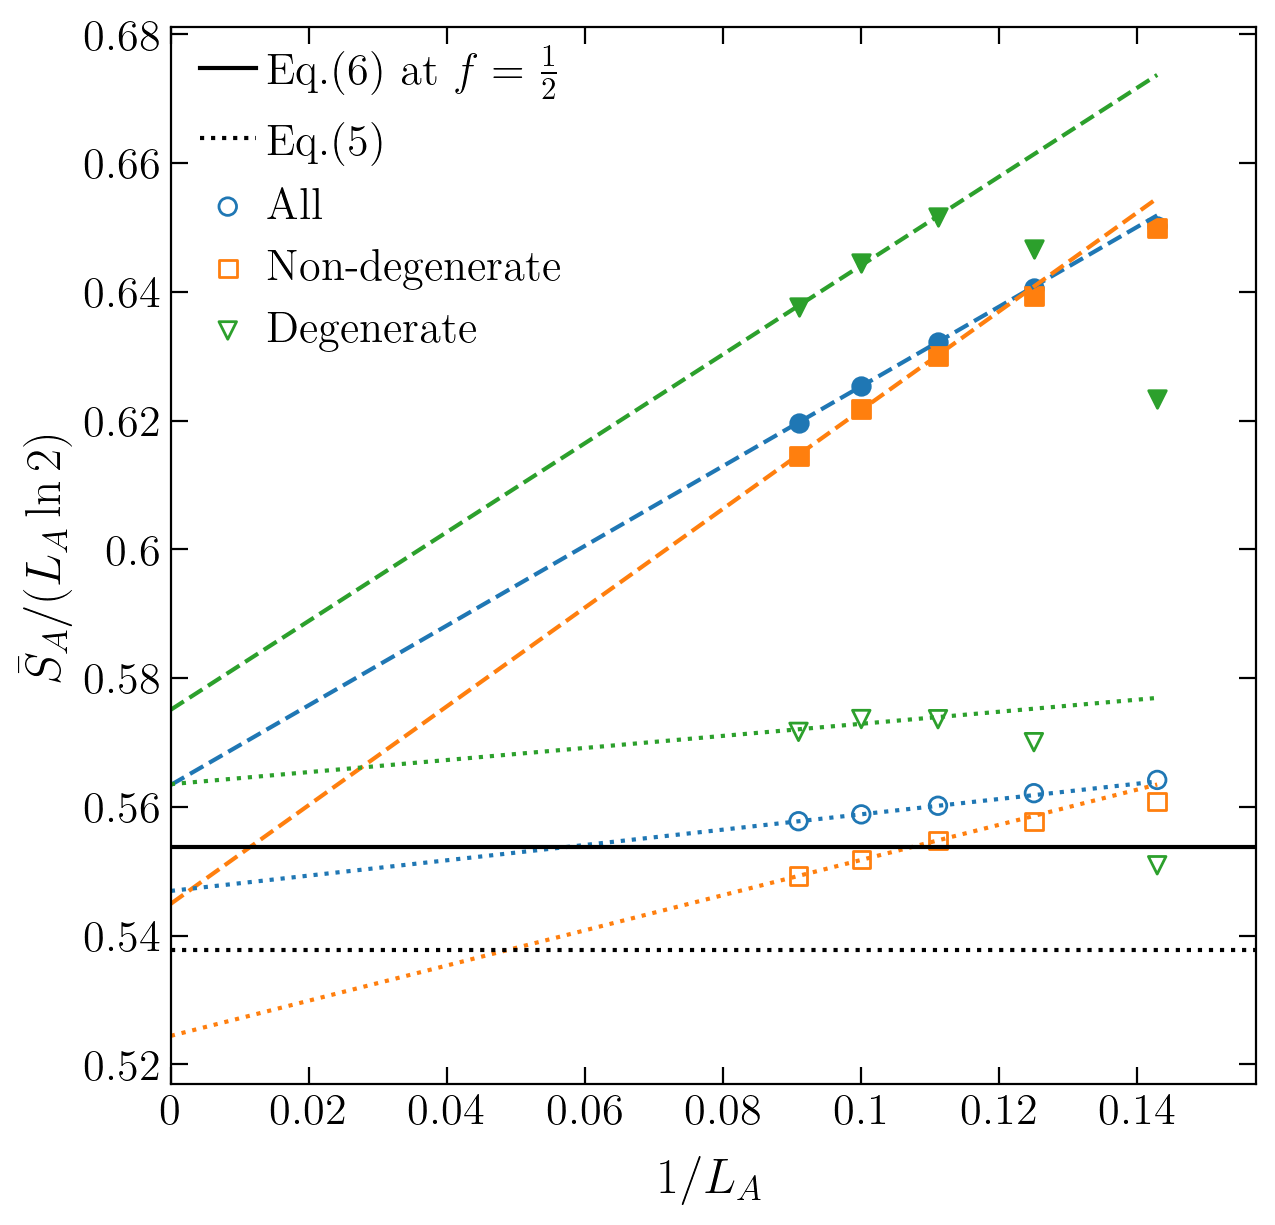

In [52]:
L=16

J1=1.0
d1=-0.5
e1=0.2
sizes = np.arange(14,24, 2)

nu = 1.0

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(7,7), dpi = 200, sharey=True, sharex=True)

for useU1 in [True, False]:
    if nu is None:
        nu = 1.0 if frac(10) >= 10 else (int(frac(0)) if frac(1000) == frac(10) else "%.2f"%(frac(100) / 100))
    # sizes = sizes_even

    # for ijkl, sizes in enumerate([sizes_even]):

    entropy = np.zeros((sizes.size))
    entropy_degen = np.zeros((sizes.size))
    entropy_all = np.zeros((sizes.size))
    LAA = (sizes / 2).astype(int)

    for ii, L in enumerate(sizes):
        U1 = L // 2
        LA = L // 2
        name = f'./RESULTS_XXZ/nu={nu}/L={L}/'
        if useU1:   name += f'_U1={U1},delta={d1}.csv'
        else:       name += f'_all_U1,delta={d1}.csv'
        if exists(name):
            df = pd.read_csv(name)
            entropy[ii] = np.array(df['<S>'])[LA-1]
            entropy_degen[ii] = np.array(df['<S>_deg'])[LA-1]
            entropy_all[ii] = np.array(df['<S>_all'])[LA-1]
        else:
            print(name)
    xx = 1.0 / (LAA)# page( LAA, sizes - LAA)

    # marks = ['s', 'o', 'v']

    markers = itertools.cycle(markers_ls)
    colors_ls_cyc = itertools.cycle(colors_ls)

    labels = ["All", "Non-degenerate", "Degenerate"]
    for new_id, S in enumerate([entropy_all, entropy, entropy_degen]):
        if new_id == 2: print(S)
        S = S[~np.isnan(S)]
        if S.size > 2:
            col = next(colors_ls_cyc)
            mark = next(markers)
            yy = S / (LAA * np.log(2)) #page( LAA, sizes - LAA)

            pars, pconv = fit(lin_fit2,
                            xdata = xx[2:],
                            ydata = yy[2:])
            print(L, d1, e1, pars)
            xval = np.linspace(0, max(xx), 100)
            axis.plot(xval, lin_fit2(xval, *pars), ls='--' if useU1 else ':', color=col)
                     
            if useU1 == 0:
                axis.scatter(xx, yy, marker=mark, s=40, color = col, facecolor='None', label=labels[new_id])
            else:
                axis.scatter(xx, yy, marker=mark, s=40, color = col)
        


axis.axhline(y=0.5537, ls='-', c='black', label=r'Eq.(6) at $f=\frac{1}{2}$')
axis.axhline(y=0.5378, ls=':', c='black', label=r'Eq.(5)')

fig_help.set_plot_elements(axis, ylabel=r"$\bar{S}_A /(L_A\ln2)$", xlabel=r"$1/L_A$", font_size=16, set_legend=True, xscale='linear', yscale='linear')
axis.legend(frameon=0, fontsize=16, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.01,1.02))

# fig_help.set_plot_elements(axis[1], ylabel="", xlabel=r"$1/L_A$", font_size=16, set_legend=True, xscale='linear', yscale='linear')
# axis[1].legend(frameon=0, fontsize=16, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0))

axis.set_xlim(0, 2.2 / 14.)
# axis[0].set_ylim(0.5, None)

for ax in [axis]:
    ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    ax.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))

# axis.annotate(r"a)$\Delta=%g$"%deltas[0], fontsize=16, xy=(0.05, 0.05), xycoords='axes fraction')
# axis.annotate(r"b)$\Delta=%g$"%deltas[1], fontsize=16, xy=(0.05, 0.05), xycoords='axes fraction')

# fig.suptitle(r"$\eta=0.2$", fontsize=18)
fig.subplots_adjust(wspace = 0.05, hspace=0.3)
plt.savefig("PLOTS/Fig_xxz_scaling_degenerate.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig("PLOTS/Fig_xxz_scaling_degenerate.png", bbox_inches = 'tight', pad_inches=0.02)

### XYZ

#### SAVER

In [7]:

L=16

J1=1.0
d1=0.2
e1=0.2

sizes_even = np.arange(12,19,2) if BOUNDARY_COND == 'OBC' else np.arange(14, 23, 2)
sizes_odd = np.arange(11,19,2) if BOUNDARY_COND == 'OBC' else np.arange(15, 23, 2)

def typical(data):
    data = np.array(data)
    return np.exp(np.mean(np.log(data)))

nu = 0.2

frac = lambda dim: int(0.2 * dim)

folder = f'./RESULTS/nu={nu}/'
os.makedirs(folder, exist_ok=True)
os.makedirs(folder + 'Entropy/', exist_ok=True)

for [e1,d1] in [ [0.2, 0.48], [0.2, -0.48], [0.5, -0.375], [0.5, -0.75], [0.2, 0.2], [0.1, 0.1] ]:
# for [e1,d1] in [ [0.2, 0.2], [0.1, 0.1] ]:
    for L in np.arange(14, 23, 1):
        LAA = np.arange(0, L//2+1, 1)

        entropy = np.zeros((LAA.size))
        entropy_degen = np.zeros((LAA.size))
        entropy_all = np.zeros((LAA.size))
        entropy2 = np.zeros((LAA.size))
        entropy_var = np.zeros((LAA.size))
        entropy_typ = np.zeros((LAA.size))
        real_sec, imag_sec = get_sectors(L)

        sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec
        for LA in LAA:
            dim_tot = 0
            Stot = []
            for [ks, ps, zxs, zzs] in sects:
                
                name = base_dir + 'Entropy/Eigenstate/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs) + ".hdf5"

                if exists(name):
                    with h5py.File(name, "r") as file:
                        try:
                            energies = np.array(file.get('energies')[0])
                            dim = energies.size

                            _, indices, counts = np.unique(np.round(energies, 14), return_index=True, return_counts=True)
                            non_deg_idx = []
                            deg_idx = []
                            for new_iii, idx in enumerate(indices):
                                if counts[new_iii] == 1:
                                    for _ in range(counts[new_iii]):
                                        non_deg_idx.append(idx)
                                else:
                                    for _ in range(counts[new_iii]):
                                        deg_idx.append(idx)

                            # if len(non_deg_idx) != dim:
                            #     print(L, d1, e1, "Degeneracies! Number = ", dim - len(non_deg_idx), "Rank = ", max(counts))

                            entropies = np.array(file.get('entropy'))
                            if entropies.shape != ():
                                
                                dim_tot += dim if ks == 0 or (ks == L // 2 and L%2 == 0) else 2 * dim

                                num = frac(dim)

                                E_av = np.mean(energies)
                                index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                                
                                my_min = int(index_meanE - num / 2)
                                if my_min < 0: my_min = 0;  

                                my_max = int(index_meanE + num / 2) 
                                if my_max >= dim: my_max = dim

                                # NON-DEGENERATE
                                sample = np.array(file.get('entropy'))[LA][non_deg_idx]
                                if num < dim and my_min > 0 and my_max < dim:
                                    sample = sample[my_min : my_max]
                                Stot = [*Stot, *sample] if ks == 0 or (ks == L // 2 and L%2==0) else [*Stot, *sample, *sample]
                                entropy[LA] += dim * np.mean(sample) if ks == 0 or (ks == L // 2 and L%2==0) else 2 * dim * np.mean(sample)
                                entropy2[LA] += dim * np.mean(sample**2) if ks == 0 or (ks == L // 2 and L%2==0) else 2 * dim * np.mean(sample**2)
                                entropy_var[LA] += dim * np.var(sample) if ks == 0 or (ks == L // 2 and L%2==0) else 2 * dim * np.var(sample)

                                # DEGENERATE
                                sample = np.array(file.get('entropy'))[LA][deg_idx]
                                if num < dim and my_min > 0 and my_max < dim:
                                    sample = sample[my_min : my_max]
                                entropy_degen[LA] += dim * np.mean(sample) if ks == 0 or (ks == L // 2 and L%2==0) else 2 * dim * np.mean(sample)

                                # ALL
                                sample = np.array(file.get('entropy'))[LA]
                                if num < dim and my_min > 0 and my_max < dim:
                                    sample = sample[my_min : my_max]
                                entropy_all[LA] += dim * np.mean(sample) if ks == 0 or (ks == L // 2 and L%2==0) else 2 * dim * np.mean(sample)

                                
                            else:
                                print("File corrupt, no entropies:", name)
                        except TypeError:
                            print("File corrupt, no energies:", name)
                else:
                    print("Not found:", name)
            if dim_tot != 2**L:
                print("waaaaaaa", dim_tot, 2**L)
            
            # entropy_var[LA] = np.var(np.array(Stot))
            # entropy_var[LA] = entropy2[LA] / dim_tot - (entropy[LA] / dim_tot)**2
            entropy_typ[LA] = typical(np.array(Stot))
            # entropy[ii] = np.mean(np.array(Stot))
            if dim_tot > 0: 
                entropy[LA] /= dim_tot
                entropy_var[LA] /= dim_tot
                entropy_all[LA] /= dim_tot
                entropy_degen[LA] /= dim_tot

        data = {'subsizes': LAA, '<S>': entropy, '<S^2>': entropy_var, '<S>_typ': entropy_typ, '<S>_deg': entropy_degen, '<S>_all': entropy_all}

        df = pd.DataFrame(data=data)
        # print(df) 
        print(L, e1, d1)
        df.to_csv(f'./RESULTS/nu={nu}/Entropy/_L={L},eta={e1},delta={d1}.csv')

14 0.2 0.48
15 0.2 0.48
16 0.2 0.48
17 0.2 0.48
18 0.2 0.48
19 0.2 0.48
20 0.2 0.48
21 0.2 0.48
22 0.2 0.48
14 0.2 -0.48
15 0.2 -0.48
16 0.2 -0.48
17 0.2 -0.48
18 0.2 -0.48
19 0.2 -0.48
20 0.2 -0.48
21 0.2 -0.48
22 0.2 -0.48
14 0.5 -0.375
15 0.5 -0.375
16 0.5 -0.375
17 0.5 -0.375
18 0.5 -0.375
19 0.5 -0.375
20 0.5 -0.375
21 0.5 -0.375
22 0.5 -0.375
14 0.5 -0.75
15 0.5 -0.75
16 0.5 -0.75
17 0.5 -0.75
18 0.5 -0.75
19 0.5 -0.75
20 0.5 -0.75
21 0.5 -0.75
22 0.5 -0.75
14 0.2 0.2
15 0.2 0.2
16 0.2 0.2
17 0.2 0.2
18 0.2 0.2
19 0.2 0.2
20 0.2 0.2
21 0.2 0.2
22 0.2 0.2
14 0.1 0.1
15 0.1 0.1
16 0.1 0.1
17 0.1 0.1
18 0.1 0.1
19 0.1 0.1
20 0.1 0.1
21 0.1 0.1
22 0.1 0.1


#### PLOTTER

In [23]:

def typical(data):
    data = np.array(data)
    return np.exp(np.mean(np.log(data)))

L=16

J1=1.0
d1=0.2
e1=0.2
sizes_even = np.arange(12,19,2) if BOUNDARY_COND == 'OBC' else np.arange(14, 23, 2)
sizes_odd = np.arange(11,19,2) if BOUNDARY_COND == 'OBC' else np.arange(15, 23, 2)

def plottt(axis, d1, e1, label = "", frac = lambda dim: dim+1, moment = 'mean', nu = None, nolegend=False, size = 60):
    """
    Moment -> 'mean', 'var', 'typ'
    """
    col = next(colors_ls_cyc)
    
    if nu is None:
        nu = 1.0 if frac(10) >= 10 else (int(frac(0)) if frac(1000) == frac(10) else "%.2f"%(frac(100) / 100))
    os.makedirs(f'./RESULTS/nu={nu}/', exist_ok=True)
    os.makedirs(f'./RESULTS/nu={nu}/Entropy/', exist_ok=True)
    # sizes = sizes_even
    # for ijkl, sizes in enumerate([sizes_even, sizes_odd]):
    for ijkl, sizes in enumerate([sizes_even]):

        entropy = np.zeros((sizes.size))
        entropy_var = np.zeros((sizes.size))
        entropy_typ = np.zeros((sizes.size))
        LAA = (sizes / 2).astype(int)
        
        for ii, L in enumerate(sizes):
            LA = L // 2
            if exists(f'./RESULTS/nu={nu}/Entropy/_L={L},eta={e1},delta={d1}.csv'):
                df = pd.read_csv(f'./RESULTS/nu={nu}/Entropy/_L={L},eta={e1},delta={d1}.csv')
                entropy[ii] = np.array(df['<S>'])[LA]
                entropy_var[ii] = np.array(df['<S^2>'])[LA]
                entropy_typ[ii] = np.array(df['<S>_typ'])[LA]
                
            else:
                real_sec, imag_sec = get_sectors(L, 0, 0)

                sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec
                dim_tot = 0
                Stot = []
                for [ks, ps, zxs, zzs] in sects:
                    name = base_dir + 'Entropy/Eigenstate/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs) + ".hdf5"
                    if exists(name):
                        with h5py.File(name, "r") as file:
                            try:
                                energies = np.array(file.get('energies')[0])
                                dim = energies.size

                                _, indices, counts = np.unique(np.round(energies, 14), return_index=True, return_counts=True)
                                non_deg_idx = []
                                for new_iii, idx in enumerate(indices):
                                    if counts[new_iii] == 1:
                                        for _ in range(counts[new_iii]):
                                            non_deg_idx.append(idx)
                                if len(non_deg_idx) != dim:
                                    print(L, d1, e1, "Degeneracies! Number = ", dim - len(non_deg_idx), "Rank = ", max(counts))

                                entropies = np.array(file.get('entropy'))
                                if entropies.shape != ():
                                    entropies = np.array(file.get('entropy'))[LA][non_deg_idx]
                                    
                                    dim_tot += dim if ks == 0 or ks == L / 2 else 2 * dim

                                    num = frac(dim)

                                    E_av = np.mean(energies)
                                    index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                                    
                                    my_min = int(index_meanE - num / 2)
                                    if my_min < 0: my_min = 0;  

                                    my_max = int(index_meanE + num / 2) 
                                    if my_max >= dim: my_max = dim

                                    sample = entropies
                                    if num < dim and my_min > 0 and my_max < dim:
                                        sample = entropies[my_min : my_max]
                                    Stot = [*Stot, *sample] if ks == 0 or ks == L / 2 else [*Stot, *sample, *sample]
                                    entropy[ii] += dim * np.mean(sample) if ks == 0 or ks == L / 2 else 2 * dim * np.mean(sample)
                                else:
                                    print("File corrupt, no entropies:", name)
                            except TypeError:
                                print("File corrupt, no energies:", name)
                    else:
                        print("Not found:", name)
                if dim_tot != 2**L:
                    print("waaaaaaa", dim_tot, 2**L)
                
                entropy_var[ii] = np.var(np.array(Stot))
                entropy_typ[ii] = typical(np.array(Stot))
                # entropy[ii] = np.mean(np.array(Stot))
                if dim_tot > 0: entropy[ii] /= dim_tot   
                
        if moment == 'var':

            xx = 1./LAA #page_var(LAA, sizes - LAA)
            yy = (entropy_var) / (LAA * np.log(2))**2  #page_var(LAA, sizes - LAA)

            def new_fit(x, a, b, c):
                return a * x + b * x**2
            pars, pconv = fit(new_fit,
                            xdata = xx,
                            ydata = yy)
            print("Odd" if ijkl else "Even", d1, e1, pars)
            xval = np.linspace(0, max(xx), 100)
            
            axis.plot(xval, new_fit(xval, *pars), ls='--', color=col)
            if ijkl:        axis.scatter(xx, yy, marker='o', s=size, color = col, facecolor = 'None')
            elif nolegend:  axis.scatter(xx, yy, marker='o', s=size, color = col)
            else:           axis.scatter(xx, yy, marker='o', s=size, color = col, label=label)
            
            axis.set_xlim(0, None)
            # axis.set_ylim(0, 1.01*np.max(yy))
        elif moment == 'mean':
            # print(sizes_even, entropy)
            xx = 1.0 / (LAA).astype(float)# page( LAA, sizes - LAA)

            yy = entropy / (LAA * np.log(2)) #page( LAA, sizes - LAA)

            pars, pconv = fit(lin_fit2,
                            xdata = xx,
                            ydata = yy)
            print(L, d1, e1, pars)
            xval = np.linspace(0, max(xx), 100)
            axis.plot(xval, lin_fit2(xval, *pars), ls='--', color=col)
            if ijkl:        axis.scatter(xx, yy, marker='o', s=size, color = col, facecolor = 'None')
            elif nolegend:  axis.scatter(xx, yy, marker='o', s=size, color = col)
            else:           axis.scatter(xx, yy, marker='o', s=size, color = col, label=label)
        

            axis.set_xlim(0, None)
            axis.set_ylim(0.52, None)
        
        elif moment == 'typ':
            xx = 1. / LAA

            yy = entropy_typ / entropy # / page( LAA, sizes - LAA)

            pars, pconv = fit(lin_fit2,
                            xdata = xx,
                            ydata = yy)
            print(L, d1, e1, pars)
            xval = np.linspace(0, max(xx), 100)
            axis.plot(xval, lin_fit2(xval, *pars), ls='--', color=col)
            if ijkl:        axis.scatter(xx, yy, marker='o', s=size, color = col, facecolor = 'None')
            elif nolegend:  axis.scatter(xx, yy, marker='o', s=size, color = col)
            else:           axis.scatter(xx, yy, marker='o', s=size, color = col, label=label)
        

            axis.set_xlim(0, None)
        # axis.set_ylim(None, 1.0)
        else: 
            raise ValueError("No moment chosen! Take mean, var or typ for calculation")

### PLOTS

In [ ]:

markers = itertools.cycle(markers_ls)
colors_ls_cyc = itertools.cycle(colors_ls)

fig, axis = plt.subplots( nrows=3, ncols=2, figsize=(8,9), dpi = 200, sharey='col')

# axis[0].axhline(y=0.5537, ls='--', c='black')
# axis[0].axhline(y=0.5378, ls=':', c='black')

axis[0][0].axhline(y=0.5537, ls='-', c='black', label=r'Eq.(6) at $f=\frac{1}{2}$')
axis[0][0].axhline(y=0.5378, ls=':', c='black', label=r'Eq.(5)')
axis[1][0].axhline(y=0.5537, ls='-', c='black')
axis[1][0].axhline(y=0.5378, ls=':', c='black')
axis[2][0].axhline(y=0.5537, ls='-', c='black')
axis[2][0].axhline(y=0.5378, ls=':', c='black')  

#[[0.2, 0.2], [-0.375, 0.5], [0.2, 0.4], [-0.75, 0.5]]
plottt(axis[0][0], d1=0.1, e1=0.1, label = r"$\Delta=0.1,\eta=0.1$", size=60)
plottt(axis[0][0], d1=0.2, e1=0.2, label = r"$\Delta=0.2,\eta=0.2$", size=30)
colors_ls_cyc = itertools.cycle(colors_ls)
plottt(axis[0][1], d1=0.1, e1=0.1, moment='var')
plottt(axis[0][1], d1=0.2, e1=0.2, moment='var')
colors_ls_cyc = itertools.cycle(colors_ls)

plottt(axis[1][0], d1=0, e1=0.1, label = r"$\Delta=0,\eta=0.1$", size=60)
plottt(axis[1][0], d1=0, e1=0.2, label = r"$\Delta=0,\eta=0.2$", size=30)
colors_ls_cyc = itertools.cycle(colors_ls)
plottt(axis[1][1], d1=-0.375, e1=0.5, moment='var')
plottt(axis[1][1], d1=-0.75, e1=0.5, moment='var')
colors_ls_cyc = itertools.cycle(colors_ls)
# axis[1][0].set_ylim(0.5, 0.65)

plottt(axis[2][0], d1=0.48, e1=0.2, label = r"$\Delta=0.48,\eta=-0.2$", size=60)
plottt(axis[2][0], d1=-0.48, e1=0.2, label = r"$\Delta=-0.48,\eta=0.2$", size=30)
colors_ls_cyc = itertools.cycle(colors_ls)
plottt(axis[2][1], d1=0.48, e1=0.2, moment='var')
plottt(axis[2][1], d1=-0.48, e1=0.2, moment='var')
colors_ls_cyc = itertools.cycle(colors_ls)
# plottt(axis[1], d1=-0.375, e1=0.5, label = r"$\Delta=-0.375,\eta=0.5$")
# plottt(axis[1], d1=-0.75, e1=0.5, label = r"$\Delta=-0.75,\eta=0.5$")


fig_help.set_plot_elements(axis[0][0], ylabel=r"$\bar S_A / (L_A\ln2)$", xlabel="", font_size=14, set_legend=True)
axis[0][0].legend(frameon=0, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.03,1.05))#, title=r"$\Delta=0.2$", title_fontsize=16)
axis[0][0].annotate("a)", fontsize=16, xy=(0.05, 0.05), xycoords='axes fraction')

fig_help.set_plot_elements(axis[0][1], ylabel=r"$\Sigma^2_S$", xlabel="", font_size=14, set_legend=True)
axis[0][1].annotate("d)", fontsize=16, xy=(0.05, 0.9), xycoords='axes fraction')

fig_help.set_plot_elements(axis[1][0], ylabel=r"$\bar S_A / (L_A\ln2))$", xlabel="", font_size=14, set_legend=True)
axis[1][0].legend(frameon=0, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.04,1.05))#, title=r"$\Delta=0.2$", title_fontsize=16)
axis[1][0].annotate("b)", fontsize=16, xy=(0.05, 0.05), xycoords='axes fraction')

fig_help.set_plot_elements(axis[1][1], ylabel=r"$\Sigma^2_S$", xlabel="", font_size=14, set_legend=True)
axis[1][1].annotate("e)", fontsize=16, xy=(0.05, 0.9), xycoords='axes fraction')

for ax in (axis[:2,:]).flatten():
    ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
fig_help.set_plot_elements(axis[2][0], ylabel=r"$\bar S_A / (L_A\ln2)$", xlabel=r"$1 / L_A$", font_size=14, set_legend=True)
axis[2][0].annotate("c)", fontsize=16, xy=(0.05, 0.05), xycoords='axes fraction')

fig_help.set_plot_elements(axis[2][1], ylabel=r"$\Sigma^2_S$", xlabel=r"$1 / L_A$", font_size=14, set_legend=True)
axis[2][1].annotate("f)", fontsize=16, xy=(0.05, 0.9), xycoords='axes fraction')

fig.subplots_adjust(wspace = 0.35, hspace=0.05)

22 0.1 0.1 [0.53694469 0.58585428]
22 0.2 0.2 [0.68974147 0.55878483]
Even 0.1 0.1 [ 0.06412026 -0.21358945  1.        ]


No handles with labels found to put in legend.


Even 0.2 0.4 [ 0.05018143 -0.13925189  1.        ]
22 0.1 0.1 [0.57391889 0.57768391]
22 0.2 0.2 [0.68036262 0.55685132]
Even 0.1 0.1 [ 0.05301964 -0.11106815  1.        ]
Even 0.2 0.2 [ 0.0438088  -0.08969976  1.        ]


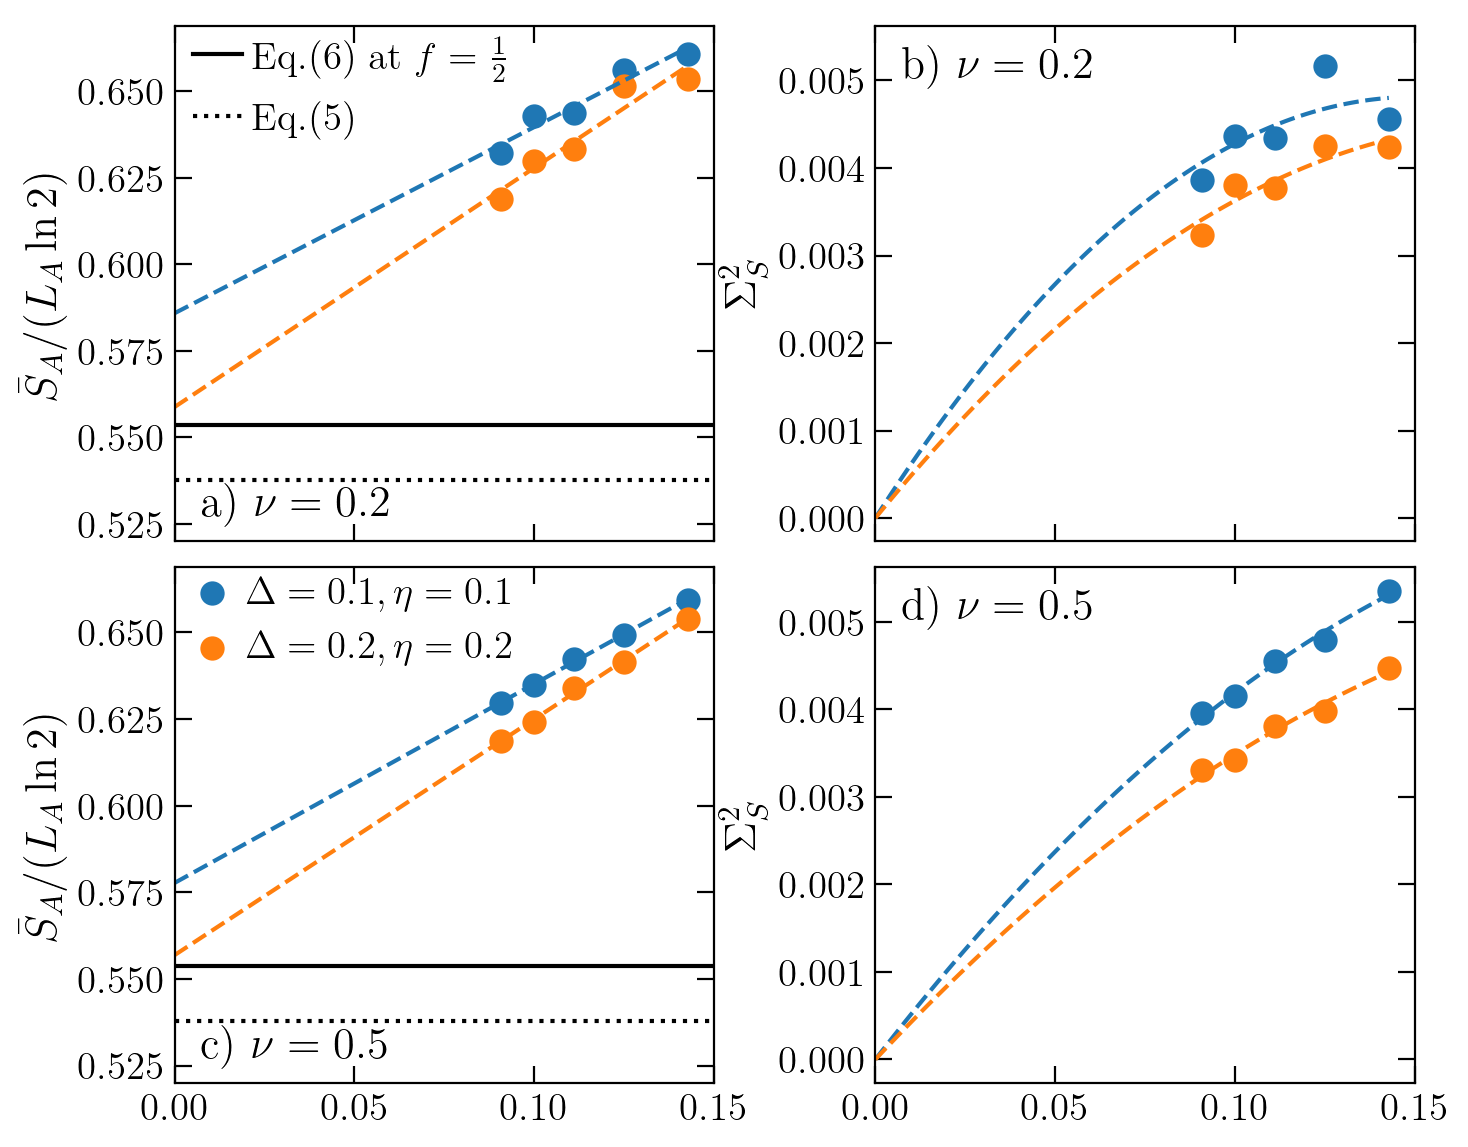

In [26]:

markers = itertools.cycle(markers_ls)
colors_ls_cyc = itertools.cycle(colors_ls)

fig, axis = plt.subplots( nrows=2, ncols=2, figsize=(8,7), dpi = 200, sharey='col')

# axis[0].axhline(y=0.5537, ls='--', c='black')
# axis[0].axhline(y=0.5378, ls=':', c='black')

axis[0][0].axhline(y=0.5537, ls='-', c='black', label=r'Eq.(6) at $f=\frac{1}{2}$')
axis[0][0].axhline(y=0.5378, ls=':', c='black', label=r'Eq.(5)')
axis[1][0].axhline(y=0.5537, ls='-', c='black')
axis[1][0].axhline(y=0.5378, ls=':', c='black')
# axis[2][0].axhline(y=0.5537, ls='-', c='black')
# axis[2][0].axhline(y=0.5378, ls=':', c='black')  

#[[0.2, 0.2], [-0.375, 0.5], [0.2, 0.4], [-0.75, 0.5]]
plottt(axis[0][0], d1=0.1, e1=0.1, frac=lambda dim: 100, nu=100)
plottt(axis[0][0], d1=0.2, e1=0.2, frac=lambda dim: 100, nu=100)
colors_ls_cyc = itertools.cycle(colors_ls)
plottt(axis[0][1], d1=0.1, e1=0.1, moment='var', frac = lambda dim: int(0.2*dim), nu='0.2')
plottt(axis[0][1], d1=0.2, e1=0.4, moment='var', frac = lambda dim: int(0.2*dim), nu='0.2')
colors_ls_cyc = itertools.cycle(colors_ls)

plottt(axis[1][0], d1=0.1, e1=0.1, label = r"$\Delta=0.1,\eta=0.1$", frac=lambda dim: int(0.5*dim), nu='0.5')
plottt(axis[1][0], d1=0.2, e1=0.2, label = r"$\Delta=0.2,\eta=0.2$", frac=lambda dim: int(0.5*dim), nu='0.5')
colors_ls_cyc = itertools.cycle(colors_ls)
plottt(axis[1][1], d1=0.1, e1=0.1, moment='var', frac=lambda dim: 0.5*dim, nu='0.5')
plottt(axis[1][1], d1=0.2, e1=0.2, moment='var', frac=lambda dim: 0.5*dim, nu='0.5')
colors_ls_cyc = itertools.cycle(colors_ls)

# plottt(axis[2][0], d1=0.1, e1=0.1, label = r"$\Delta=0.1,\eta=0.1$", frac=lambda dim: dim+1, nu=1.0)
# plottt(axis[2][0], d1=0.2, e1=0.2, label = r"$\Delta=0.2,\eta=0.2$", frac=lambda dim: dim+1, nu=1.0)
# colors_ls_cyc = itertools.cycle(colors_ls)
# plottt(axis[2][1], d1=0.1, e1=0.1, moment='var', frac=lambda dim: dim+1, nu=1.0)
# plottt(axis[2][1], d1=0.2, e1=0.2, moment='var', frac=lambda dim: dim+1, nu=1.0)
# colors_ls_cyc = itertools.cycle(colors_ls)
# plottt(axis[1], d1=-0.375, e1=0.5, label = r"$\Delta=-0.375,\eta=0.5$")
# plottt(axis[1], d1=-0.75, e1=0.5, label = r"$\Delta=-0.75,\eta=0.5$")


fig_help.set_plot_elements(axis[0][0], ylabel=r"$\bar S_A / (L_A\ln2)$", xlabel="", font_size=14, set_legend=True)
axis[0][0].legend(frameon=0, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.03,1.05))#, title=r"$\Delta=0.2$", title_fontsize=16)
axis[0][0].annotate(r"a) $\nu=0.2$", fontsize=16, xy=(0.05, 0.05), xycoords='axes fraction')

fig_help.set_plot_elements(axis[0][1], ylabel=r"$\Sigma^2_S$", xlabel="", font_size=14, set_legend=False)
axis[0][1].annotate(r"b) $\nu=0.2$", fontsize=16, xy=(0.05, 0.9), xycoords='axes fraction')

fig_help.set_plot_elements(axis[1][0], ylabel=r"$\bar S_A / (L_A\ln2)$", xlabel="", font_size=14, set_legend=True)
axis[1][0].legend(frameon=0, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.04,1.05))#, title=r"$\Delta=0.2$", title_fontsize=16)
axis[1][0].annotate(r"c) $\nu=0.5$", fontsize=16, xy=(0.05, 0.05), xycoords='axes fraction')

fig_help.set_plot_elements(axis[1][1], ylabel=r"$\Sigma^2_S$", xlabel="", font_size=14, set_legend=True)
axis[1][1].annotate(r"d) $\nu=0.5$", fontsize=16, xy=(0.05, 0.9), xycoords='axes fraction')

for ax in (axis[:1,:]).flatten():
    ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
# fig_help.set_plot_elements(axis[2][0], ylabel=r"$\bar S_A / (L_A\ln2)$", xlabel=r"$1 / L_A$", font_size=14, set_legend=True)
# axis[2][0].legend(frameon=0, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.04,1.05))#, title=r"$\Delta=0.2$", title_fontsize=16)
# axis[2][0].annotate(r"c)$\nu=1.0$", fontsize=16, xy=(0.05, 0.05), xycoords='axes fraction')

# fig_help.set_plot_elements(axis[2][1], ylabel=r"$\Sigma^2_S$", xlabel=r"$1 / L_A$", font_size=14, set_legend=True)
# axis[2][1].annotate(r"f)$\nu=1.0$", fontsize=16, xy=(0.05, 0.9), xycoords='axes fraction')

fig.subplots_adjust(wspace = 0.3, hspace=0.05)
plt.savefig("PLOTS/Fig_xyz_scaling.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig("PLOTS/Fig_xyz_scaling.png", bbox_inches = 'tight', pad_inches=0.02)

In [ ]:

markers = itertools.cycle(markers_ls)
colors_ls_cyc = itertools.cycle(colors_ls)

L=16

J1=1.0
d1=0.2
e1=0.2
J2=0.0
d2=0.0
e2=0.0

hx=0.0
hz=0.0

k=0
p=1
zx=1
zz=1

fig, axis = plt.subplots( nrows=1, ncols=3, figsize=(12,5), dpi = 200, sharey=True)

# sizes_even = np.arange(12,19,2) if BOUNDARY_COND == 'OBC' else np.arange(16, 23, 2)

axis[0].axhline(y=0.5537, ls='--', c='black')
axis[0].axhline(y=0.5378, ls=':', c='black')
axis[2].axhline(y=0.5537, ls='--', c='black')
axis[2].axhline(y=0.5378, ls=':', c='black')
axis[1].axhline(y=0.5537, ls='--', c='black', label='QC (PRL125, 180604)')
axis[1].axhline(y=0.5378, ls=':', c='black', label='TI (PRL119, 020601)')
      
#[[0.2, 0.2], [-0.375, 0.5], [0.2, 0.4], [-0.75, 0.5]]
for ii, frac in enumerate([lambda dim: 200, lambda dim: 0.25 * dim, lambda dim: dim + 1]):
    colors_ls_cyc = itertools.cycle(colors_ls)
    plottt(axis[ii], d1=0.2, e1=0.2, label = r"$\Delta=0.2,\eta=0.2$" if ii == 0 else "", frac=frac)
    plottt(axis[ii], d1=-0.375, e1=0.5, label = r"$\Delta=-0.375,\eta=0.5$" if ii == 0 else "", frac=frac)
    plottt(axis[ii], d1=-0.75, e1=0.5, label = r"$\Delta=-0.75,\eta=0.5$" if ii == 0 else "", frac=frac)

fig_help.set_plot_elements(axis[0], ylabel=r"$\bar S_A / \langle S_A\rangle$", xlabel=r"$1 / \langle S_A\rangle$", font_size=14, set_legend=True)
axis[0].legend(frameon=0, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0))#, title=r"$\Delta=0.2$", title_fontsize=16)

fig_help.set_plot_elements(axis[1], ylabel="", xlabel=r"$1 / \langle S_A\rangle$", font_size=14, set_legend=True)
axis[1].legend(frameon=0, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0))#, title=r"$\eta=0.5$ (SUSY)", title_fontsize=16)

fig_help.set_plot_elements(axis[2], ylabel="", xlabel=r"$1 / \langle S_A\rangle$", font_size=14, set_legend=True)

axis[0].annotate(r"a) $\Lambda=200$", fontsize=16, xy=(0.05, 0.08), xycoords='axes fraction')
axis[1].annotate(r"b) $\nu=0.25$", fontsize=16, xy=(0.05, 0.08), xycoords='axes fraction')
axis[2].annotate(r"c) $\nu=1$", fontsize=16, xy=(0.05, 0.08), xycoords='axes fraction')
fig.subplots_adjust(wspace = 0.02, hspace=0.3)

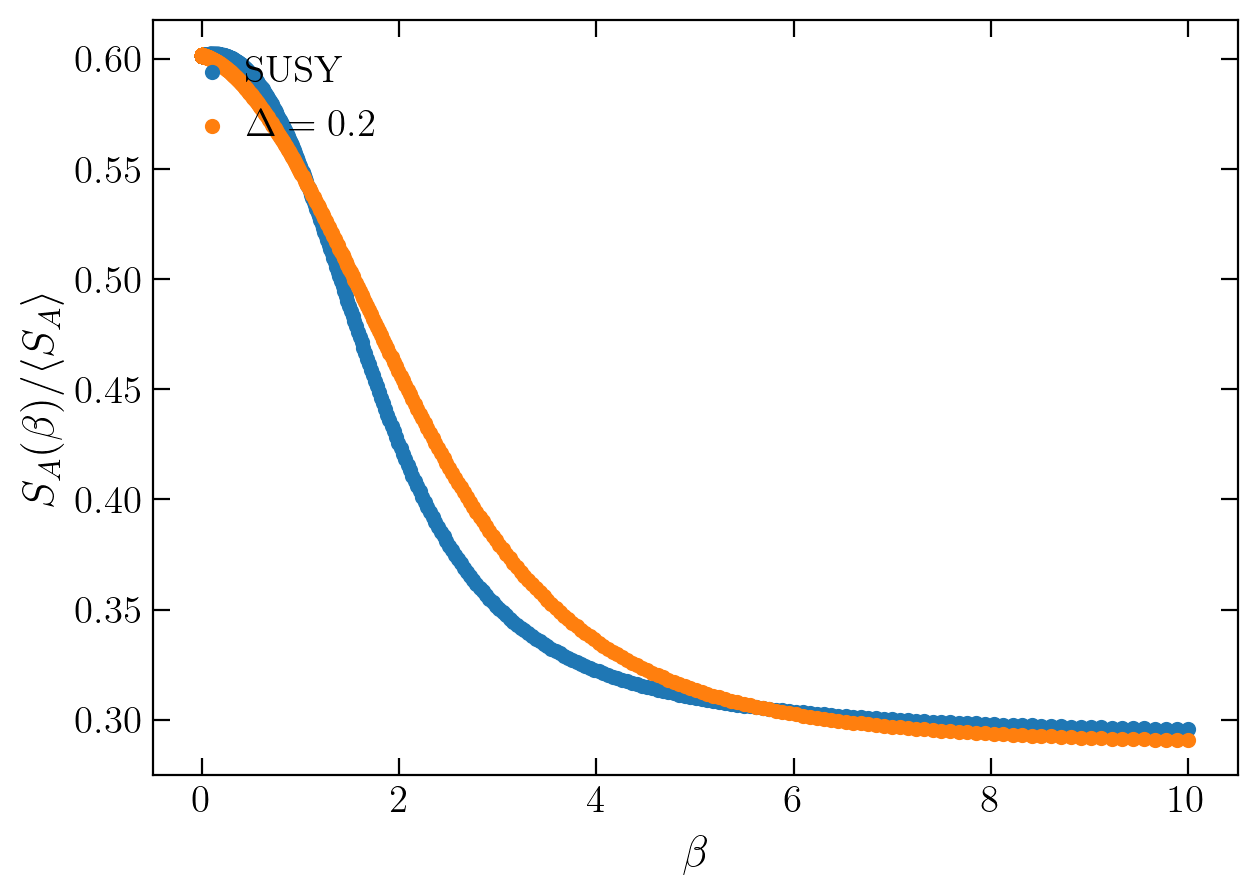

In [75]:

L=22

J1=1.0
d1=0.2
e1=0.2

real_sec, imag_sec = get_sectors(L)
sects = real_sec + imag_sec

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(7,5), dpi = 200, sharey=True)
LA = L//2
dim_tot = 0
Stot = []
betas = np.logspace(-4, 1, 1000)
eta = 0.2

for ijk, d1 in enumerate([-0.48, 0.2]):
    entropy = np.zeros(betas.shape)
    dim_tot = 0
    for [ks, ps, zxs, zzs] in sects:
        
        name = base_dir + 'Entropy/Eigenstate/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs) + ".hdf5"

        if exists(name):
            with h5py.File(name, "r") as file:
                energies = np.array(file.get('energies')[0])
                dim = energies.size

                S = np.array(file.get('entropy'))[LA]

                Sbeta = np.zeros(betas.shape)
                for ib, b in enumerate(betas):
                    
                    Sbeta[ib] = np.sum(np.exp(-b * energies) * S)
                    Z = np.sum(np.exp(-b * energies))
                    Sbeta[ib] /= Z

                dim_tot += dim if ks == 0 or (ks == L // 2 and L%2==0) else 2 * dim
                entropy += dim * Sbeta if ks == 0 or (ks == L // 2 and L%2==0) else 2 * dim * Sbeta
        else:
            print(name)
    entropy /= dim_tot

    axis.scatter(betas, entropy / (LA * np.log(2)), label = 'SUSY' if ijk == 0 else r"$\Delta=%.1f$"%d1, s=20)

fig_help.set_plot_elements(axis, ylabel=r"$S_A(\beta) / \langle S_A\rangle$", xlabel=r"$\beta$", font_size=14, set_legend=True)
axis.legend(frameon=0, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0))#, title=r"$\Delta=0.2$", title_fontsize=16)

In [ ]:

markers = itertools.cycle(markers_ls)
colors_ls_cyc = itertools.cycle(colors_ls)

frac = lambda dim: dim + 1


fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200, sharey=True, sharex=True)

plottt(axis[0], d1=0.2, e1=0.2, label = r"$\eta=0.2$", moment='typ')
plottt(axis[0], d1=0.2, e1=0.4, label = r"$\eta=0.4$", moment='typ')
plottt(axis[0], d1=0.2, e1=0.6, label = r"$\eta=0.6$", moment='typ')
plottt(axis[1], d1=-0.375, e1=0.5, label = r"$\Delta=-0.375$", moment='typ')
plottt(axis[1], d1=-0.75, e1=0.5, label = r"$\Delta=-0.75$", moment='typ')

fig_help.set_plot_elements(axis[0], ylabel=r"$\langle S_A\rangle_{\rm typ}/\overline{S_A}$", xlabel=r"$1/L_A$", font_size=14, set_legend=True, xscale='linear', yscale='linear')
axis[0].legend(frameon=0, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0), title=r"$\Delta=0.2$", title_fontsize=16)

fig_help.set_plot_elements(axis[1], ylabel="", xlabel=r"$1/L_A$", font_size=14, set_legend=True, xscale='linear', yscale='linear', xlim=(0, None), ylim=(None, 1.0))
axis[1].legend(frameon=0, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0), title=r"$\eta=0.5$ (SUSY)", title_fontsize=16)

fig.subplots_adjust(wspace = 0.02, hspace=0.3)

22 0.48 0.2 [0.49936353 0.55588966]
22 0.48 0.2 [0.64323971 0.53639208]
[3.08581521 3.54863099 3.94561247 4.35045058 4.74478086]
22 0.48 0.2 [0.50932141 0.5762182 ]
22 -0.48 0.2 [0.49478164 0.55634756]
22 -0.48 0.2 [0.63832225 0.53691744]
[3.12140359 3.52850395 3.93961753 4.34988903 4.74527733]
22 -0.48 0.2 [0.40001562 0.58673551]


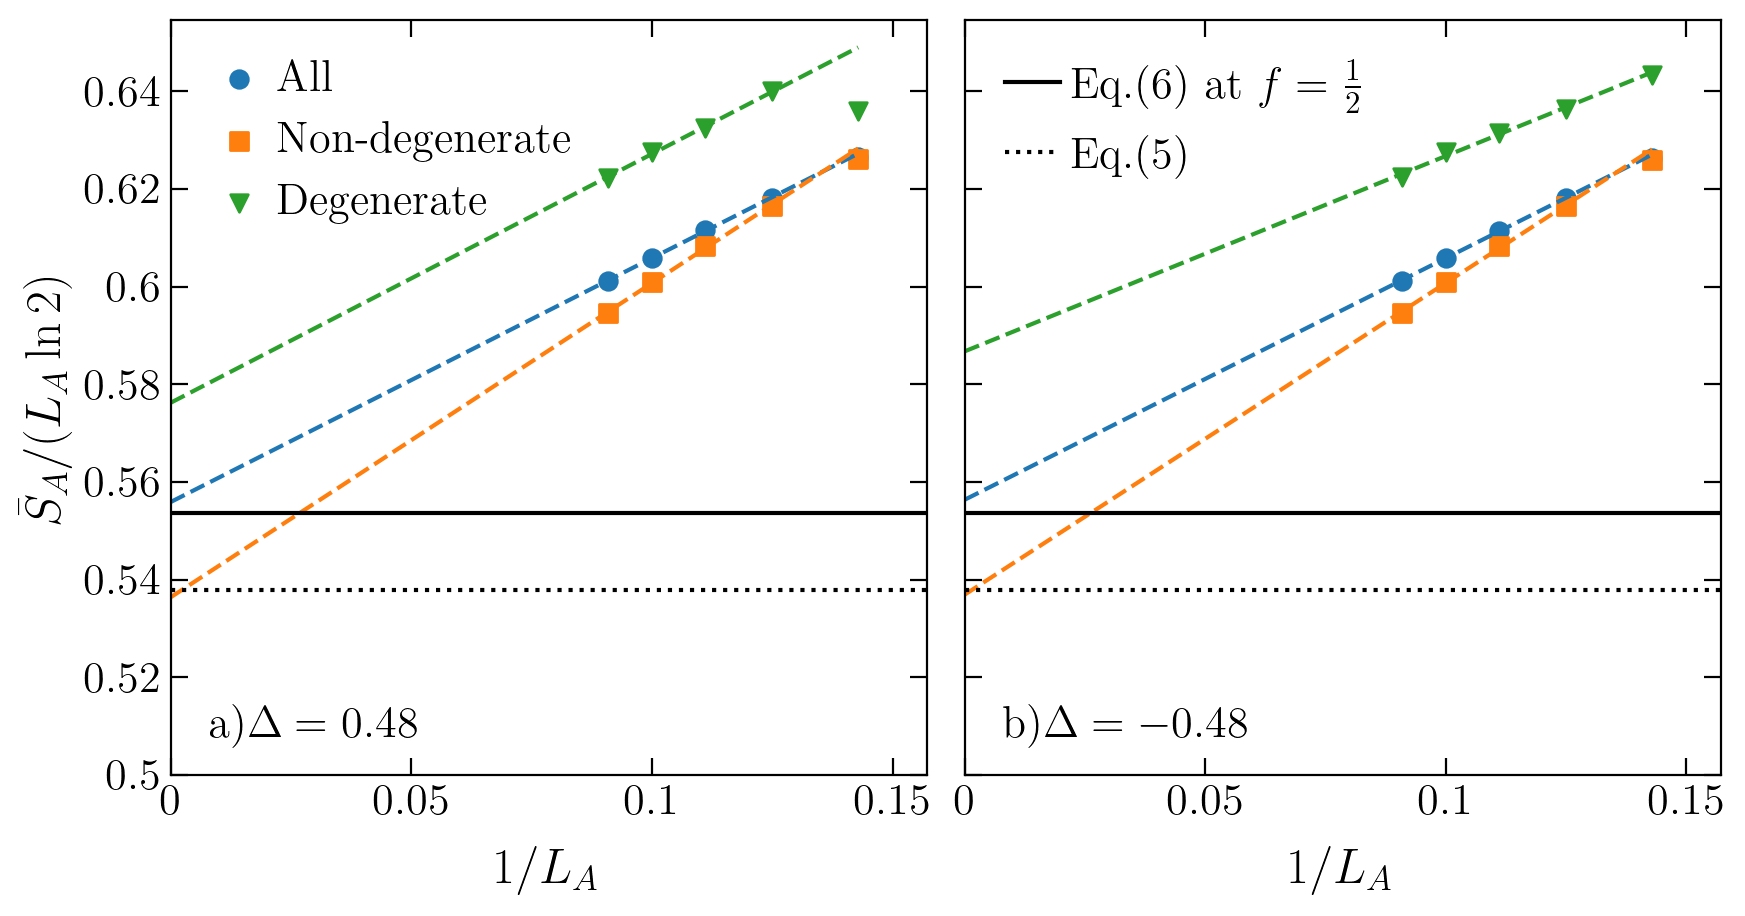

In [53]:
L=16

J1=1.0
d1=0.2
e1=0.2
sizes_even = np.arange(12,19,2) if BOUNDARY_COND == 'OBC' else np.arange(14, 23, 2)
sizes_odd = np.arange(11,19,2) if BOUNDARY_COND == 'OBC' else np.arange(15, 23, 2)

nu = 1.0

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200, sharey=True, sharex=True)

deltas = [0.48, -0.48]; eta=0.2
# deltas = [-0.375, -0.75]; eta = 0.5

for ax_id, [e1, d1] in enumerate([[eta, deltas[0]], [eta, deltas[1]]]):
# for ax_id, [e1, d1] in enumerate([[0.5, -0.375], [0.5, -0.75]]):

    if nu is None:
        nu = 1.0 if frac(10) >= 10 else (int(frac(0)) if frac(1000) == frac(10) else "%.2f"%(frac(100) / 100))
    os.makedirs(f'./RESULTS/nu={nu}/', exist_ok=True)
    os.makedirs(f'./RESULTS/nu={nu}/Entropy/', exist_ok=True)
    # sizes = sizes_even

    for ijkl, sizes in enumerate([sizes_even]):

        entropy = np.zeros((sizes.size))
        entropy_degen = np.zeros((sizes.size))
        entropy_all = np.zeros((sizes.size))
        LAA = (sizes / 2).astype(int)

        for ii, L in enumerate(sizes):
            LA = L // 2
            if exists(f'./RESULTS/nu={nu}/Entropy/_L={L},eta={e1},delta={d1}.csv'):
                df = pd.read_csv(f'./RESULTS/nu={nu}/Entropy/_L={L},eta={e1},delta={d1}.csv')
                entropy[ii] = np.array(df['<S>'])[LA]
                entropy_degen[ii] = np.array(df['<S>_deg'])[LA]
                entropy_all[ii] = np.array(df['<S>_all'])[LA]
        xx = 1.0 / (LAA)# page( LAA, sizes - LAA)

        # marks = ['s', 'o', 'v']

        markers = itertools.cycle(markers_ls)
        colors_ls_cyc = itertools.cycle(colors_ls)

        labels = ["All", "Non-degenerate", "Degenerate"]
        for new_id, S in enumerate([entropy_all, entropy, entropy_degen]):
            if new_id == 2: print(S)
            S = S[~np.isnan(S)]
            if S.size > 2:
                col = next(colors_ls_cyc)
                mark = next(markers)
                yy = S / (LAA * np.log(2)) #page( LAA, sizes - LAA)

                pars, pconv = fit(lin_fit2,
                                xdata = xx[1:],
                                ydata = yy[1:])
                print(L, d1, e1, pars)
                xval = np.linspace(0, max(xx), 100)
                axis[ax_id].plot(xval, lin_fit2(xval, *pars), ls='--', color=col)
                if ijkl:        axis[ax_id].scatter(xx, yy, marker=mark, s=40, color = col, facecolor = 'None')
                else:           
                    if ijkl == 0 and ax_id == 0:
                        axis[ax_id].scatter(xx, yy, marker=mark, s=40, color = col, label=labels[new_id])
                    else:
                        axis[ax_id].scatter(xx, yy, marker=mark, s=40, color = col)
            


axis[1].axhline(y=0.5537, ls='-', c='black', label=r'Eq.(6) at $f=\frac{1}{2}$')
axis[1].axhline(y=0.5378, ls=':', c='black', label=r'Eq.(5)')
axis[0].axhline(y=0.5537, ls='-', c='black')
axis[0].axhline(y=0.5378, ls=':', c='black')

fig_help.set_plot_elements(axis[0], ylabel=r"$\bar{S}_A/(L_A\ln2)$", xlabel=r"$1/L_A$", font_size=16, set_legend=True, xscale='linear', yscale='linear')
axis[0].legend(frameon=0, fontsize=16, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0))

fig_help.set_plot_elements(axis[1], ylabel="", xlabel=r"$1/L_A$", font_size=16, set_legend=True, xscale='linear', yscale='linear')
axis[1].legend(frameon=0, fontsize=16, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0))

axis[0].set_xlim(0, 2.2 / 14.)
axis[0].set_ylim(0.5, None)

for ax in axis:
    ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    ax.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))

axis[0].annotate(r"a)$\Delta=%g$"%deltas[0], fontsize=16, xy=(0.05, 0.05), xycoords='axes fraction')
axis[1].annotate(r"b)$\Delta=%g$"%deltas[1], fontsize=16, xy=(0.05, 0.05), xycoords='axes fraction')

# fig.suptitle(r"$\eta=0.2$", fontsize=18)
fig.subplots_adjust(wspace = 0.05, hspace=0.3)
plt.savefig("PLOTS/Fig_xyz_scaling_degenerate.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig("PLOTS/Fig_xyz_scaling_degenerate.png", bbox_inches = 'tight', pad_inches=0.02)

# SUPERSYMMETRY

In [46]:
from sympy import init_session 
init_session()

IPython console for SymPy 1.9 (Python 3.9.7-64-bit) (ground types: gmpy)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.9/



In [127]:
from sympy import Matrix, var
from sympy.physics.quantum import TensorProduct as tens
from sympy.physics.quantum.dagger import Dagger as dag
from sympy import Symbol, simplify, exp, log, pi
from sympy import I
from sympy import solve

eta = Symbol('eta', real=True)
lam = Symbol('lambda', real=True)
a = Symbol('a', real=True)
b = Symbol('b', real=True)

x1 = Symbol('x1', real=True)
x2 = Symbol('x2', real=True)
x3 = Symbol('x3', real=True)
x4 = Symbol('x4', real=True)

q1 = Matrix([[0, 1], [0, 0], [0, 0], [0, eta]])
q2 = Matrix([[eta, 0], [0, 0], [0, 0], [1, 0]])

e = Matrix([[1, 0], [0, 1]])

sigx = Matrix([[0, 1], [1, 0]])
sigy = Matrix([[0, -I], [I, 0]])
sigz = Matrix([[1, 0], [0, -1]])


up = Matrix([1, 0])
down = Matrix([0, 1])


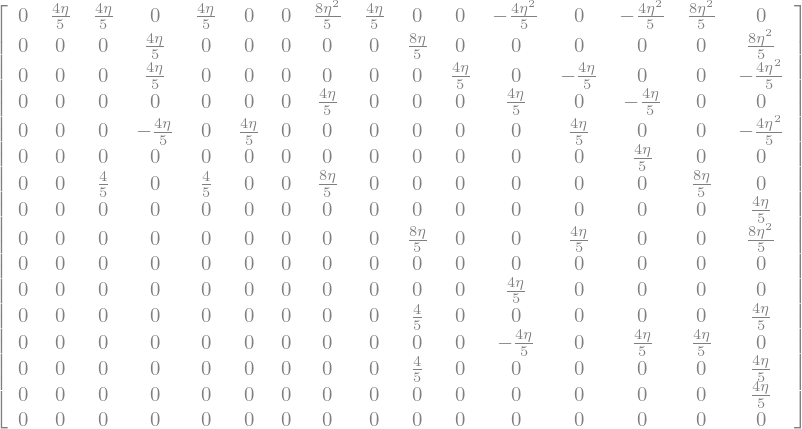

In [228]:
L=4

def make_matrix(L, pos, q):
    """
    Makes local supercharge 2^L+1 x 2^L at position pos
    """
    M = e if pos > 0 else q
    for indexi in range(1, L):
        M = tens(M, e) if indexi != pos else tens(M, q)
    return M

CN = zeros(2**(L), 2**L)

for ii in range(L):
    for jj in range(L):
        Q2 = make_matrix(L, ii, q2)
        Q1 = make_matrix(L, jj, q1)
        CN = CN + (-1)**(ii + jj) * dag(Q2) * Q1
CN = CN * L / (L+1)
#CN = CN + dag(CN)
#CN = CN.subs({eta: 0.5})
# a = CN.eigenvals()
# list(a)
# for xx in a:
#     print(xx)
CN

In [33]:
def make_product(L, op):
    M = op
    for indexi in range(1, L): 
        M = tens(M, op)
    return M
def make_Q(L):
    Q = make_matrix(L, 0, q1)
    for ii in range(1, L):
        M = make_matrix(L, ii, q1)
        Q = Q + (-1)**(ii) * M



In [ ]:
Px = make_product(L, sigx)
Py = make_product(L, sigy)
Pz = make_product(L, sigz)

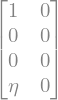

In [215]:
x = tens(sigz, sigz) * q2 * sigz


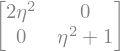

In [521]:
def ham_density(q):
    A = -tens(dag(q), e) * tens(e, q) - tens(e, dag(q)) * tens(q, e)
    return A + q * dag(q) + 0.5 * ( tens(dag(q) * q, e) + tens(e, dag(q) * q) )

q_obc = q1 + Matrix([[2*x1, 0], [x2, x1], [x2, x1], [0, 2*x2]])

q_obc = q_obc.subs({x2: -eta})
q_obc = q_obc.subs({x1: 0})
dag(q_obc) * q_obc

# x = (tens(q_obc, e) * q_obc - tens(e, q_obc) * q_obc)


# m = Matrix([a, b])

# bound = dag(q_obc) * q_obc / 2
# #x * m
# #ham_density(q_obc).subs({lam: eta})

# bound = -(1-eta)*x1 / (1+(x1**2 + x2*2)) * sigx - (1+eta)*x2 / (1+(x1**2 + x2*2)) * sigy + (eta**2-1)/4*( (1-(x1**2 + x2*2)) / (1+(x1**2 + x2*2)) ) * sigz
# bound = (bound.subs({x1 : 0})).subs({x2: 1})
# sigy * bound * sigy - bound

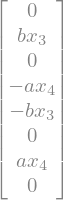

In [439]:

chi = Matrix([x3, 0, 0, x4])
tens(chi, m) - tens(m, chi)

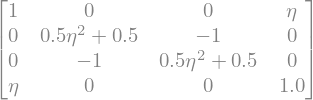

In [522]:

h2 = ham_density(q_obc)
h2

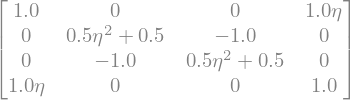

In [523]:
h = (1 - eta) * tens(sigx, sigx) + (1 + eta) * tens(sigy, sigy) + (eta**2 - 1) / 2 * tens(sigz, sigz)
h = (3 + eta**2) / 4 * tens(e,e) - 0.5*h
h

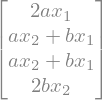

In [517]:
q_obc = q1 + Matrix([[2*x1, 0], [x2, x1], [x2, x1], [0, 2*x2]])
dag(q_obc)
q_obc

m = Matrix([a, b])
chi = Matrix([x1, x2])

tens(m, chi) + tens(chi, m)

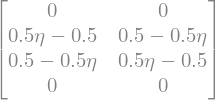

In [37]:
singlet = 1/np.sqrt(2) * Matrix([[1, -1], [-1, 1]])

SS = tens(singlet, e) - tens(e, singlet)

SS * q1 * singlet

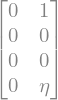

In [17]:
A = -tens(dag(q1), e) * tens(e, q1) - tens(e, dag(q1)) * tens(q1, e)
q1

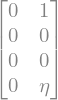

In [16]:
B = tens(up,  (sigx + sigy*I)) / 2 + eta * tens(down, (e - sigz)) / 2
B

In [48]:
Jx = Symbol('Jx', real=True)
Jy = Symbol('Jy', real=True)
Jz = Symbol('Jz', real=True)
hx = Symbol('hx', real=True)
hz = Symbol('hz', real=True)

q = Symbol('q', real=False)

x1 = Symbol('x1', real=True)
x2 = Symbol('x2', real=True)
x3 = Symbol('x3', real=True)
x4 = Symbol('x4', real=True)
x5 = Symbol('x5', real=True)
x6 = Symbol('x6', real=True)
x7 = Symbol('x7', real=True)
x8 = Symbol('x8', real=True)
x9 = Symbol('x9', real=True)

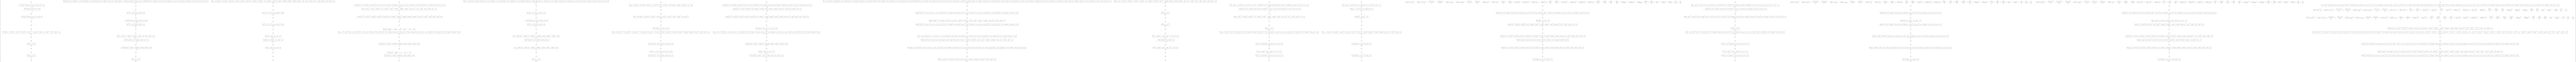

In [71]:
L=4
H = Matrix.zeros(2**L, 2**L)
X = Matrix.zeros(2**L, 2**L)

def expand_op(L, op, j):
    A = op if j == 1 else e
    for ii in range(2, L + 1):
        A = tens(A, op) if ii == j else tens(A, e)
    return A

Px = Matrix.eye(2**L, 2**L)
Py = Matrix.eye(2**L, 2**L)
Pz = Matrix.eye(2**L, 2**L)
P = Matrix.eye(2**L, 2**L)

op1 = Matrix([[q, 0], [0, 1/q]])
op2 = Matrix([[1/q, 0], [0, q]])

Xp = X
Xm = X

sig_p = sigx + I * sigy
sig_m = sigx - I * sigy
Xploc = sig_p
Xmloc = sig_m
for jj in range(2, L + 1):
    Xploc = tens(Xploc, op2)
    Xmloc = tens(Xmloc, op2)
    
Xp += Xploc
Xm += Xmloc

for ii in range(1, L + 1):
    #if ii < L:
    nei = ii + 1
    H += (1-eta) * expand_op(L, sigx, ii) * expand_op(L, sigx, nei if nei <= L else 1) / 2
    H += (1+eta) * expand_op(L, sigy, ii) * expand_op(L, sigy, nei if nei <= L else 1) / 2
    H += Jz * expand_op(L, sigz, ii) * expand_op(L, sigz, nei if nei <= L else 1) / 2
    
    Xploc = op1
    Xmloc = op1
    if ii > 1:
        for jj in range(2, L + 1):
            Xploc = tens(Xploc, op1) if jj < ii else (tens(Xploc, sig_p) if jj == ii else tens(Xploc, op2))
            Xmloc = tens(Xmloc, op1) if jj < ii else (tens(Xmloc, sig_p) if jj == ii else tens(Xmloc, op2))
            
        Xp += Xploc
        Xm += Xmloc
    # H += hx * expand_op(L, sigx, ii)
    # H += hz * expand_op(L, sigz, ii)
    # if ii % 2 == 0:
    #     Px = Px * expand_op(L, sigx + I*sigy, ii)
    #     Py = Py * expand_op(L, sigx - I*sigy, ii)
    #     #Pz = Pz * expand_op(L, sigz, ii)
    # else:
    # #     Px = Px * expand_op(L, sigz, ii)
    # #     Py = Py * expand_op(L, sigx, ii)
    #      Pz = Pz * expand_op(L, sigy, ii)

# P = (Jz * Px + Jz * Py + Jz*(Jx + Jy)*Pz)
# P * H - H * P
#tens(tens(sigx, e), e)
#expand_op(L, sigz, 2)

X = (Xp + eta * Xm)**3

simplify(X * H - H * X)#.subs({q: exp(2 * pi/3*I)}).subs({eta: 0})#.subs({Jz: (q + 1)/2})





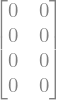

In [45]:
x1 = Symbol('x1', real = True)
x2 = Symbol('x2')

x3 = Symbol('x3', real=True)
x4 = Symbol('x4')
U = Matrix([[x1, x2], [dag(x2), x3]])

(tens(sigz, sigz) * q1 * sigz + q1)